In [1]:
# ============================================================
# 011 IPO Revenue Analysis
# ============================================================
# Purpose:
# Build a reproducible, year-specific pipeline to collect, normalize,
# and compare pre-IPO revenue trajectories for companies that went public
# in a given target year on:
# - NASDAQ (US)
# - TSE Growth Market (Japan)
#
# The notebook focuses on extracting revenue figures for approximately
# three fiscal years prior to listing, using authoritative public filings
# (SEC XBRL, EDINET XBRL), and producing analysis-ready tables.
#
# Scope:
# - Multiple companies per run (IPO cohort by year)
# - Public disclosure data only
#   - US: SEC XBRL (companyfacts)
#   - JP: EDINET API (XBRL / CSV)
# - No paid databases (e.g. PitchBook, Capital IQ)
# - No estimation or imputation unless explicitly flagged
#
# Outputs:
# 1. Unified revenue panel (long format)
#    - company_id / market / fiscal_year / revenue / currency
#    - source (SEC_XBRL / EDINET_XBRL / EDINET_CSV)
#    - confidence and QA flags
# 2. Wide-format comparison table
#    - FY-2 / FY-1 / FY0 (relative to latest pre-IPO FY)
# 3. Diagnostic QA tables
#    - missing years
#    - abnormal growth
#    - unit / scale inconsistencies
# 4. Visual comparisons
#    - US vs JP IPO revenue distributions
#    - selected company-level trajectories
#
# Language:
# - Code and comments: English
# - Outputs: numeric / tabular (no localization assumptions)
#
# Core Principles:
# - Separation of concerns:
#   UI & parameters → data acquisition → normalization → QA → analysis
# - Source-first:
#   Always prefer structured XBRL facts over parsed PDFs or text
# - No silent assumptions:
#   Missing or ambiguous values are explicitly flagged
# - Reproducibility:
#   Each run is tied to a fixed target year and timestamp
# - Auditability:
#   Raw responses and intermediate tables are preserved when feasible
#
# Workflow Overview:
# 1. Setup & environment configuration (this cell)
# 2. Parameter selection via widgets (target year, lookback window)
# 3. Helper functions (HTTP, parsing, normalization utilities)
# 4. IPO universe construction (NASDAQ / TSE Growth)
# 5. Universe QA and sanity checks
# 6. Revenue extraction (US: SEC XBRL)
# 7. Revenue extraction (JP: EDINET API)
# 8. Normalization & merging (US + JP)
# 9. QA & validation
# 10. Visualization & cross-market comparison
# 11. Final exports (CSV / Parquet)
#
# Suggested Directories:
# - data/raw/
#   - universe/        : IPO master lists (year-specific)
#   - sec/             : SEC XBRL JSON responses (cached)
#   - edinet/          : EDINET ZIP / CSV responses (cached)
# - data/processed/
#   - revenue_panels/  : normalized long & wide tables
#   - qa/              : validation and anomaly reports
# - logs/
#   - run_metadata/    : parameters, timestamps, execution notes
#
# ============================================================

In [2]:
# ============================================================
# 2. Parameters (Widget-based, Confirm-to-Freeze)
# ============================================================
# This cell defines run-level parameters via widgets.
# The key rule is: downstream cells must not run until parameters
# are explicitly confirmed (frozen) for reproducibility.
#
# Notes:
# - Changing widget values does NOT affect the run until "Confirm" is clicked.
# - After confirmation, parameters are stored in global variables used downstream.
# - Re-run this cell (or restart the kernel) to start a new run with new params.
# ============================================================

import os
from datetime import datetime, timezone
import ipywidgets as widgets
from IPython.display import display, clear_output

# -----------------------------
# Default values (safe baseline)
# -----------------------------
DEFAULT_TARGET_YEAR = 2025
DEFAULT_LOOKBACK_YEARS = 3

# Market switches (keep explicit; downstream can use these flags)
DEFAULT_ENABLE_NASDAQ = True
DEFAULT_ENABLE_TSE_GROWTH = True

# Output options
DEFAULT_OUTPUT_FORMATS = ["parquet", "csv"]  # supported: "parquet", "csv"
DEFAULT_CACHE_ENABLED = True

# -----------------------------
# Widgets
# -----------------------------
target_year_w = widgets.BoundedIntText(
    value=DEFAULT_TARGET_YEAR,
    min=2000,
    max=2100,
    step=1,
    description="Target Year:",
    style={"description_width": "120px"},
    layout=widgets.Layout(width="320px"),
)

lookback_years_w = widgets.BoundedIntText(
    value=DEFAULT_LOOKBACK_YEARS,
    min=1,
    max=10,
    step=1,
    description="Lookback (yrs):",
    style={"description_width": "120px"},
    layout=widgets.Layout(width="320px"),
)

enable_nasdaq_w = widgets.Checkbox(
    value=DEFAULT_ENABLE_NASDAQ,
    description="NASDAQ (US)",
    indent=False,
)

enable_tse_growth_w = widgets.Checkbox(
    value=DEFAULT_ENABLE_TSE_GROWTH,
    description="TSE Growth (JP)",
    indent=False,
)

cache_enabled_w = widgets.Checkbox(
    value=DEFAULT_CACHE_ENABLED,
    description="Enable caching",
    indent=False,
)

output_formats_w = widgets.SelectMultiple(
    options=["parquet", "csv"],
    value=tuple(DEFAULT_OUTPUT_FORMATS),
    description="Outputs:",
    style={"description_width": "120px"},
    layout=widgets.Layout(width="320px", height="70px"),
)

confirm_btn = widgets.Button(
    description="Confirm Parameters",
    button_style="primary",
    tooltip="Freeze parameters for this run",
    icon="check",
)

params_out = widgets.Output()

display(
    widgets.VBox([
        target_year_w,
        lookback_years_w,
        widgets.HBox([enable_nasdaq_w, enable_tse_growth_w]),
        cache_enabled_w,
        output_formats_w,
        confirm_btn,
        params_out,
    ])
)

# -----------------------------
# Confirmation / Freeze Logic
# -----------------------------
PARAMS_CONFIRMED = False

def _utc_timestamp() -> str:
    return datetime.now(timezone.utc).strftime("%Y%m%d_%H%M%S")

def _validate_params(target_year: int, lookback_years: int, markets: list[str]) -> None:
    if target_year < 2000 or target_year > 2100:
        raise ValueError("Target year out of supported range (2000-2100).")
    if lookback_years < 1 or lookback_years > 10:
        raise ValueError("Lookback years out of supported range (1-10).")
    if not markets:
        raise ValueError("At least one market must be enabled (NASDAQ and/or TSE Growth).")

def _on_confirm_clicked(_):
    global TARGET_YEAR,LOOKBACK_YEARS,MARKETS,OUTPUT_FORMATS,CACHE_ENABLED,RUN_ID,RUN_TS_UTC,PARAMS_CONFIRMED

    with params_out:
        clear_output()

        TARGET_YEAR = int(target_year_w.value)
        LOOKBACK_YEARS = int(lookback_years_w.value)

        MARKETS = []
        if bool(enable_nasdaq_w.value):
            MARKETS.append("NASDAQ")
        if bool(enable_tse_growth_w.value):
            MARKETS.append("TSE_GROWTH")

        OUTPUT_FORMATS = list(output_formats_w.value)
        CACHE_ENABLED = bool(cache_enabled_w.value)

        _validate_params(TARGET_YEAR, LOOKBACK_YEARS, MARKETS)

        RUN_TS_UTC = _utc_timestamp()
        RUN_ID = f"ipo_rev_{TARGET_YEAR}_{RUN_TS_UTC}"

        PARAMS_CONFIRMED = True

        print("Parameters confirmed ✅")
        print(f"  RUN_ID         : {RUN_ID}")
        print(f"  TARGET_YEAR    : {TARGET_YEAR}")
        print(f"  LOOKBACK_YEARS : {LOOKBACK_YEARS}")
        print(f"  MARKETS        : {MARKETS}")
        print(f"  CACHE_ENABLED  : {CACHE_ENABLED}")
        print(f"  OUTPUT_FORMATS : {OUTPUT_FORMATS}")
        print(f"  RUN_TS_UTC     : {RUN_TS_UTC}")
        print("\nProceed to the next cells.")

confirm_btn.on_click(_on_confirm_clicked)

# -----------------------------
# Downstream guard (copy/paste)
# -----------------------------
# In downstream cells, add:
#
# if not PARAMS_CONFIRMED:
#     raise RuntimeError("Parameters are not confirmed yet. Please run Cell 2 and click Confirm.")
#
# ============================================================


In [4]:
# ============================================================
# 3. Helper Functions (HTTP / Caching / Normalization / QA Utils)
# ============================================================
# This cell provides shared utilities used across the notebook:
# - HTTP requests with basic retry + rate limiting
# - Local caching for reproducibility and API friendliness
# - Normalization helpers (identifiers, fiscal years, units)
# - Lightweight QA helpers (missing checks, duplicate checks)
#
# Design rules:
# - Keep helpers pure where possible (input -> output)
# - Never silently guess: return None / raise with clear messages
# - Cache raw responses whenever CACHE_ENABLED=True
# ============================================================

from __future__ import annotations

import os
import re
import io
import json
import time
import math
import zipfile
import hashlib
from pathlib import Path
from typing import Any, Dict, Optional, Iterable, Tuple, List

import requests
import pandas as pd

# -----------------------------
# Paths (depend on Cell 2 params)
# -----------------------------
if not PARAMS_CONFIRMED:
    raise RuntimeError("Parameters are not confirmed yet. Please run Cell 2 and click Confirm.")

BASE_DIR = Path(".")
DATA_DIR = BASE_DIR / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"
LOG_DIR = BASE_DIR / "logs"

RAW_UNIVERSE_DIR = RAW_DIR / "universe"
RAW_SEC_DIR = RAW_DIR / "sec"
RAW_EDINET_DIR = RAW_DIR / "edinet"

PROC_PANEL_DIR = PROCESSED_DIR / "revenue_panels"
PROC_QA_DIR = PROCESSED_DIR / "qa"

for d in [
    RAW_UNIVERSE_DIR, RAW_SEC_DIR, RAW_EDINET_DIR,
    PROC_PANEL_DIR, PROC_QA_DIR, LOG_DIR
]:
    d.mkdir(parents=True, exist_ok=True)

# -----------------------------
# Small logging helpers
# -----------------------------
def log(msg: str) -> None:
    ts = time.strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{ts}] {msg}")

# -----------------------------
# Caching primitives
# -----------------------------
def _sha1(s: str) -> str:
    return hashlib.sha1(s.encode("utf-8")).hexdigest()

def cache_path(namespace: str, key: str, suffix: str = ".json") -> Path:
    """
    Build a stable cache path. `key` should be deterministic (e.g., URL).
    """
    safe = _sha1(key)
    return (RAW_DIR / namespace / f"{safe}{suffix}")

def load_json(path: Path) -> Optional[Dict[str, Any]]:
    if not path.exists():
        return None
    with path.open("r", encoding="utf-8") as f:
        return json.load(f)

def save_json(path: Path, obj: Any) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def save_bytes(path: Path, b: bytes) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    path.write_bytes(b)

# -----------------------------
# HTTP helpers (retry + pacing)
# -----------------------------
def http_get_json(
    url: str,
    params: Optional[Dict[str, Any]] = None,
    headers: Optional[Dict[str, str]] = None,
    timeout: int = 60,
    retry: int = 3,
    sleep_sec: float = 0.2,
    cache_namespace: Optional[str] = None,
    cache_key: Optional[str] = None,
) -> Dict[str, Any]:
    """
    GET a JSON response with retry + optional caching.
    Caching key defaults to URL + sorted params.
    """
    key = cache_key or (url + "?" + "&".join([f"{k}={params[k]}" for k in sorted(params or {})]))
    if CACHE_ENABLED and cache_namespace:
        p = cache_path(cache_namespace, key, suffix=".json")
        cached = load_json(p)
        if cached is not None:
            return cached

    last_err = None
    for i in range(retry):
        try:
            time.sleep(sleep_sec)
            r = requests.get(url, params=params, headers=headers, timeout=timeout)
            r.raise_for_status()
            data = r.json()
            if CACHE_ENABLED and cache_namespace:
                save_json(p, data)
            return data
        except Exception as e:
            last_err = e
            backoff = sleep_sec * (2 ** i)
            time.sleep(backoff)
    raise RuntimeError(f"GET JSON failed after {retry} retries: {url}") from last_err

def http_get_bytes(
    url: str,
    params: Optional[Dict[str, Any]] = None,
    headers: Optional[Dict[str, str]] = None,
    timeout: int = 120,
    retry: int = 3,
    sleep_sec: float = 0.2,
    cache_namespace: Optional[str] = None,
    cache_key: Optional[str] = None,
    suffix: str = ".bin",
) -> bytes:
    """
    GET raw bytes with retry + optional caching.
    """
    key = cache_key or (url + "?" + "&".join([f"{k}={params[k]}" for k in sorted(params or {})]))
    if CACHE_ENABLED and cache_namespace:
        p = cache_path(cache_namespace, key, suffix=suffix)
        if p.exists():
            return p.read_bytes()

    last_err = None
    for i in range(retry):
        try:
            time.sleep(sleep_sec)
            r = requests.get(url, params=params, headers=headers, timeout=timeout)
            r.raise_for_status()
            b = r.content
            if CACHE_ENABLED and cache_namespace:
                save_bytes(p, b)
            return b
        except Exception as e:
            last_err = e
            backoff = sleep_sec * (2 ** i)
            time.sleep(backoff)
    raise RuntimeError(f"GET bytes failed after {retry} retries: {url}") from last_err

# -----------------------------
# SEC helpers
# -----------------------------
def normalize_cik(cik: Any) -> str:
    """
    SEC CIK must be 10-digit zero-padded string for companyfacts endpoint.
    """
    s = str(cik).strip()
    s = re.sub(r"\D", "", s)
    if not s:
        raise ValueError("Invalid CIK")
    return s.zfill(10)

US_REVENUE_TAG_CANDIDATES: List[Tuple[str, str]] = [
    ("us-gaap", "Revenues"),
    ("us-gaap", "SalesRevenueNet"),
    ("ifrs-full", "Revenue"),
]

def pick_first_existing_fact(facts_json: Dict[str, Any], candidates: List[Tuple[str, str]]) -> Optional[Tuple[str, str, Dict[str, Any]]]:
    """
    Return the first (taxonomy, tag, concept_obj) that exists in companyfacts.
    """
    facts = facts_json.get("facts", {})
    for taxonomy, tag in candidates:
        concept = facts.get(taxonomy, {}).get(tag)
        if concept:
            return taxonomy, tag, concept
    return None

# -----------------------------
# EDINET helpers
# -----------------------------
def require_env(name: str) -> str:
    v = os.getenv(name)
    if not v:
        raise RuntimeError(f"Missing environment variable: {name}")
    return v

def unzip_bytes(zip_bytes: bytes) -> Dict[str, bytes]:
    z = zipfile.ZipFile(io.BytesIO(zip_bytes))
    return {name: z.read(name) for name in z.namelist()}

# -----------------------------
# Fiscal year / numeric normalization
# -----------------------------
def safe_int(x: Any) -> Optional[int]:
    try:
        if x is None or (isinstance(x, float) and math.isnan(x)):
            return None
        return int(x)
    except Exception:
        return None

def safe_float(x: Any) -> Optional[float]:
    try:
        if x is None:
            return None
        if isinstance(x, str) and x.strip() == "":
            return None
        return float(x)
    except Exception:
        return None

def latest_fy_year(df: pd.DataFrame, fy_col: str = "fy") -> Optional[int]:
    """
    Return the latest fiscal year in a long-format revenue table.
    """
    if df.empty or fy_col not in df.columns:
        return None
    years = [y for y in df[fy_col].dropna().unique().tolist() if safe_int(y) is not None]
    return max(years) if years else None

def filter_lookback_years(df: pd.DataFrame, fy_col: str, lookback_years: int) -> pd.DataFrame:
    """
    Keep only the last N fiscal years (relative to latest available year).
    """
    if df.empty:
        return df
    latest = latest_fy_year(df, fy_col=fy_col)
    if latest is None:
        return df
    min_year = latest - (lookback_years - 1)
    return df[df[fy_col].between(min_year, latest)].copy()

# -----------------------------
# Lightweight QA helpers
# -----------------------------
def assert_required_columns(df: pd.DataFrame, required: List[str], df_name: str = "df") -> None:
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"{df_name} missing required columns: {missing}")

def dedupe_keep_latest(df: pd.DataFrame, keys: List[str], sort_col: str) -> pd.DataFrame:
    """
    Deduplicate by keys, keeping the latest row by sort_col.
    """
    if df.empty:
        return df
    if sort_col in df.columns:
        return (df.sort_values(keys + [sort_col])
                 .groupby(keys, as_index=False)
                 .tail(1))
    return df.drop_duplicates(subset=keys, keep="last")

def add_missing_year_flags(
    df: pd.DataFrame,
    id_col: str,
    fy_col: str,
    expected_years: int,
) -> pd.DataFrame:
    """
    Add a per-company flag if the number of distinct fiscal years is < expected.
    """
    if df.empty:
        return df.assign(missing_years_flag=True)

    counts = (df.groupby(id_col)[fy_col]
                .nunique()
                .reset_index(name="fy_count"))
    counts["missing_years_flag"] = counts["fy_count"] < expected_years
    return df.merge(counts[[id_col, "fy_count", "missing_years_flag"]], on=id_col, how="left")

log("Helper functions loaded.")


[2025-12-25 01:00:59] Helper functions loaded.


In [5]:
# ============================================================
# 4. Build Universe: IPO list (NASDAQ + TSE Growth)
# ============================================================

if not PARAMS_CONFIRMED:
    raise RuntimeError("Parameters are not confirmed yet. Please run Cell 2 and click Confirm.")

import os
import re
from pathlib import Path
from datetime import datetime
from dotenv import load_dotenv

import pandas as pd

# ----------------------------
# 4-0. Load API Keys (env.txt)
# ----------------------------
# Load env.txt explicitly (same convention as your other notebooks)
load_dotenv("env.txt", override=True)

# --- EDINET ---
EDINET_API_KEY = os.getenv("EDINET_API_KEY")
if EDINET_API_KEY is None:
    raise ValueError("EDINET_API_KEY could not be loaded from env.txt.")
else:
    print("✅ EDINET_API_KEY loaded successfully")

# --- SEC (no API key, but User-Agent should include contact email) ---
SEC_USER_AGENT = (os.getenv("SEC_USER_AGENT") or "").strip()
if not SEC_USER_AGENT:
    print("⚠️ SEC_USER_AGENT not found in env.txt. Consider setting it for polite SEC access.")
    print("   Example: SEC_USER_AGENT=YourOrgName your_email@example.com")
elif "@" not in SEC_USER_AGENT:
    print("⚠️ SEC_USER_AGENT found but does not include an email. SEC may return 403.")
    print("   Example: SEC_USER_AGENT=YourOrgName your_email@example.com")

# ----------------------------
# 4-1. Universe input mode
# ----------------------------
# Recommended: keep a curated CSV for each market/year.
UNIVERSE_MODE = "csv"  # "csv" (recommended) or "api" (optional scaffolding)
log(f"Universe mode: {UNIVERSE_MODE}")

# Expected CSV locations (you can adapt filenames)
# - NASDAQ: data/raw/universe/nasdaq_ipo_{TARGET_YEAR}.csv
# - TSE Growth: data/raw/universe/tse_growth_ipo_{TARGET_YEAR}.csv
NASDAQ_CSV = RAW_UNIVERSE_DIR / f"nasdaq_ipo_{TARGET_YEAR}.csv"
TSE_GROWTH_CSV = RAW_UNIVERSE_DIR / f"tse_growth_ipo_{TARGET_YEAR}.csv"

# ----------------------------
# 4-2. Minimal schema (what downstream expects)
# ----------------------------
# Required (master):
# - market: normalized to "NASDAQ", "NYSE", or "TSE_GROWTH" (and preserved as market_raw)
# - company_name
# - listing_date (normalized to ISO: YYYY-MM-DD)
# - source_url or source_note
#
# Recommended:
# - ticker (US)
# - cik (US, optional; can be resolved later)
# - edinet_code (JP, optional; EDINET submitter code like "E0xxxx")
# - stock_code (JP, optional; JPX stock code like "480A")
#
REQUIRED_COLS_MASTER = ["market", "company_name", "listing_date"]

def extract_nasdaq_tier(market_raw: str) -> str | None:
    s = str(market_raw).upper()
    if "GLOBAL SELECT" in s:
        return "GLOBAL_SELECT"
    if "GLOBAL" in s:
        return "GLOBAL"
    if "CAPITAL" in s:
        return "CAPITAL"
    return None

def normalize_market(m: str) -> str:
    s = str(m).upper().strip()
    if s.startswith("NASDAQ"):
        return "NASDAQ"
    if s == "NYSE":
        return "NYSE"
    if s in {"TSE GROWTH", "TSE_GROWTH", "GROWTH"}:
        return "TSE_GROWTH"
    if s in {"TSE", "TOKYO"}:
        # we only support TSE Growth in this notebook; keep as OTHER for now
        return "OTHER"
    return "OTHER"

def _ensure_master_schema(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Normalize column names
    df.columns = [c.strip().lower() for c in df.columns]

    # Synonyms -> canonical columns
    rename_map = {
        "company": "company_name",
        "name": "company_name",
        "listingdate": "listing_date",
        "ipo_date": "listing_date",
        "date": "listing_date",
        "stockcode": "stock_code",
        "security_code": "stock_code",
        "securities_code": "stock_code",
        "edinet": "edinet_code",
        "edinetcode": "edinet_code",
    }
    for k, v in rename_map.items():
        if k in df.columns and v not in df.columns:
            df.rename(columns={k: v}, inplace=True)

    # Ensure optional columns exist (so downstream code can rely on them)
    for col in ["ticker", "cik", "edinet_code", "stock_code", "source_url", "source_note"]:
        if col not in df.columns:
            df[col] = None

    # Required columns check (before further normalization)
    assert_required_columns(df, REQUIRED_COLS_MASTER, df_name="universe_df")

    # Preserve raw market for audit, then normalize market
    df["market_raw"] = df["market"].astype(str).str.strip()
    df["nasdaq_tier"] = df["market_raw"].apply(extract_nasdaq_tier)
    df["market"] = df["market_raw"].apply(normalize_market)

    # Company name normalization
    df["company_name"] = df["company_name"].astype(str).str.strip()

    # Date normalization to ISO (stable for pandas & CSV)
    df["listing_date"] = (
        pd.to_datetime(df["listing_date"], errors="coerce")
          .dt.strftime("%Y-%m-%d")
    )

    return df

# ----------------------------
# 4-3. Load (CSV-first)
# ----------------------------
dfs: list[pd.DataFrame] = []

if "NASDAQ" in MARKETS:
    if not NASDAQ_CSV.exists():
        raise FileNotFoundError(
            f"Missing NASDAQ universe CSV: {NASDAQ_CSV}\n"
            "Create it first (recommended) or switch UNIVERSE_MODE to 'api' later."
        )
    df_us = pd.read_csv(NASDAQ_CSV)
    # Keep provided market values if present; if missing, default to NASDAQ
    if "market" not in [c.strip().lower() for c in df_us.columns]:
        df_us["market"] = "NASDAQ"
    df_us = _ensure_master_schema(df_us)
    dfs.append(df_us)
    log(f"Loaded US universe: {len(df_us):,} rows from {NASDAQ_CSV}")

if "TSE_GROWTH" in MARKETS:
    if not TSE_GROWTH_CSV.exists():
        raise FileNotFoundError(
            f"Missing TSE Growth universe CSV: {TSE_GROWTH_CSV}\n"
            "Create it first (recommended) or switch UNIVERSE_MODE to 'api' later."
        )
    df_jp = pd.read_csv(TSE_GROWTH_CSV)
    # Keep provided market values if present; if missing, default to TSE Growth
    if "market" not in [c.strip().lower() for c in df_jp.columns]:
        df_jp["market"] = "TSE_GROWTH"
    df_jp = _ensure_master_schema(df_jp)
    dfs.append(df_jp)
    log(f"Loaded JP universe: {len(df_jp):,} rows from {TSE_GROWTH_CSV}")

universe_df = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame(columns=REQUIRED_COLS_MASTER)

# ----------------------------
# 4-4. Basic filtering / normalization
# ----------------------------
# Keep only TARGET_YEAR IPOs (defensive)
universe_df["listing_year"] = pd.to_datetime(universe_df["listing_date"], errors="coerce").dt.year
universe_df = universe_df[universe_df["listing_year"] == TARGET_YEAR].copy()

# Create a stable internal id (used for merges)
universe_df["company_key"] = (
    universe_df["market"].astype(str) + "||" +
    universe_df["company_name"].astype(str).str.lower().str.strip()
)

# Helpful ordering
universe_df = universe_df.sort_values(["market", "listing_date", "company_name"]).reset_index(drop=True)

log(f"Universe built: {len(universe_df):,} companies for TARGET_YEAR={TARGET_YEAR} across MARKETS={MARKETS}")
display(universe_df.head(20))

# ----------------------------
# 4-5. Save universe (auditable artifact)
# ----------------------------
universe_out_path = RAW_UNIVERSE_DIR / f"universe_ipo_{TARGET_YEAR}_{RUN_ID}.csv"
universe_df.to_csv(universe_out_path, index=False)
log(f"Saved universe: {universe_out_path}")


✅ EDINET_API_KEY loaded successfully
[2025-12-25 01:01:01] Universe mode: csv
[2025-12-25 01:01:01] Loaded US universe: 369 rows from data/raw/universe/nasdaq_ipo_2025.csv
[2025-12-25 01:01:01] Loaded JP universe: 43 rows from data/raw/universe/tse_growth_ipo_2025.csv
[2025-12-25 01:01:01] Universe built: 412 companies for TARGET_YEAR=2025 across MARKETS=['NASDAQ', 'TSE_GROWTH']


,company_name,ticker,market,listing_date,source_url,cik,edinet_code,stock_code,source_note,market_raw,nasdaq_tier,listing_year,company_key
0,INLIF Ltd,INLF,NASDAQ,2025-01-02,https://www.nasdaq.com/market-activity/ipos,None,None,None,None,NASDAQ Capital,CAPITAL,2025,NASDAQ||inlif ltd
1,"Cantor Equity Partners I, Inc.",CEPO,NASDAQ,2025-01-07,https://www.nasdaq.com/market-activity/ipos,None,None,None,None,NASDAQ Global,GLOBAL,2025,"NASDAQ||cantor equity partners i, inc."
2,Zhengye Biotechnology Holding Ltd,ZYBT,NASDAQ,2025-01-07,https://www.nasdaq.com/market-activity/ipos,None,None,None,None,NASDAQ Capital,CAPITAL,2025,NASDAQ||zhengye biotechnology holding ltd
3,3 E Network Technology Group Ltd,MASK,NASDAQ,2025-01-08,https://www.nasdaq.com/market-activity/ipos,None,None,None,None,NASDAQ Capital,CAPITAL,2025,NASDAQ||3 e network technology group ltd
4,Mint Inc Ltd,MIMI,NASDAQ,2025-01-10,https://www.nasdaq.com/market-activity/ipos,None,None,None,None,NASDAQ Capital,CAPITAL,2025,NASDAQ||mint inc ltd
5,Uni-Fuels Holdings Ltd,UFG,NASDAQ,2025-01-14,https://www.nasdaq.com/market-activity/ipos,None,None,None,None,NASDAQ Capital,CAPITAL,2025,NASDAQ||uni-fuels holdings ltd
6,Hong Kong Pharma Digital Technology Holdings Ltd,HKPD,NASDAQ,2025-01-15,https://www.nasdaq.com/market-activity/ipos,None,None,None,None,NASDAQ Capital,CAPITAL,2025,NASDAQ||hong kong pharma digital technology ho...
7,"Plum Acquisition Corp, IV",PLMKU,NASDAQ,2025-01-15,https://www.nasdaq.com/market-activity/ipos,None,None,None,None,NASDAQ Global,GLOBAL,2025,"NASDAQ||plum acquisition corp, iv"
8,Ribbon Acquisition Corp.,RIBBU,NASDAQ,2025-01-15,https://www.nasdaq.com/market-activity/ipos,None,None,None,None,NASDAQ Capital,CAPITAL,2025,NASDAQ||ribbon acquisition corp.
9,PicoCELA Inc.,PCLA,NASDAQ,2025-01-16,https://www.nasdaq.com/market-activity/ipos,None,None,None,None,NASDAQ Capital,CAPITAL,2025,NASDAQ||picocela inc.


[2025-12-25 01:01:01] Saved universe: data/raw/universe/universe_ipo_2025_ipo_rev_2025_20251224_160054.csv


In [6]:
# ============================================================
# 5. Universe QA (Integrity & Sanity Checks) + Drop NYSE MKT
# ============================================================

import pandas as pd

if not PARAMS_CONFIRMED:
    raise RuntimeError("Parameters are not confirmed yet. Please run Cell 2 and click Confirm.")

log("Starting Universe QA checks...")

qa_df = universe_df.copy()

# -----------------------------
# 5-0. Drop out-of-scope markets (NYSE MKT / NYSE AMKT / etc.)
# -----------------------------
# We drop these rows (rather than fail) to keep the pipeline moving.
# Keep both checks: market (normalized) and market_raw (original).
drop_patterns = [
    r"NYSE\s*MKT",      # "NYSE MKT"
    r"NYSE\s*AMKT",     # "NYSE AMKT"
    r"NYSE\s*AMERICAN", # "NYSE AMERICAN"
]

raw = qa_df.get("market_raw", qa_df["market"]).astype(str).str.upper().fillna("")
drop_mask = raw.str.contains("|".join(drop_patterns), regex=True)

dropped_df = qa_df[drop_mask].copy()
if not dropped_df.empty:
    log(f"Dropping out-of-scope market rows (NYSE MKT/AMKT/etc.): {len(dropped_df):,} rows")
    display(dropped_df[["company_name", "ticker", "market", "market_raw", "listing_date", "source_url"]].head(20))

qa_df = qa_df[~drop_mask].copy()

# -----------------------------
# 5-1. Parse listing_date once (robust NaT handling)
# -----------------------------
qa_df["listing_dt"] = pd.to_datetime(qa_df["listing_date"], errors="coerce")
qa_df["listing_year"] = qa_df["listing_dt"].dt.year

qa_df["qa_wrong_year"] = qa_df["listing_year"] != TARGET_YEAR
qa_df["qa_invalid_listing_date"] = qa_df["listing_dt"].isna()

# Optional: future-date check (recommended)
today = pd.Timestamp.today(tz="Asia/Tokyo").date()
qa_df["qa_listing_date_in_future"] = qa_df["listing_dt"].dt.date > today

# -----------------------------
# 5-2. Market validity check
# -----------------------------
ALLOWED_MARKETS = {"NASDAQ", "NYSE", "TSE_GROWTH"}
qa_df["qa_invalid_market"] = ~qa_df["market"].isin(ALLOWED_MARKETS)

# -----------------------------
# 5-3. Duplicate detection (identifier-first) + Auto-resolve
# -----------------------------
qa_df["company_name_norm"] = (
    qa_df["company_name"].astype(str)
      .str.lower()
      .str.replace(r"\s+", " ", regex=True)
      .str.strip()
)

qa_df["ticker_norm"] = qa_df["ticker"].astype(str).str.upper().str.strip()
qa_df["stock_code_norm"] = qa_df["stock_code"].astype(str).str.upper().str.strip()
qa_df["edinet_code_norm"] = qa_df["edinet_code"].astype(str).str.upper().str.strip()

def _is_blank(x: str) -> bool:
    return x in ["", "NAN", "NONE", "NULL"]

def _dedupe_key(row) -> str:
    m = row["market"]
    if m in ["NASDAQ", "NYSE"] and not _is_blank(row["ticker_norm"]):
        return f"{m}||TICKER||{row['ticker_norm']}"
    if m == "TSE_GROWTH" and not _is_blank(row["stock_code_norm"]):
        return f"{m}||STOCK||{row['stock_code_norm']}"
    return f"{m}||NAME||{row['company_name_norm']}"

qa_df["dedupe_key"] = qa_df.apply(_dedupe_key, axis=1)
qa_df["qa_duplicate_company"] = qa_df.duplicated(subset=["dedupe_key"], keep=False)

dup_rows = int(qa_df["qa_duplicate_company"].sum())
if dup_rows > 0:
    log(f"Auto-resolving duplicates: {dup_rows:,} rows are in duplicate groups.")
    qa_df["_has_source_url"] = qa_df["source_url"].notna() & (qa_df["source_url"].astype(str).str.strip() != "")
    qa_df["_has_identifier"] = False
    qa_df.loc[qa_df["market"].isin(["NASDAQ", "NYSE"]), "_has_identifier"] = ~qa_df["ticker_norm"].apply(_is_blank)
    qa_df.loc[qa_df["market"] == "TSE_GROWTH", "_has_identifier"] = ~qa_df["stock_code_norm"].apply(_is_blank)

    qa_df = (
        qa_df.sort_values(
            by=["dedupe_key", "_has_source_url", "_has_identifier", "listing_dt", "company_name", "source_url"],
            ascending=[True, False, False, True, True, True],
            na_position="last"
        )
        .groupby("dedupe_key", as_index=False)
        .head(1)
        .reset_index(drop=True)
        .drop(columns=["_has_source_url", "_has_identifier"])
    )
    qa_df["qa_duplicate_company"] = qa_df.duplicated(subset=["dedupe_key"], keep=False)

# -----------------------------
# 5-4. Identifier availability (warnings)
# -----------------------------
qa_df["qa_missing_ticker"] = (
    (qa_df["market"].isin(["NASDAQ", "NYSE"])) &
    (qa_df["ticker"].isna() | qa_df["ticker_norm"].apply(_is_blank))
)

qa_df["qa_missing_stock_code"] = (
    (qa_df["market"] == "TSE_GROWTH") &
    (qa_df["stock_code"].isna() | qa_df["stock_code_norm"].apply(_is_blank))
)

qa_df["qa_missing_edinet_code"] = (
    (qa_df["market"] == "TSE_GROWTH") &
    (qa_df["edinet_code"].isna() | qa_df["edinet_code_norm"].apply(_is_blank))
)

qa_df["qa_edinet_code_format_suspect"] = (
    (qa_df["market"] == "TSE_GROWTH") &
    qa_df["edinet_code"].notna() &
    ~qa_df["edinet_code_norm"].apply(_is_blank) &
    ~qa_df["edinet_code_norm"].str.startswith("E")
)

# -----------------------------
# 5-5. Aggregate QA flags
# -----------------------------
QA_FLAG_COLS = [
    "qa_wrong_year",
    "qa_invalid_market",
    "qa_duplicate_company",
    "qa_missing_ticker",
    "qa_missing_stock_code",
    "qa_missing_edinet_code",
    "qa_invalid_listing_date",
    "qa_listing_date_in_future",
    "qa_edinet_code_format_suspect",
]
qa_df["qa_any_issue"] = qa_df[QA_FLAG_COLS].any(axis=1)

universe_qa_df = qa_df.copy()
universe_issues_df = qa_df[qa_df["qa_any_issue"]].copy()

# -----------------------------
# 5-6. Summary
# -----------------------------
log("Universe QA summary (post-drop & post-dedupe):")
display(pd.DataFrame({
    "total_rows": [len(universe_qa_df)],
    "rows_with_issues": [len(universe_issues_df)],
    "wrong_year": [int(qa_df["qa_wrong_year"].sum())],
    "invalid_market": [int(qa_df["qa_invalid_market"].sum())],
    "duplicates_remaining": [int(qa_df["qa_duplicate_company"].sum())],
    "missing_ticker": [int(qa_df["qa_missing_ticker"].sum())],
    "missing_stock_code": [int(qa_df["qa_missing_stock_code"].sum())],
    "missing_edinet_code": [int(qa_df["qa_missing_edinet_code"].sum())],
    "edinet_code_format_suspect": [int(qa_df["qa_edinet_code_format_suspect"].sum())],
    "invalid_listing_date": [int(qa_df["qa_invalid_listing_date"].sum())],
    "listing_date_in_future": [int(qa_df["qa_listing_date_in_future"].sum())],
    "dropped_nyse_mkt_rows": [len(dropped_df)],
}))

if not universe_issues_df.empty:
    log("Rows with QA issues detected (showing first 20):")
    display(universe_issues_df.head(20))

# -----------------------------
# 5-7. Hard-stop conditions
# -----------------------------
# NOTE:
# - NYSE MKT rows are dropped (not failed).
# - Duplicates are auto-resolved (not critical).
CRITICAL_FLAGS = [
    "qa_wrong_year",
    "qa_invalid_market",
    "qa_invalid_listing_date",
]
# Optional: treat future dates as critical
# CRITICAL_FLAGS.append("qa_listing_date_in_future")

critical_count = universe_qa_df[CRITICAL_FLAGS].any(axis=1).sum()
if critical_count > 0:
    raise RuntimeError(
        f"Universe QA failed: {critical_count} rows have critical issues. "
        "Please fix the universe CSV before proceeding."
    )

# -----------------------------
# 5-8. Persist cleaned universe for downstream cells
# -----------------------------
universe_df = universe_qa_df.drop(columns=["qa_any_issue"], errors="ignore").copy()
log("Universe QA passed (NYSE MKT dropped). Proceeding to revenue extraction.")


[2025-12-25 01:01:06] Starting Universe QA checks...
[2025-12-25 01:01:06] Dropping out-of-scope market rows (NYSE MKT/AMKT/etc.): 20 rows


,company_name,ticker,market,market_raw,listing_date,source_url
349,Toppoint Holdings Inc.,TOPP,OTHER,NYSE MKT,2025-01-22,https://www.nasdaq.com/market-activity/ipos
350,Luda Technology Group Ltd,LUD,OTHER,NYSE MKT,2025-02-27,https://www.nasdaq.com/market-activity/ipos
351,Micropolis Holding Co,MCRP,OTHER,NYSE MKT,2025-03-07,https://www.nasdaq.com/market-activity/ipos
352,LOGPROSTYLE INC.,LGPS,OTHER,NYSE MKT,2025-03-25,https://www.nasdaq.com/market-activity/ipos
353,TMD Energy Ltd,TMDE,OTHER,NYSE MKT,2025-04-21,https://www.nasdaq.com/market-activity/ipos
354,"Apimeds Pharmaceuticals US, Inc.",APUS,OTHER,NYSE MKT,2025-05-09,https://www.nasdaq.com/market-activity/ipos
355,Vantage Corp (Singapore),VNTG,OTHER,NYSE MKT,2025-06-12,https://www.nasdaq.com/market-activity/ipos
356,ENIGMATIG LTD,EGG,OTHER,NYSE MKT,2025-06-18,https://www.nasdaq.com/market-activity/ipos
357,Nasus Pharma Ltd,NSRX,OTHER,NYSE MKT,2025-08-13,https://www.nasdaq.com/market-activity/ipos
358,"Picard Medical, Inc.",PMI,OTHER,NYSE MKT,2025-08-29,https://www.nasdaq.com/market-activity/ipos


[2025-12-25 01:01:06] Universe QA summary (post-drop & post-dedupe):


,total_rows,rows_with_issues,wrong_year,invalid_market,duplicates_remaining,missing_ticker,missing_stock_code,missing_edinet_code,edinet_code_format_suspect,invalid_listing_date,listing_date_in_future,dropped_nyse_mkt_rows
0,392,43,0,0,0,0,0,43,0,0,0,20


[2025-12-25 01:01:06] Rows with QA issues detected (showing first 20):


,company_name,ticker,market,listing_date,source_url,cik,edinet_code,stock_code,source_note,market_raw,...,ticker_norm,stock_code_norm,edinet_code_norm,dedupe_key,qa_duplicate_company,qa_missing_ticker,qa_missing_stock_code,qa_missing_edinet_code,qa_edinet_code_format_suspect,qa_any_issue
369,（株）技術承継機構,None,TSE_GROWTH,2025-02-05,https://www.jpx.co.jp/listing/stocks/new/index...,None,None,319A,None,TSE Growth,...,NONE,319A,NONE,TSE_GROWTH||STOCK||319A,False,False,False,True,False,True
370,（株）フライヤー,None,TSE_GROWTH,2025-02-20,https://www.jpx.co.jp/listing/stocks/new/index...,None,None,323A,None,TSE Growth,...,NONE,323A,NONE,TSE_GROWTH||STOCK||323A,False,False,False,True,False,True
371,（株）ブッキングリゾート,None,TSE_GROWTH,2025-02-21,https://www.jpx.co.jp/listing/stocks/new/index...,None,None,324A,None,TSE Growth,...,NONE,324A,NONE,TSE_GROWTH||STOCK||324A,False,False,False,True,False,True
372,（株）TENTIAL,None,TSE_GROWTH,2025-02-28,https://www.jpx.co.jp/listing/stocks/new/index...,None,None,325A,None,TSE Growth,...,NONE,325A,NONE,TSE_GROWTH||STOCK||325A,False,False,False,True,False,True
373,（株）TalentX,None,TSE_GROWTH,2025-03-18,https://www.jpx.co.jp/listing/stocks/new/index...,None,None,330A,None,TSE Growth,...,NONE,330A,NONE,TSE_GROWTH||STOCK||330A,False,False,False,True,False,True
374,ミーク（株）,None,TSE_GROWTH,2025-03-21,https://www.jpx.co.jp/listing/stocks/new/index...,None,None,332A,None,TSE Growth,...,NONE,332A,NONE,TSE_GROWTH||STOCK||332A,False,False,False,True,False,True
375,（株）ミライロ,None,TSE_GROWTH,2025-03-24,https://www.jpx.co.jp/listing/stocks/new/index...,None,None,335A,None,TSE Growth,...,NONE,335A,NONE,TSE_GROWTH||STOCK||335A,False,False,False,True,False,True
376,（株）ビジュアル・プロセッシング・ジャパン,None,TSE_GROWTH,2025-03-25,https://www.jpx.co.jp/listing/stocks/new/index...,None,None,334A,None,TSE Growth,...,NONE,334A,NONE,TSE_GROWTH||STOCK||334A,False,False,False,True,False,True
377,ダイナミックマッププラットフォーム（株）,None,TSE_GROWTH,2025-03-27,https://www.jpx.co.jp/listing/stocks/new/index...,None,None,336A,None,TSE Growth,...,NONE,336A,NONE,TSE_GROWTH||STOCK||336A,False,False,False,True,False,True
378,（株）ＺｅｎｍｕＴｅｃｈ,None,TSE_GROWTH,2025-03-27,https://www.jpx.co.jp/listing/stocks/new/index...,None,None,338A,None,TSE Growth,...,NONE,338A,NONE,TSE_GROWTH||STOCK||338A,False,False,False,True,False,True


[2025-12-25 01:01:06] Universe QA passed (NYSE MKT dropped). Proceeding to revenue extraction.


In [7]:
# ============================================================
# 6. Fetch Revenues (US): SEC XBRL Facts (robust + diagnostics + progress)
# ============================================================

import os
import re
import time
import random
import sys
from time import perf_counter

import pandas as pd
import requests
from dotenv import load_dotenv

# -----------------------------
# 0) Guardrails
# -----------------------------
if "PARAMS_CONFIRMED" not in globals() or not PARAMS_CONFIRMED:
    raise RuntimeError("Parameters are not confirmed yet. Please run Cell 2 and click Confirm.")

def progress(msg: str):
    """Progress logger with stdout flush. Uses `log()` if available, else print()."""
    try:
        log(msg)  # type: ignore
    except Exception:
        print(msg)
    sys.stdout.flush()

# -----------------------------
# 6-0. Load env + build SEC headers (required to avoid 403)
# -----------------------------
load_dotenv("env.txt", override=True)

SEC_USER_AGENT = (os.getenv("SEC_USER_AGENT") or "").strip()
if (not SEC_USER_AGENT) or ("@" not in SEC_USER_AGENT):
    raise ValueError(
        "SEC_USER_AGENT must be set in env.txt and include a contact email, e.g.\n"
        "SEC_USER_AGENT=YourOrgName your_email@example.com"
    )

def build_sec_headers(user_agent: str) -> dict:
    m = re.search(r"[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}", user_agent)
    if not m:
        raise ValueError("SEC_USER_AGENT must include a valid email address.")
    email = m.group(0)
    return {
        "User-Agent": user_agent,
        "From": email,  # helps avoid 403
        "Accept": "application/json,text/plain,*/*",
        "Accept-Encoding": "gzip, deflate",
        "Connection": "keep-alive",
    }

SEC_HEADERS_WWW = build_sec_headers(SEC_USER_AGENT)
SEC_HEADERS_DATA = build_sec_headers(SEC_USER_AGENT)

# -----------------------------
# 6-1. Configuration
# -----------------------------
SEC_TICKER_MAP_URL = "https://www.sec.gov/files/company_tickers.json"
SEC_COMPANYFACTS_URL = "https://data.sec.gov/api/xbrl/companyfacts/CIK{cik10}.json"

PRE_IPO_ONLY = True
ANNUAL_FORMS = {"10-K", "20-F", "40-F"}

# Rate limit / retry tuning
SEC_SLEEP_BASE = 0.9      # base polite delay between requests
SEC_RETRY = 5             # stronger than 3
SEC_TIMEOUT = 120         # seconds
SEC_JITTER = 0.25         # random jitter to avoid thundering herd

# Universe handling
INCLUDE_NYSE = True
EXCLUDE_SPAC = True  # Set False if you want to keep SPACs

# Progress frequency (print every N companies)
PROGRESS_EVERY = 5

# Revenue concepts (minimum practical set)
DEFAULT_US_REVENUE_TAG_CANDIDATES = [
    ("us-gaap", "Revenues"),
    ("us-gaap", "SalesRevenueNet"),
    ("us-gaap", "RevenueFromContractWithCustomerExcludingAssessedTax"),
    ("ifrs-full", "Revenue"),
]

if "US_REVENUE_TAG_CANDIDATES" in globals() and isinstance(US_REVENUE_TAG_CANDIDATES, list):
    seen = set((a, b) for a, b in US_REVENUE_TAG_CANDIDATES if isinstance(a, str) and isinstance(b, str))
    for tax, tag in DEFAULT_US_REVENUE_TAG_CANDIDATES:
        if (tax, tag) not in seen:
            US_REVENUE_TAG_CANDIDATES.append((tax, tag))
else:
    US_REVENUE_TAG_CANDIDATES = DEFAULT_US_REVENUE_TAG_CANDIDATES

# -----------------------------
# 6-2. Local robust GET (SEC-specific) to surface status codes
# -----------------------------
def sec_get_json(
    url: str,
    headers: dict,
    params: dict | None = None,
    retry: int = SEC_RETRY,
    timeout: int = SEC_TIMEOUT,
    sleep_base: float = SEC_SLEEP_BASE,
) -> dict:
    """
    SEC-friendly JSON fetch with:
    - 429/5xx backoff
    - jitter
    - returns parsed JSON or raises RuntimeError with status context
    """
    last_err = None
    for i in range(retry):
        try:
            r = requests.get(url, headers=headers, params=params, timeout=timeout)
            if r.status_code in (429, 500, 502, 503, 504):
                backoff = sleep_base * (2 ** i) + random.random() * SEC_JITTER
                time.sleep(backoff)
                last_err = f"HTTP {r.status_code}"
                continue
            r.raise_for_status()
            return r.json()

        except requests.HTTPError as e:
            status = e.response.status_code if e.response is not None else None
            last_err = f"HTTPError status={status}"
            if status in (429, 500, 502, 503, 504):
                backoff = sleep_base * (2 ** i) + random.random() * SEC_JITTER
                time.sleep(backoff)
                continue
            raise RuntimeError(f"SEC GET failed (non-retryable): {url} | {last_err}") from e

        except Exception as e:
            last_err = f"{type(e).__name__}"
            backoff = sleep_base * (2 ** i) + random.random() * SEC_JITTER
            time.sleep(backoff)

    raise RuntimeError(f"SEC GET failed after {retry} retries: {url} | last_error={last_err}")

# -----------------------------
# 6-3. Subset: US universe (NASDAQ + optionally NYSE)
# -----------------------------
if "universe_df" not in globals():
    raise RuntimeError("Expected `universe_df` to exist (from prior cells).")

us_markets = ["NASDAQ"] + (["NYSE"] if INCLUDE_NYSE else [])
us_univ = universe_df[universe_df["market"].isin(us_markets)].copy()

if us_univ.empty:
    progress("No US (NASDAQ/NYSE) rows in universe. Skipping US revenue extraction.")
    rev_us_df = pd.DataFrame(columns=[
        "company_key", "market", "company_name", "ticker", "cik",
        "fiscal_year", "revenue", "unit", "source", "confidence",
        "tag", "taxonomy", "form", "filed", "qa_note"
    ])
    display(rev_us_df)
else:
    progress(f"US universe size: {len(us_univ):,}")

# Optional: drop SPAC / blank-check
if EXCLUDE_SPAC and not us_univ.empty:
    spac_name_mask = us_univ["company_name"].astype(str).str.contains(
        r"\bACQUISITION\b|\bSPAC\b|\bBLANK CHECK\b",
        case=False,
        na=False
    )
    ticker = us_univ["ticker"].astype(str).str.upper().str.strip()
    spac_ticker_mask = ticker.str.endswith(("U", "W", "R"))

    spac_mask = spac_name_mask | spac_ticker_mask
    n_spac = int(spac_mask.sum())
    if n_spac > 0:
        progress(f"EXCLUDE_SPAC=True: dropping {n_spac:,} likely-SPAC rows from US universe.")
    us_univ = us_univ[~spac_mask].copy()

# -----------------------------
# 6-4. Load ticker -> CIK map (cached)
# -----------------------------
def load_sec_ticker_map() -> dict:
    if "http_get_json" in globals():
        j = http_get_json(  # type: ignore
            url=SEC_TICKER_MAP_URL,
            headers=SEC_HEADERS_WWW,
            cache_namespace="sec",
            cache_key=SEC_TICKER_MAP_URL,
            sleep_sec=SEC_SLEEP_BASE,
            retry=SEC_RETRY,
            timeout=SEC_TIMEOUT
        )
    else:
        j = sec_get_json(SEC_TICKER_MAP_URL, headers=SEC_HEADERS_WWW)

    out = {}
    for _, v in j.items():
        t = str(v.get("ticker", "")).upper().strip()
        if not t:
            continue
        cik10 = normalize_cik(v.get("cik_str"))  # type: ignore
        out[t] = cik10
    return out

progress("[SEC] Loading ticker->CIK map ...")
t0 = perf_counter()
sec_ticker_map = load_sec_ticker_map()
progress(f"[SEC] Loaded ticker map: {len(sec_ticker_map):,} tickers (took {perf_counter()-t0:.1f}s)")

def resolve_cik10(ticker: str) -> str | None:
    """Resolve CIK from ticker with practical fallbacks."""
    t = (ticker or "").upper().strip()
    if not t:
        return None
    if t in sec_ticker_map:
        return sec_ticker_map[t]
    if t.endswith(("U", "W", "R")):
        t2 = t[:-1]
        if t2 in sec_ticker_map:
            return sec_ticker_map[t2]
    return None

# -----------------------------
# 6-5. Fetch companyfacts (cached per CIK)
# -----------------------------
def fetch_companyfacts(cik10: str) -> dict:
    url = SEC_COMPANYFACTS_URL.format(cik10=cik10)
    if "http_get_json" in globals():
        return http_get_json(  # type: ignore
            url=url,
            headers=SEC_HEADERS_DATA,
            cache_namespace="sec",
            cache_key=url,
            sleep_sec=SEC_SLEEP_BASE,
            retry=SEC_RETRY,
            timeout=SEC_TIMEOUT
        )
    return sec_get_json(url, headers=SEC_HEADERS_DATA)

# -----------------------------
# 6-6. Extract annual revenue rows from companyfacts
# -----------------------------
def extract_us_annual_revenue_rows(facts_json: dict) -> pd.DataFrame:
    found = pick_first_existing_fact(facts_json, US_REVENUE_TAG_CANDIDATES)  # type: ignore
    if found is None:
        return pd.DataFrame()

    taxonomy, tag, concept = found
    units = concept.get("units", {})

    rows = []
    for unit, arr in units.items():
        for it in arr:
            if it.get("fp") != "FY":
                continue
            form = str(it.get("form", "")).strip()
            if form and (form not in ANNUAL_FORMS):
                continue

            rows.append({
                "cik": str(facts_json.get("cik")),
                "taxonomy": taxonomy,
                "tag": tag,
                "unit": unit,
                "fiscal_year": safe_int(it.get("fy")),      # type: ignore
                "revenue": safe_float(it.get("val")),       # type: ignore
                "form": form,
                "filed": it.get("filed"),
            })

    df = pd.DataFrame(rows)
    if df.empty:
        return df

    df["filed"] = pd.to_datetime(df["filed"], errors="coerce")
    df = df.dropna(subset=["fiscal_year", "revenue"])
    df = dedupe_keep_latest(df, keys=["cik", "fiscal_year"], sort_col="filed")  # type: ignore
    return df

# -----------------------------
# 6-7. Main loop: build rev_us_df (with progress)
# -----------------------------
records = []

if us_univ.empty:
    rev_us_df = pd.DataFrame(columns=[
        "company_key", "market", "company_name", "ticker", "cik",
        "fiscal_year", "revenue", "unit", "source", "confidence",
        "tag", "taxonomy", "form", "filed", "qa_note"
    ])
else:
    total = len(us_univ)
    t_start = perf_counter()

    n_rev_companies = 0
    n_cik_missing = 0
    n_no_fact = 0
    n_http_err = 0
    n_fetch_err = 0

    progress(f"[SEC] Starting US revenue extraction for {total:,} companies (PROGRESS_EVERY={PROGRESS_EVERY})...")

    for i, (_, row) in enumerate(us_univ.iterrows(), start=1):
        market = row.get("market")
        ticker = str(row.get("ticker", "")).upper().strip()
        company_key = row["company_key"]
        company_name = row["company_name"]

        listing_year = safe_int(pd.to_datetime(row.get("listing_date"), errors="coerce").year)  # type: ignore

        if (i == 1) or (i % PROGRESS_EVERY == 0):
            elapsed = perf_counter() - t_start
            progress(f"[SEC] ({i}/{total}) Processing: {company_name} | ticker={ticker or '-'} | elapsed={elapsed:.1f}s")

        cik10 = None
        if "cik" in row and pd.notna(row.get("cik")) and str(row.get("cik")).strip() != "":
            try:
                cik10 = normalize_cik(row.get("cik"))  # type: ignore
            except Exception:
                cik10 = None

        if cik10 is None:
            cik10 = resolve_cik10(ticker)

        if not ticker and cik10 is None:
            records.append({
                "company_key": company_key,
                "market": market,
                "company_name": company_name,
                "ticker": None,
                "cik": None,
                "fiscal_year": None,
                "revenue": None,
                "unit": None,
                "source": "SEC_XBRL",
                "confidence": 0.0,
                "tag": None,
                "taxonomy": None,
                "form": None,
                "filed": None,
                "qa_note": "missing_ticker_and_cik",
            })
            continue

        if cik10 is None:
            n_cik_missing += 1
            records.append({
                "company_key": company_key,
                "market": market,
                "company_name": company_name,
                "ticker": ticker if ticker else None,
                "cik": None,
                "fiscal_year": None,
                "revenue": None,
                "unit": None,
                "source": "SEC_XBRL",
                "confidence": 0.0,
                "tag": None,
                "taxonomy": None,
                "form": None,
                "filed": None,
                "qa_note": "cik_not_found",
            })
            continue

        last_company = f"{company_name} ({ticker or 'no_ticker'}) cik={cik10}"

        try:
            t_fetch = perf_counter()
            facts = fetch_companyfacts(cik10)
            fetch_s = perf_counter() - t_fetch

            t_parse = perf_counter()
            rev_rows = extract_us_annual_revenue_rows(facts)
            parse_s = perf_counter() - t_parse

            if rev_rows.empty:
                n_no_fact += 1
                records.append({
                    "company_key": company_key,
                    "market": market,
                    "company_name": company_name,
                    "ticker": ticker if ticker else None,
                    "cik": cik10,
                    "fiscal_year": None,
                    "revenue": None,
                    "unit": None,
                    "source": "SEC_XBRL",
                    "confidence": 0.2,
                    "tag": None,
                    "taxonomy": None,
                    "form": None,
                    "filed": None,
                    "qa_note": "no_annual_revenue_fact_found",
                })
                if (i == 1) or (i % PROGRESS_EVERY == 0):
                    progress(f"      -> no revenue fact (fetch {fetch_s:.2f}s, parse {parse_s:.2f}s)")
                continue

            if PRE_IPO_ONLY and listing_year is not None:
                rev_rows = rev_rows[rev_rows["fiscal_year"] < listing_year].copy()

            rev_rows = filter_lookback_years(rev_rows, fy_col="fiscal_year", lookback_years=LOOKBACK_YEARS)  # type: ignore

            added = 0
            for _, r in rev_rows.iterrows():
                records.append({
                    "company_key": company_key,
                    "market": market,
                    "company_name": company_name,
                    "ticker": ticker if ticker else None,
                    "cik": cik10,
                    "fiscal_year": int(r["fiscal_year"]),
                    "revenue": float(r["revenue"]),
                    "unit": r.get("unit"),
                    "source": "SEC_XBRL",
                    "confidence": 0.9,
                    "tag": r.get("tag"),
                    "taxonomy": r.get("taxonomy"),
                    "form": r.get("form"),
                    "filed": r.get("filed"),
                    "qa_note": None,
                })
                added += 1

            n_rev_companies += 1
            if (i == 1) or (i % PROGRESS_EVERY == 0):
                yrs = sorted(rev_rows["fiscal_year"].dropna().unique().tolist())
                progress(f"      -> added {added} rows, FYs={yrs} (fetch {fetch_s:.2f}s, parse {parse_s:.2f}s)")

        except requests.HTTPError as e:
            status = e.response.status_code if e.response is not None else None
            n_http_err += 1
            records.append({
                "company_key": company_key,
                "market": market,
                "company_name": company_name,
                "ticker": ticker if ticker else None,
                "cik": cik10,
                "fiscal_year": None,
                "revenue": None,
                "unit": None,
                "source": "SEC_XBRL",
                "confidence": 0.0,
                "tag": None,
                "taxonomy": None,
                "form": None,
                "filed": None,
                "qa_note": f"sec_http_error:{status}",
            })
            if (i == 1) or (i % PROGRESS_EVERY == 0):
                progress(f"      -> HTTPError status={status} | last={last_company}")

        except Exception as e:
            n_fetch_err += 1
            records.append({
                "company_key": company_key,
                "market": market,
                "company_name": company_name,
                "ticker": ticker if ticker else None,
                "cik": cik10,
                "fiscal_year": None,
                "revenue": None,
                "unit": None,
                "source": "SEC_XBRL",
                "confidence": 0.0,
                "tag": None,
                "taxonomy": None,
                "form": None,
                "filed": None,
                "qa_note": f"sec_fetch_error:{type(e).__name__}|last={last_company}",
            })
            if (i == 1) or (i % PROGRESS_EVERY == 0):
                progress(f"      -> fetch_error:{type(e).__name__} | last={last_company}")

        if i % PROGRESS_EVERY == 0:
            elapsed = perf_counter() - t_start
            progress(
                f"[SEC] Progress: {i}/{total} | "
                f"rev_companies={n_rev_companies} | cik_missing={n_cik_missing} | "
                f"no_fact={n_no_fact} | http_err={n_http_err} | fetch_err={n_fetch_err} | "
                f"elapsed={elapsed:.1f}s"
            )

    progress(f"[SEC] Done. Processed {total} companies in {perf_counter()-t_start:.1f}s")

rev_us_df = pd.DataFrame(records)

# -----------------------------
# 6-8. Finalize / quick QA summary
# -----------------------------
if rev_us_df.empty:
    progress("rev_us_df is empty.")
else:
    rev_us_df = rev_us_df.sort_values(["company_name", "fiscal_year"], na_position="last").reset_index(drop=True)

    progress("US revenue extraction summary:")
    display(pd.DataFrame({
        "rows_total": [len(rev_us_df)],
        "companies_total": [int(rev_us_df["company_key"].nunique())],
        "rows_with_revenue": [int(rev_us_df["revenue"].notna().sum())],
        "companies_with_any_revenue": [int(rev_us_df.dropna(subset=["revenue"])["company_key"].nunique())],
        "missing_ticker_and_cik_rows": [int((rev_us_df["qa_note"] == "missing_ticker_and_cik").sum())],
        "cik_not_found_rows": [int((rev_us_df["qa_note"] == "cik_not_found").sum())],
        "no_fact_rows": [int((rev_us_df["qa_note"] == "no_annual_revenue_fact_found").sum())],
        "http_error_rows": [int(rev_us_df["qa_note"].fillna("").str.startswith("sec_http_error").sum())],
        "fetch_error_rows": [int(rev_us_df["qa_note"].fillna("").str.startswith("sec_fetch_error").sum())],
        "spac_excluded": [EXCLUDE_SPAC],
        "nyse_included": [INCLUDE_NYSE],
        "progress_every": [PROGRESS_EVERY],
    }))

display(rev_us_df.head(30))


[2025-12-25 01:01:52] US universe size: 349
[2025-12-25 01:01:52] EXCLUDE_SPAC=True: dropping 153 likely-SPAC rows from US universe.
[2025-12-25 01:01:52] [SEC] Loading ticker->CIK map ...
[2025-12-25 01:01:52] [SEC] Loaded ticker map: 10,499 tickers (took 0.0s)
[2025-12-25 01:01:52] [SEC] Starting US revenue extraction for 196 companies (PROGRESS_EVERY=5)...
[2025-12-25 01:01:52] [SEC] (1/196) Processing: INLIF Ltd | ticker=INLF | elapsed=0.0s
[2025-12-25 01:01:52]       -> added 1 rows, FYs=[2024] (fetch 0.00s, parse 0.01s)
[2025-12-25 01:01:52] [SEC] (5/196) Processing: Mint Inc Ltd | ticker=MIMI | elapsed=0.0s
[2025-12-25 01:01:52]       -> added 0 rows, FYs=[] (fetch 0.00s, parse 0.00s)
[2025-12-25 01:01:52] [SEC] Progress: 5/196 | rev_companies=4 | cik_missing=0 | no_fact=1 | http_err=0 | fetch_err=0 | elapsed=0.0s
[2025-12-25 01:01:52] [SEC] (10/196) Processing: Diginex Ltd | ticker=DGNX | elapsed=0.1s
[2025-12-25 01:01:52]       -> added 0 rows, FYs=[] (fetch 0.00s, parse 0.00s

,rows_total,companies_total,rows_with_revenue,companies_with_any_revenue,missing_ticker_and_cik_rows,cik_not_found_rows,no_fact_rows,http_error_rows,fetch_error_rows,spac_excluded,nyse_included,progress_every
0,177,170,46,39,0,1,77,0,53,True,True,5


,company_key,market,company_name,ticker,cik,fiscal_year,revenue,unit,source,confidence,tag,taxonomy,form,filed,qa_note
0,NASDAQ||707 cayman holdings ltd.,NASDAQ,707 Cayman Holdings Ltd.,JEM,0002018222,NaN,NaN,None,SEC_XBRL,0.0,None,None,None,NaT,sec_fetch_error:RuntimeError|last=707 Cayman H...
1,"NASDAQ||airo group holdings, inc.",NASDAQ,"AIRO Group Holdings, Inc.",AIRO,0001927958,NaN,NaN,None,SEC_XBRL,0.2,None,None,None,NaT,no_annual_revenue_fact_found
2,NASDAQ||ambitions enterprise management co. l.l.c,NASDAQ,AMBITIONS ENTERPRISE MANAGEMENT CO. L.L.C,AHMA,0002010959,NaN,NaN,None,SEC_XBRL,0.0,None,None,None,NaT,sec_fetch_error:RuntimeError|last=AMBITIONS EN...
3,NASDAQ||ascentage pharma group international,NASDAQ,ASCENTAGE PHARMA GROUP INTERNATIONAL,AAPG,0002023311,2024.0,1.343480e+08,USD,SEC_XBRL,0.9,Revenue,ifrs-full,20-F,2025-04-16,None
4,NYSE||aspen insurance holdings ltd,NYSE,ASPEN INSURANCE HOLDINGS LTD,AHL,0001267395,2022.0,2.890000e+09,USD,SEC_XBRL,0.9,Revenues,us-gaap,20-F,2023-04-20,None
5,NYSE||aspen insurance holdings ltd,NYSE,ASPEN INSURANCE HOLDINGS LTD,AHL,0001267395,2023.0,2.966100e+09,USD,SEC_XBRL,0.9,Revenues,us-gaap,20-F,2024-04-01,None
6,NYSE||aspen insurance holdings ltd,NYSE,ASPEN INSURANCE HOLDINGS LTD,AHL,0001267395,2024.0,3.260300e+09,USD,SEC_XBRL,0.9,Revenues,us-gaap,20-F,2025-03-19,None
7,"NASDAQ||aardvark therapeutics, inc.",NASDAQ,"Aardvark Therapeutics, Inc.",AARD,0001774857,NaN,NaN,None,SEC_XBRL,0.2,None,None,None,NaT,no_annual_revenue_fact_found
8,NYSE||accelerant holdings,NYSE,Accelerant Holdings,ARX,0001997350,NaN,NaN,None,SEC_XBRL,0.2,None,None,None,NaT,no_annual_revenue_fact_found
9,NASDAQ||advanced biomed inc.,NASDAQ,Advanced Biomed Inc.,ADVB,0001941029,NaN,NaN,None,SEC_XBRL,0.2,None,None,None,NaT,no_annual_revenue_fact_found


In [8]:
# ============================================================
# 6b. Prospectus Backfill (US) — deterministic first, LLM fallback second
#   - Pull best prospectus filing (S-1/F-1/424B4/424B3/424B1 etc.)
#   - Parse HTML tables
#   - Deterministic extraction (row-year-cols)
#   - If 0 rows extracted => LLM fallback using top scored tables as CSV/TSV text
#   - DRYRUN_LIMIT supported (run only first N companies)
# ============================================================

import re
import json
import time
import math
import pandas as pd
from io import StringIO
from typing import List, Dict, Any, Optional, Tuple
import warnings
from bs4 import XMLParsedAsHTMLWarning

warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

# -----------------------------
# 0) Guards / prerequisites
# -----------------------------
if not PARAMS_CONFIRMED:
    raise RuntimeError("Parameters are not confirmed yet. Please run Cell 2 and click Confirm.")

# Expect these already exist from your notebook:
# - universe_df
# - http_get_json, http_get_text (or _get_text), log
# - safe_int, safe_float, dedupe_keep_latest, filter_lookback_years
# - normalize_cik (or normalize_cik10), build_sec_headers / SEC_USER_AGENT
# - SEC_HEADERS_WWW (SEC www), SEC_HEADERS_DATA (sec data)
# - LOOKBACK_YEARS, PRE_IPO_ONLY, EXCLUDE_SPAC (optional)
#
# For LLM fallback:
# - OpenAI client configured (recommended)
#   from openai import OpenAI
#   client = OpenAI()
#   LLM_MODEL = "gpt-4.1-mini" (example)
#
# If you don't have OpenAI set up in this notebook, set LLM_ENABLE=False.

LLM_ENABLE = True
LLM_MODEL = globals().get("LLM_MODEL", "gpt-4.1-mini")  # override upstream if you have
LLM_MAX_TABLES = 6          # how many top tables to send to LLM
LLM_MAX_CHARS_PER_TABLE = 18000  # truncate each table text
LLM_TEMPERATURE = 0.0

DRYRUN_LIMIT = None  # set None to run all

# -----------------------------
# 1) SEC endpoints
# -----------------------------
SEC_BASE = "https://data.sec.gov"
EDGAR_SUBMISSIONS = "https://data.sec.gov/submissions/CIK{cik10}.json"
EDGAR_ARCHIVES_BASE = "https://www.sec.gov/Archives/edgar/data"
EDGAR_INDEX_JSON = f"{EDGAR_ARCHIVES_BASE}/{{cik_int}}/{{acc_nodash}}/index.json"

# Forms to consider for "prospectus-like" docs
PROSPECTUS_FORMS_PRIORITY = [
    "S-1", "S-1/A",
    "F-1", "F-1/A",
    "424B4", "424B3", "424B1", "424B5",
    "424B2", "424B7", "424B8",
]

# -----------------------------
# 2) Helpers: text fetch (SEC)
# -----------------------------
def _get_text(url: str, headers: dict, timeout: int = 90, retry: int = 2, sleep_sec: float = 0.2) -> str:
    # Use your project's http_get_text if available
    if "http_get_text" in globals():
        return http_get_text(url=url, headers=headers, timeout=timeout, retry=retry, sleep_sec=sleep_sec)
    # Fallback to requests (if allowed in your notebook)
    import requests
    last = None
    for i in range(retry + 1):
        try:
            r = requests.get(url, headers=headers, timeout=timeout)
            if r.status_code == 200:
                return r.text
            last = RuntimeError(f"HTTP {r.status_code} for {url}")
        except Exception as e:
            last = e
        time.sleep(sleep_sec * (i + 1))
    raise RuntimeError(str(last))

def _fetch_submissions(cik10: str) -> dict:
    url = EDGAR_SUBMISSIONS.format(cik10=cik10)
    return http_get_json(
        url=url,
        headers=SEC_HEADERS_DATA,
        cache_namespace="sec",
        cache_key=url,
        sleep_sec=0.2,
        retry=3,
        timeout=90
    )

def _accession_no_dashes(acc: str) -> str:
    return str(acc).replace("-", "").strip()

def _fetch_index_json(cik10: str, accession: str) -> dict:
    cik_int = str(int(cik10))
    acc_nodash = _accession_no_dashes(accession)
    url = EDGAR_INDEX_JSON.format(cik_int=cik_int, acc_nodash=acc_nodash)
    return http_get_json(
        url=url,
        headers=SEC_HEADERS_WWW,
        cache_namespace="sec",
        cache_key=url,
        sleep_sec=0.2,
        retry=3,
        timeout=90
    )

# -----------------------------
# 3) Resolve CIK10 (prefer universe; else SEC ticker map)
# -----------------------------
SEC_TICKER_MAP_URL = "https://www.sec.gov/files/company_tickers.json"

def _load_sec_ticker_map() -> dict:
    j = http_get_json(
        url=SEC_TICKER_MAP_URL,
        headers=SEC_HEADERS_WWW,
        cache_namespace="sec",
        cache_key=SEC_TICKER_MAP_URL,
        sleep_sec=0.2,
        retry=3,
        timeout=90
    )
    out = {}
    for _, v in j.items():
        t = str(v.get("ticker", "")).upper().strip()
        if not t:
            continue
        cik10 = normalize_cik(v.get("cik_str"))
        out[t] = cik10
    return out

sec_ticker_map = _load_sec_ticker_map()
log(f"Loaded SEC ticker map: {len(sec_ticker_map):,} tickers")

def _resolve_cik10(urow: dict) -> Optional[str]:
    # 1) try universe cik
    cik = urow.get("cik") or urow.get("cik10") or urow.get("cik_str")
    if cik and str(cik).strip() and str(cik).strip().lower() != "nan":
        try:
            return normalize_cik(cik)
        except Exception:
            pass
    # 2) try ticker map
    t = str(urow.get("ticker", "")).upper().strip()
    if t:
        return sec_ticker_map.get(t)
    return None

# -----------------------------
# 4) Pick best filing from submissions
# -----------------------------
def _pick_best_prospectus_from_submissions(subm: dict, listing_date=None) -> Optional[dict]:
    """
    Choose a filing record with form in PROSPECTUS_FORMS_PRIORITY.
    Prefer:
      - latest by filing date
      - forms earlier in priority list (S-1/F-1 before 424)
    Returns dict: {accession, form, filing_date, primary_doc}
    """
    if not subm:
        return None
    recent = ((subm.get("filings") or {}).get("recent") or {})
    forms = recent.get("form") or []
    accs  = recent.get("accessionNumber") or []
    dates = recent.get("filingDate") or []
    prims = recent.get("primaryDocument") or []

    rows = []
    for i in range(min(len(forms), len(accs), len(dates), len(prims))):
        form = str(forms[i]).strip()
        if form not in set(PROSPECTUS_FORMS_PRIORITY):
            continue
        rows.append({
            "form": form,
            "accession": str(accs[i]).strip(),
            "filing_date": str(dates[i]).strip(),
            "primary_doc": str(prims[i]).strip(),
        })
    if not rows:
        return None

    # scoring: priority by form order + recency
    pri = {f: (len(PROSPECTUS_FORMS_PRIORITY) - idx) for idx, f in enumerate(PROSPECTUS_FORMS_PRIORITY)}
    df = pd.DataFrame(rows)
    df["filing_date_dt"] = pd.to_datetime(df["filing_date"], errors="coerce")
    df["pri"] = df["form"].map(pri).fillna(0)

    df = df.sort_values(["pri", "filing_date_dt"], ascending=[False, False], na_position="last")
    return df.iloc[0][["accession", "form", "filing_date", "primary_doc"]].to_dict()

# -----------------------------
# 5) Table scoring: find financial-like tables
# -----------------------------
REV_TERMS = [
    "revenue", "revenues", "net revenue", "net revenues",
    "sales", "net sales",
    "turnover",
    "total revenue", "total revenues",
]

def _normalize_cell(x: Any) -> str:
    if x is None:
        return ""
    s = str(x)
    s = s.replace("\xa0", " ")
    s = re.sub(r"\s+", " ", s).strip()
    return s

def _financial_table_score(t: pd.DataFrame) -> int:
    # score based on: size, presence of years, presence of currency / scale words, presence of rev terms
    if t is None or t.empty:
        return 0
    txt = " ".join(_normalize_cell(v).lower() for v in t.values.flatten()[:5000])
    score = 0

    # size heuristic
    r, c = t.shape
    if r >= 8: score += 2
    if c >= 6: score += 2
    if r >= 15: score += 1
    if c >= 10: score += 1

    # years
    years = re.findall(r"(19\d{2}|20\d{2})", txt)
    if len(set(years)) >= 2:
        score += 3
    elif len(set(years)) == 1:
        score += 1

    # scale hints
    if "in thousands" in txt or "(in thousands" in txt:
        score += 2
    if "in millions" in txt or "(in millions" in txt:
        score += 2

    # revenue terms
    if any(term in txt for term in REV_TERMS):
        score += 3

    # financial statement anchors
    anchors = ["statement", "statements", "operations", "income", "comprehensive", "cash flows", "balance sheet"]
    if any(a in txt for a in anchors):
        score += 1

    return score

# -----------------------------
# 6) Deterministic extraction (row-year-cols)
#    Handles messy multi-row headers by scanning row text and nearest year columns.
# -----------------------------
def _parse_scale_from_table_text(table_text: str) -> Tuple[float, str]:
    t = table_text.lower()
    if "in thousands" in t:
        return 1000.0, "in thousands"
    if "in millions" in t:
        return 1_000_000.0, "in millions"
    return 1.0, "as stated"

_NUM_RE = re.compile(r"^\(?-?\$?\s*[\d,]+(?:\.\d+)?\s*\)?$")

def _to_number(cell: Any) -> Optional[float]:
    s = _normalize_cell(cell)
    if not s:
        return None
    s = s.replace("$", "").replace("—", "").strip()
    # handle parentheses negatives
    neg = False
    if s.startswith("(") and s.endswith(")"):
        neg = True
        s = s[1:-1].strip()
    s = s.replace(",", "")
    if not s:
        return None
    try:
        v = float(s)
        return -v if neg else v
    except Exception:
        return None

def _find_years_in_header(df: pd.DataFrame, header_rows: int = 5) -> Dict[int, int]:
    """
    Return map: col_index -> year
    Scan top header rows for '2024' etc.
    """
    col_year = {}
    nrows = min(header_rows, len(df))
    for r in range(nrows):
        for c in range(df.shape[1]):
            s = _normalize_cell(df.iat[r, c])
            m = re.search(r"(19\d{2}|20\d{2})", s)
            if m:
                col_year[c] = int(m.group(1))
    return col_year

def _is_rev_row(row_text: str) -> bool:
    rt = row_text.lower()
    # require revenue-like term, but avoid "revenue growth %" etc.
    if any(term in rt for term in ["net revenues", "net revenue", "revenues", "revenue"]):
        return True
    if "sales" in rt:
        return True
    return False

def _row_text(df: pd.DataFrame, r: int, max_cols: int = 3) -> str:
    parts = []
    for c in range(min(max_cols, df.shape[1])):
        parts.append(_normalize_cell(df.iat[r, c]))
    return " ".join([p for p in parts if p]).strip()

def deterministic_extract_row_year_cols(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extract annual revenues by finding a revenue row and columns whose headers contain years.
    Works well for tables like ALH where years are in header rows and values appear in repeated $/amount columns.
    """
    if df is None or df.empty:
        return pd.DataFrame(columns=["fiscal_year", "revenue", "unit", "scale_note", "source"])

    # build text for scale
    table_text = " ".join(_normalize_cell(v) for v in df.values.flatten()[:6000])
    scale, scale_note = _parse_scale_from_table_text(table_text)

    col_year = _find_years_in_header(df, header_rows=6)
    if not col_year:
        return pd.DataFrame(columns=["fiscal_year", "revenue", "unit", "scale_note", "source"])

    # find candidate revenue rows (scan all rows)
    rows = []
    for r in range(df.shape[0]):
        rt = _row_text(df, r, max_cols=4)
        if not rt:
            continue
        if not _is_rev_row(rt):
            continue

        # For each year-mapped column, pick the best numeric in that column OR nearby column
        # Many SEC tables have "$" in one col and amount in next col; we try both c and c+1.
        for c, y in col_year.items():
            candidates = []
            for cc in [c, c+1, c+2]:
                if cc >= df.shape[1]:
                    continue
                v = _to_number(df.iat[r, cc])
                if v is not None:
                    candidates.append(v)

            if not candidates:
                continue

            # choose the max abs value (amount)
            val = sorted(candidates, key=lambda x: abs(x), reverse=True)[0]
            # filter out obvious non-amounts (e.g. year itself)
            if abs(val) < 1:
                continue

            rows.append({
                "fiscal_year": int(y),
                "revenue": float(val) * float(scale),
                "unit": "USD",
                "scale_note": scale_note,
                "source": "deterministic_row_year_cols",
            })

    if not rows:
        return pd.DataFrame(columns=["fiscal_year", "revenue", "unit", "scale_note", "source"])

    out = pd.DataFrame(rows)
    # dedupe: keep max revenue per year (helps pick total over segment lines)
    out = out.sort_values(["fiscal_year", "revenue"], ascending=[False, False]).reset_index(drop=True)
    out = out.drop_duplicates(subset=["fiscal_year"], keep="first").reset_index(drop=True)
    return out

# -----------------------------
# 7) LLM fallback: send top scored tables as CSV text
# -----------------------------
def _df_to_csv_text(df: pd.DataFrame, max_rows: int = 60, max_cols: int = 18) -> str:
    d = df.copy()
    d = d.iloc[:max_rows, :max_cols]
    # Make all cells strings to preserve weird symbols
    d = d.apply(lambda col: col.map(_normalize_cell))
    return d.to_csv(index=False)

import json, re

def _extract_json_block(s: str) -> str:
    if not s:
        return ""
    s = re.sub(r"^```(?:json)?\s*", "", s.strip(), flags=re.IGNORECASE)
    s = re.sub(r"\s*```$", "", s.strip())

    m_obj = re.search(r"\{.*\}", s, flags=re.DOTALL)
    m_arr = re.search(r"\[.*\]", s, flags=re.DOTALL)
    cand = None
    if m_obj and m_arr:
        cand = m_obj.group(0) if len(m_obj.group(0)) >= len(m_arr.group(0)) else m_arr.group(0)
    elif m_obj:
        cand = m_obj.group(0)
    elif m_arr:
        cand = m_arr.group(0)
    else:
        cand = s

    cand = cand.replace("\u201c", '"').replace("\u201d", '"')  
    cand = re.sub(r"\bNaN\b", "null", cand)
    cand = re.sub(r"\bInfinity\b|\b-Infinity\b", "null", cand)

    return cand.strip()

def safe_json_loads(raw: str):
    txt = _extract_json_block(raw)
    try:
        return json.loads(txt)
    except json.JSONDecodeError:
        txt2 = re.sub(r",\s*([}\]])", r"\1", txt)
        return json.loads(txt2)

def _llm_extract_annual_revenue_from_tables(
    company_name: str,
    ticker: str,
    doc_url: str,
    tables_payload: List[Dict[str, Any]],
) -> pd.DataFrame:
    """
    tables_payload items: {table_idx, score, scale_note_guess, csv_text}
    Return df: fiscal_year, revenue, unit, scale_note, confidence, notes
    """
    if not LLM_ENABLE:
        return pd.DataFrame()

    if "client" not in globals():
        raise RuntimeError("LLM_ENABLE=True but OpenAI client not found. Define `client = OpenAI()` in the notebook.")

    system = (
        "You are a careful financial data extractor. "
        "You receive SEC prospectus HTML tables as CSV text. "
        "Your job is to extract CONSOLIDATED ANNUAL REVENUES by fiscal year."
    )

    user = {
        "task": "Extract consolidated ANNUAL revenues by year.",
        "company": {"name": company_name, "ticker": ticker, "doc_url": doc_url},
        "instructions": [
            "Look for consolidated statements of operations/income or revenue tables.",
            "Prefer rows like 'Net revenues', 'Total revenues', 'Revenues'.",
            "Extract ANNUAL figures (e.g., 'For the Year Ended Dec. 31, 2024').",
            "If a table says '(in thousands)' or '(in millions)', scale to actual USD amounts.",
            "Return only years (e.g., 2024, 2023, 2022) with revenue numbers.",
            "If you are unsure, omit that year.",
            "Output MUST be valid JSON only, no extra text.",
        ],
        "tables": tables_payload,
        "output_schema": {
            "rows": [
                {
                    "fiscal_year": 2024,
                    "revenue": 1508440000,
                    "unit": "USD",
                    "scale_note": "in thousands",
                    "confidence": 0.7,
                    "notes": "Net revenues row; For the Year Ended Dec. 31, 2024"
                }
            ]
        }
    }

    resp = client.chat.completions.create(
        model=LLM_MODEL,
        temperature=LLM_TEMPERATURE,
        messages=[
            {"role": "system", "content": system},
            {"role": "user", "content": json.dumps(user)},
        ],
    )

    content = resp.choices[0].message.content.strip()
    try:
        j = safe_json_loads(content)
    except Exception as e:
        raise RuntimeError(f"LLM JSON parse failed: {type(e).__name__}: {str(e)[:200]} | content[:200]={content[:200]}")

    rows = j.get("rows") or []
    if not rows:
        return pd.DataFrame()

    out = pd.DataFrame(rows)
    # basic validation
    if "fiscal_year" not in out.columns or "revenue" not in out.columns:
        return pd.DataFrame()

    out["fiscal_year"] = out["fiscal_year"].apply(safe_int)
    out["revenue"] = out["revenue"].apply(safe_float)
    out = out.dropna(subset=["fiscal_year", "revenue"])
    out["unit"] = out.get("unit", "USD")
    out["scale_note"] = out.get("scale_note", "as stated")
    out["confidence"] = out.get("confidence", 0.55)
    out["notes"] = out.get("notes", "")
    return out.sort_values("fiscal_year", ascending=False).reset_index(drop=True)

# -----------------------------
# 8) Extract revenues from one filing folder (index.json -> docs)
# -----------------------------
def _extract_revenue_from_filing_folder(
    cik10: str,
    accession: str,
    primary_doc: Optional[str],
    company_name: str,
    ticker: str,
    form: str,
    filed: str,
    debug: bool = False,
) -> Tuple[pd.DataFrame, dict]:
    """
    Returns: (rows_df, meta)
    rows_df includes fiscal_year/revenue/unit/scale_note/source/confidence/notes/table_idx/score/doc/doc_url
    """
    idxj = _fetch_index_json(cik10, accession)
    cik_int = str(int(cik10))
    acc_nodash = _accession_no_dashes(accession)
    items = (((idxj or {}).get("directory") or {}).get("item")) or []
    htmls = [it for it in items if str(it.get("name","")).lower().endswith((".htm", ".html"))]

    # prioritize primary doc first, then largest
    for it in htmls:
        name = str(it.get("name",""))
        pri = 0.0
        if primary_doc and name == primary_doc:
            pri += 1000.0
        size = float(it.get("size") or 0)
        it["_priority"] = pri + math.log10(size + 1)

    htmls = sorted(htmls, key=lambda x: x.get("_priority", 0), reverse=True)

    # try top docs
    TOP_DOCS = 5
    doc_results = []
    all_candidates_for_llm = []

    for doc in htmls[:TOP_DOCS]:
        doc_name = doc["name"]
        doc_url = f"{EDGAR_ARCHIVES_BASE}/{cik_int}/{acc_nodash}/{doc_name}"
        html = _get_text(doc_url, headers=SEC_HEADERS_WWW)

        # parse tables
        try:
            tables = pd.read_html(StringIO(html))
        except Exception as e:
            doc_results.append({
                "doc": doc_name, "doc_url": doc_url,
                "tables": 0, "best_score": None,
                "pipeline_rows": 0, "error": f"read_html:{type(e).__name__}"
            })
            continue

        scored = []
        for idx, t in enumerate(tables):
            if t is None or t.empty:
                continue
            try:
                sc = _financial_table_score(t)
            except Exception:
                sc = 0
            scored.append((idx, sc, t))

        scored = sorted(scored, key=lambda x: x[1], reverse=True)
        best_score = scored[0][1] if scored else None

        # deterministic extraction on top scored tables
        pipeline_rows = []
        for (tidx, sc, tdf) in scored[:50]:  # scan more to avoid missing tables
            det = deterministic_extract_row_year_cols(tdf)
            if not det.empty:
                for _, rr in det.iterrows():
                    pipeline_rows.append({
                        "fiscal_year": int(rr["fiscal_year"]),
                        "revenue": float(rr["revenue"]),
                        "unit": "USD",
                        "scale_note": rr.get("scale_note", "as stated"),
                        "confidence": 0.95,
                        "notes": "Deterministic annual revenue extracted from prospectus table.",
                        "source": "SEC_PROSPECTUS_HTML",
                        "qa_note": "deterministic_row_year_cols",
                        "table_idx": tidx,
                        "score": sc,
                        "doc": doc_name,
                        "doc_url": doc_url,
                    })

        # prepare LLM candidates from top scored tables (only if needed later)
        top_for_llm = scored[:LLM_MAX_TABLES]
        for (tidx, sc, tdf) in top_for_llm:
            txt = _df_to_csv_text(tdf)
            if len(txt) > LLM_MAX_CHARS_PER_TABLE:
                txt = txt[:LLM_MAX_CHARS_PER_TABLE] + "\n...[TRUNCATED]..."
            # include scale hint
            table_text = " ".join(_normalize_cell(v) for v in tdf.values.flatten()[:4000])
            _, scale_note_guess = _parse_scale_from_table_text(table_text)
            all_candidates_for_llm.append({
                "table_idx": tidx,
                "score": sc,
                "scale_note_guess": scale_note_guess,
                "csv_text": txt,
                "doc": doc_name,
                "doc_url": doc_url,
            })

        doc_results.append({
            "doc": doc_name,
            "doc_url": doc_url,
            "tables": len(tables),
            "best_score": best_score,
            "pipeline_rows": len(pipeline_rows),
            "error": None
        })

        if pipeline_rows:
            # if we already extracted something deterministically from this doc, keep going but we can stop early if you want
            df_out = pd.DataFrame(pipeline_rows)
            return df_out, {"doc_results": doc_results, "llm_candidates": all_candidates_for_llm}

    # If deterministic found nothing in top docs, try LLM fallback (use best candidates gathered)
    if all_candidates_for_llm and LLM_ENABLE:
        # build payload with minimal fields
        payload = [{
            "table_idx": x["table_idx"],
            "score": x["score"],
            "scale_note_guess": x["scale_note_guess"],
            "csv_text": x["csv_text"],
            "doc": x["doc"],
        } for x in all_candidates_for_llm[:LLM_MAX_TABLES]]

        llm_df = _llm_extract_annual_revenue_from_tables(
            company_name=company_name,
            ticker=ticker,
            doc_url=f"{EDGAR_ARCHIVES_BASE}/{str(int(cik10))}/{_accession_no_dashes(accession)}/",
            tables_payload=payload
        )

        if not llm_df.empty:
            # attach provenance (use best doc candidate as representative)
            best_doc = all_candidates_for_llm[0]
            out_rows = []
            for _, rr in llm_df.iterrows():
                out_rows.append({
                    "fiscal_year": int(rr["fiscal_year"]),
                    "revenue": float(rr["revenue"]),
                    "unit": "USD",
                    "scale_note": rr.get("scale_note", "as stated"),
                    "confidence": float(rr.get("confidence", 0.65)),
                    "notes": rr.get("notes", "LLM fallback extraction from prospectus tables."),
                    "source": "SEC_PROSPECTUS_LLM",
                    "qa_note": "llm_fallback",
                    "table_idx": best_doc["table_idx"],
                    "score": best_doc["score"],
                    "doc": best_doc["doc"],
                    "doc_url": best_doc["doc_url"],
                })
            return pd.DataFrame(out_rows), {"doc_results": doc_results, "llm_candidates": all_candidates_for_llm}

    return pd.DataFrame(), {"doc_results": doc_results, "llm_candidates": all_candidates_for_llm}

# -----------------------------
# 9) Main 6b loop: run on US universe
# -----------------------------
# Universe selection: include NYSE+NASDAQ, exclude "NYSE MKT" etc earlier in pipeline (you said to drop those)
us_univ_all = universe_df[universe_df["market"].isin(["NASDAQ", "NYSE"])].copy()
log(f"US universe size (for prospectus extraction): {len(us_univ_all):,}")

# Optional SPAC exclusion if you have a flag and a helper
def _looks_like_spac(urow: dict) -> bool:
    name = str(urow.get("company_name","")).lower()
    # rough heuristic; adjust if you already have a better SPAC detector
    spac_terms = ["acquisition", "spac", "blank check"]
    if any(t in name for t in spac_terms):
        return True
    t = str(urow.get("ticker","")).upper()
    # units/warrants often: U, W
    if t.endswith("U") or t.endswith("W") or t.endswith("WS"):
        return True
    return False

EXCLUDE_SPAC = globals().get("EXCLUDE_SPAC", False)
if EXCLUDE_SPAC:
    before = len(us_univ_all)
    us_univ_all = us_univ_all[~us_univ_all.apply(lambda r: _looks_like_spac(r.to_dict()), axis=1)].copy()
    log(f"EXCLUDE_SPAC=True: dropping {before - len(us_univ_all)} likely-SPAC rows from US universe.")

# Resolve CIK upfront; keep only resolvable first (for DRYRUN)
us_univ_all["cik10_resolved"] = us_univ_all.apply(lambda r: _resolve_cik10(r.to_dict()), axis=1)
resolvable = us_univ_all.dropna(subset=["cik10_resolved"]).copy()
log(f"Companies with resolvable CIK (universe cik or ticker-map): {len(resolvable):,}")

# Apply DRYRUN_LIMIT on resolvable list
if DRYRUN_LIMIT is not None:
    run_df = resolvable.head(int(DRYRUN_LIMIT)).copy()
    log(f"Running prospectus extraction DRYRUN_LIMIT={DRYRUN_LIMIT} (first {len(run_df)} resolvable companies)")
else:
    run_df = resolvable

prospectus_records = []
fail_records = []

for i, r in enumerate(run_df.itertuples(index=False), start=1):
    urow = r._asdict()
    ticker = str(urow.get("ticker","")).upper().strip()
    company_name = urow.get("company_name")
    market = urow.get("market")
    company_key = urow.get("company_key")
    listing_date = urow.get("listing_date")
    cik10 = urow.get("cik10_resolved")

    log(f"[{i}/{len(run_df)}] {ticker} | {company_name} | market={market} | CIK10={cik10}")

    if not cik10:
        fail_records.append({
            "company_key": company_key, "ticker": ticker, "market": market,
            "stage": "resolve_cik", "error": "cik_unavailable", "url": None
        })
        continue

    try:
        subm = _fetch_submissions(cik10)
        filing = _pick_best_prospectus_from_submissions(subm, listing_date=listing_date)
        if not filing:
            fail_records.append({
                "company_key": company_key, "ticker": ticker, "market": market,
                "stage": "pick_filing", "error": "no_prospectus_forms_found", "url": None
            })
            continue

        accession = filing["accession"]
        form = filing["form"]
        filed = filing["filing_date"]
        primary_doc = filing.get("primary_doc")

        # Use folder index URL for traceability
        folder_url = f"{EDGAR_ARCHIVES_BASE}/{str(int(cik10))}/{_accession_no_dashes(accession)}/"

        rows_df, meta = _extract_revenue_from_filing_folder(
            cik10=cik10,
            accession=accession,
            primary_doc=primary_doc,
            company_name=company_name,
            ticker=ticker,
            form=form,
            filed=filed,
            debug=False
        )

        if rows_df.empty:
            fail_records.append({
                "company_key": company_key, "ticker": ticker, "market": market,
                "stage": "parse_html", "error": "no_revenue_found_in_tables", "url": folder_url
            })
            continue

        # Apply PRE_IPO_ONLY + lookback
        listing_year = safe_int(pd.to_datetime(listing_date, errors="coerce").year)
        if PRE_IPO_ONLY and listing_year is not None:
            rows_df = rows_df[rows_df["fiscal_year"] < listing_year].copy()

        # Lookback window relative to latest FY found
        if not rows_df.empty and "fiscal_year" in rows_df.columns:
            tmp = rows_df[["fiscal_year", "revenue"]].copy()
            tmp = filter_lookback_years(tmp, fy_col="fiscal_year", lookback_years=LOOKBACK_YEARS)
            rows_df = rows_df[rows_df["fiscal_year"].isin(tmp["fiscal_year"])].copy()

        # emit final records
        for _, rr in rows_df.iterrows():
            prospectus_records.append({
                "company_key": company_key,
                "market": market,
                "company_name": company_name,
                "ticker": ticker,
                "cik": cik10,
                "fiscal_year": int(rr["fiscal_year"]),
                "revenue": float(rr["revenue"]),
                "unit": rr.get("unit", "USD"),
                "source": rr.get("source", "SEC_PROSPECTUS_HTML"),
                "confidence": float(rr.get("confidence", 0.65)),
                "tag": "prospectus_table",
                "taxonomy": None,
                "form": form,
                "filed": pd.to_datetime(filed, errors="coerce"),
                "qa_note": rr.get("qa_note", "prospectus_extracted"),
                "source_url": folder_url,
                "table_idx": rr.get("table_idx"),
                "score": rr.get("score"),
                "doc": rr.get("doc"),
                "doc_url": rr.get("doc_url"),
                "scale_note": rr.get("scale_note", None),
                "notes": rr.get("notes", None),
            })

    except Exception as e:
        fail_records.append({
            "company_key": company_key, "ticker": ticker, "market": market,
            "stage": "exception", "error": f"{type(e).__name__}:{str(e)[:120]}", "url": None
        })

prospectus_df = pd.DataFrame(prospectus_records)

# -----------------------------
# 10) Summary + display
# -----------------------------
companies_run = run_df["company_key"].nunique()
companies_with_any_revenue = prospectus_df.dropna(subset=["revenue"])["company_key"].nunique() if not prospectus_df.empty else 0
rows_extracted = len(prospectus_df) if not prospectus_df.empty else 0
fail_rows = len(fail_records)

log("Prospectus extraction DRYRUN summary:")
display(pd.DataFrame([{
    "companies_run": companies_run,
    "companies_with_any_revenue": companies_with_any_revenue,
    "rows_extracted": rows_extracted,
    "fail_rows": fail_rows
}]))

if fail_records:
    log("Prospectus failures (top 30):")
    display(pd.DataFrame(fail_records).head(30))

if not prospectus_df.empty:
    prospectus_df = prospectus_df.sort_values(["company_name", "fiscal_year"], na_position="last").reset_index(drop=True)
    display(prospectus_df.head(50))

import numpy as np
import pandas as pd

def dedupe_one_value_per_year(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # 1) drop NaN revenue
    out = out[out["revenue"].notna()].copy()

    # 2) source priority
    src_rank = {
        "SEC_XBRL": 3,
        "SEC_PROSPECTUS_HTML": 2,
        "SEC_PROSPECTUS_LLM": 1,
    }
    out["_src_rank"] = out["source"].map(src_rank).fillna(0).astype(int)

    # 3) score/confidence/tie-breakers
    out["_score"] = pd.to_numeric(out.get("score"), errors="coerce").fillna(-1)
    out["_conf"]  = pd.to_numeric(out.get("confidence"), errors="coerce").fillna(0.0)
    out["_tidx"]  = pd.to_numeric(out.get("table_idx"), errors="coerce").fillna(10**9)

    out = out.sort_values(
        ["company_key", "fiscal_year", "_src_rank", "_score", "_conf", "_tidx"],
        ascending=[True, True, False, False, False, True],
    )

    # 4) company_key + fiscal_year 
    out = out.drop_duplicates(subset=["company_key", "fiscal_year"], keep="first")

    out = out.drop(columns=["_src_rank", "_score", "_conf", "_tidx"], errors="ignore")
    out = out.reset_index(drop=True)
    return out

final_df = dedupe_one_value_per_year(prospectus_df)
display(final_df.sort_values(["company_key","fiscal_year"], ascending=[True, False]).head(50))

# prospectus_df is the output of 6b


[2025-12-25 01:31:56] Loaded SEC ticker map: 10,499 tickers
[2025-12-25 01:31:56] US universe size (for prospectus extraction): 349
[2025-12-25 01:31:56] EXCLUDE_SPAC=True: dropping 143 likely-SPAC rows from US universe.
[2025-12-25 01:31:56] Companies with resolvable CIK (universe cik or ticker-map): 203
[2025-12-25 01:31:56] [1/203] INLF | INLIF Ltd | market=NASDAQ | CIK10=0001991592
[2025-12-25 01:31:57] [2/203] CEPO | Cantor Equity Partners I, Inc. | market=NASDAQ | CIK10=0002027708
[2025-12-25 01:32:00] [3/203] ZYBT | Zhengye Biotechnology Holding Ltd | market=NASDAQ | CIK10=0001975641
[2025-12-25 01:32:01] [4/203] MASK | 3 E Network Technology Group Ltd | market=NASDAQ | CIK10=0001993097
[2025-12-25 01:32:05] [5/203] MIMI | Mint Inc Ltd | market=NASDAQ | CIK10=0001998560
[2025-12-25 01:32:05] [6/203] UFG | Uni-Fuels Holdings Ltd | market=NASDAQ | CIK10=0002021688
[2025-12-25 01:32:06] [7/203] HKPD | Hong Kong Pharma Digital Technology Holdings Ltd | market=NASDAQ | CIK10=00020077

,companies_run,companies_with_any_revenue,rows_extracted,fail_rows
0,203,173,4595,28


[2025-12-25 01:37:50] Prospectus failures (top 30):


,company_key,ticker,market,stage,error,url
0,"NASDAQ||cantor equity partners i, inc.",CEPO,NASDAQ,exception,RuntimeError:LLM_ENABLE=True but OpenAI client...,None
1,NASDAQ||picocela inc.,PCLA,NASDAQ,exception,RuntimeError:LLM_ENABLE=True but OpenAI client...,None
2,NASDAQ||decent holding inc.,DXST,NASDAQ,exception,RuntimeError:LLM_ENABLE=True but OpenAI client...,None
3,"NASDAQ||cloudastructure, inc.",CSAI,NASDAQ,exception,RuntimeError:LLM_ENABLE=True but OpenAI client...,None
4,"NASDAQ||maze therapeutics, inc.",MAZE,NASDAQ,exception,RuntimeError:LLM_ENABLE=True but OpenAI client...,None
5,"NASDAQ||sionna therapeutics, inc.",SION,NASDAQ,exception,RuntimeError:LLM_ENABLE=True but OpenAI client...,None
6,NASDAQ||odysight.ai inc.,ODYS,NASDAQ,exception,RuntimeError:LLM_ENABLE=True but OpenAI client...,None
7,"NASDAQ||aardvark therapeutics, inc.",AARD,NASDAQ,exception,RuntimeError:LLM_ENABLE=True but OpenAI client...,None
8,"NASDAQ||ten holdings, inc.",XHLD,NASDAQ,exception,RuntimeError:LLM_ENABLE=True but OpenAI client...,None
9,NASDAQ||stak inc.,STAK,NASDAQ,exception,RuntimeError:LLM_ENABLE=True but OpenAI client...,None


,company_key,market,company_name,ticker,cik,fiscal_year,revenue,unit,source,confidence,...,form,filed,qa_note,source_url,table_idx,score,doc,doc_url,scale_note,notes
0,NASDAQ||3 e network technology group ltd,NASDAQ,3 E Network Technology Group Ltd,MASK,0001993097,2023,37130.00,USD,SEC_PROSPECTUS_HTML,0.95,...,F-1,2025-11-25,deterministic_row_year_cols,https://www.sec.gov/Archives/edgar/data/199309...,111,13,maskf1111925.htm,https://www.sec.gov/Archives/edgar/data/199309...,as stated,Deterministic annual revenue extracted from pr...
1,NASDAQ||3 e network technology group ltd,NASDAQ,3 E Network Technology Group Ltd,MASK,0001993097,2023,37130.00,USD,SEC_PROSPECTUS_HTML,0.95,...,F-1,2025-11-25,deterministic_row_year_cols,https://www.sec.gov/Archives/edgar/data/199309...,310,13,maskf1111925.htm,https://www.sec.gov/Archives/edgar/data/199309...,as stated,Deterministic annual revenue extracted from pr...
2,NASDAQ||3 e network technology group ltd,NASDAQ,3 E Network Technology Group Ltd,MASK,0001993097,2023,37130.00,USD,SEC_PROSPECTUS_HTML,0.95,...,F-1,2025-11-25,deterministic_row_year_cols,https://www.sec.gov/Archives/edgar/data/199309...,168,12,maskf1111925.htm,https://www.sec.gov/Archives/edgar/data/199309...,as stated,Deterministic annual revenue extracted from pr...
3,NASDAQ||3 e network technology group ltd,NASDAQ,3 E Network Technology Group Ltd,MASK,0001993097,2023,1634221.00,USD,SEC_PROSPECTUS_HTML,0.95,...,F-1,2025-11-25,deterministic_row_year_cols,https://www.sec.gov/Archives/edgar/data/199309...,318,12,maskf1111925.htm,https://www.sec.gov/Archives/edgar/data/199309...,as stated,Deterministic annual revenue extracted from pr...
4,NASDAQ||3 e network technology group ltd,NASDAQ,3 E Network Technology Group Ltd,MASK,0001993097,2023,1634221.00,USD,SEC_PROSPECTUS_HTML,0.95,...,F-1,2025-11-25,deterministic_row_year_cols,https://www.sec.gov/Archives/edgar/data/199309...,170,11,maskf1111925.htm,https://www.sec.gov/Archives/edgar/data/199309...,as stated,Deterministic annual revenue extracted from pr...
5,NASDAQ||3 e network technology group ltd,NASDAQ,3 E Network Technology Group Ltd,MASK,0001993097,2023,NaN,USD,SEC_PROSPECTUS_HTML,0.95,...,F-1,2025-11-25,deterministic_row_year_cols,https://www.sec.gov/Archives/edgar/data/199309...,169,9,maskf1111925.htm,https://www.sec.gov/Archives/edgar/data/199309...,as stated,Deterministic annual revenue extracted from pr...
6,NASDAQ||3 e network technology group ltd,NASDAQ,3 E Network Technology Group Ltd,MASK,0001993097,2024,859344.00,USD,SEC_PROSPECTUS_HTML,0.95,...,F-1,2025-11-25,deterministic_row_year_cols,https://www.sec.gov/Archives/edgar/data/199309...,111,13,maskf1111925.htm,https://www.sec.gov/Archives/edgar/data/199309...,as stated,Deterministic annual revenue extracted from pr...
7,NASDAQ||3 e network technology group ltd,NASDAQ,3 E Network Technology Group Ltd,MASK,0001993097,2024,859344.00,USD,SEC_PROSPECTUS_HTML,0.95,...,F-1,2025-11-25,deterministic_row_year_cols,https://www.sec.gov/Archives/edgar/data/199309...,165,13,maskf1111925.htm,https://www.sec.gov/Archives/edgar/data/199309...,as stated,Deterministic annual revenue extracted from pr...
8,NASDAQ||3 e network technology group ltd,NASDAQ,3 E Network Technology Group Ltd,MASK,0001993097,2024,859344.00,USD,SEC_PROSPECTUS_HTML,0.95,...,F-1,2025-11-25,deterministic_row_year_cols,https://www.sec.gov/Archives/edgar/data/199309...,310,13,maskf1111925.htm,https://www.sec.gov/Archives/edgar/data/199309...,as stated,Deterministic annual revenue extracted from pr...
9,NASDAQ||3 e network technology group ltd,NASDAQ,3 E Network Technology Group Ltd,MASK,0001993097,2024,859344.00,USD,SEC_PROSPECTUS_HTML,0.95,...,F-1,2025-11-25,deterministic_row_year_cols,https://www.sec.gov/Archives/edgar/data/199309...,168,12,maskf1111925.htm,https://www.sec.gov/Archives/edgar/data/199309...,as stated,Deterministic annual revenue extracted from pr...


,company_key,market,company_name,ticker,cik,fiscal_year,revenue,unit,source,confidence,...,form,filed,qa_note,source_url,table_idx,score,doc,doc_url,scale_note,notes
1,NASDAQ||3 e network technology group ltd,NASDAQ,3 E Network Technology Group Ltd,MASK,0001993097,2024,859344.0,USD,SEC_PROSPECTUS_HTML,0.95,...,F-1,2025-11-25,deterministic_row_year_cols,https://www.sec.gov/Archives/edgar/data/199309...,111,13,maskf1111925.htm,https://www.sec.gov/Archives/edgar/data/199309...,as stated,Deterministic annual revenue extracted from pr...
0,NASDAQ||3 e network technology group ltd,NASDAQ,3 E Network Technology Group Ltd,MASK,0001993097,2023,37130.0,USD,SEC_PROSPECTUS_HTML,0.95,...,F-1,2025-11-25,deterministic_row_year_cols,https://www.sec.gov/Archives/edgar/data/199309...,111,13,maskf1111925.htm,https://www.sec.gov/Archives/edgar/data/199309...,as stated,Deterministic annual revenue extracted from pr...
4,NASDAQ||707 cayman holdings ltd.,NASDAQ,707 Cayman Holdings Ltd.,JEM,0002018222,2024,36606428.0,USD,SEC_PROSPECTUS_HTML,0.95,...,F-1,2024-09-05,deterministic_row_year_cols,https://www.sec.gov/Archives/edgar/data/201822...,88,13,formf-1.htm,https://www.sec.gov/Archives/edgar/data/201822...,as stated,Deterministic annual revenue extracted from pr...
3,NASDAQ||707 cayman holdings ltd.,NASDAQ,707 Cayman Holdings Ltd.,JEM,0002018222,2023,39313135.0,USD,SEC_PROSPECTUS_HTML,0.95,...,F-1,2024-09-05,deterministic_row_year_cols,https://www.sec.gov/Archives/edgar/data/201822...,88,13,formf-1.htm,https://www.sec.gov/Archives/edgar/data/201822...,as stated,Deterministic annual revenue extracted from pr...
2,NASDAQ||707 cayman holdings ltd.,NASDAQ,707 Cayman Holdings Ltd.,JEM,0002018222,2022,38104534.0,USD,SEC_PROSPECTUS_HTML,0.95,...,F-1,2024-09-05,deterministic_row_year_cols,https://www.sec.gov/Archives/edgar/data/201822...,89,13,formf-1.htm,https://www.sec.gov/Archives/edgar/data/201822...,as stated,Deterministic annual revenue extracted from pr...
6,NASDAQ||acco group holdings ltd,NASDAQ,Acco Group Holdings Ltd,ACCL,0002038378,2024,2612597.0,USD,SEC_PROSPECTUS_HTML,0.95,...,F-1,2025-07-18,deterministic_row_year_cols,https://www.sec.gov/Archives/edgar/data/203837...,14,13,ea0214214-12.htm,https://www.sec.gov/Archives/edgar/data/203837...,as stated,Deterministic annual revenue extracted from pr...
5,NASDAQ||acco group holdings ltd,NASDAQ,Acco Group Holdings Ltd,ACCL,0002038378,2023,2107048.0,USD,SEC_PROSPECTUS_HTML,0.95,...,F-1,2025-07-18,deterministic_row_year_cols,https://www.sec.gov/Archives/edgar/data/203837...,14,13,ea0214214-12.htm,https://www.sec.gov/Archives/edgar/data/203837...,as stated,Deterministic annual revenue extracted from pr...
8,"NASDAQ||aether holdings, inc.",NASDAQ,"Aether Holdings, Inc.",ATHR,0002026353,2024,730633.0,USD,SEC_PROSPECTUS_HTML,0.95,...,S-1,2025-07-18,deterministic_row_year_cols,https://www.sec.gov/Archives/edgar/data/202635...,121,13,forms-1.htm,https://www.sec.gov/Archives/edgar/data/202635...,as stated,Deterministic annual revenue extracted from pr...
7,"NASDAQ||aether holdings, inc.",NASDAQ,"Aether Holdings, Inc.",ATHR,0002026353,2023,1555542.0,USD,SEC_PROSPECTUS_HTML,0.95,...,S-1,2025-07-18,deterministic_row_year_cols,https://www.sec.gov/Archives/edgar/data/202635...,134,13,forms-1.htm,https://www.sec.gov/Archives/edgar/data/202635...,as stated,Deterministic annual revenue extracted from pr...
10,NASDAQ||agencia comercial spirits ltd.,NASDAQ,Agencia Comercial Spirits Ltd.,AGCC,0002060016,2024,2537743.0,USD,SEC_PROSPECTUS_HTML,0.95,...,F-1,2025-07-10,deterministic_row_year_cols,https://www.sec.gov/Archives/edgar/data/206001...,13,13,ea0230212-04.htm,https://www.sec.gov/Archives/edgar/data/206001...,as stated,Deterministic annual revenue extracted from pr...


In [67]:
# ============================================================
# 7. Fetch Revenues (JP): EDINET (IPO prospectus prioritized)
#   - Prioritize: 有価証券届出書（新規公開時） / 訂正有価証券届出書（新規公開時）
#   - Window: listing_date - LISTING_WINDOW_DAYS .. listing_date (default 180)
#   - Faster: cache documents.json by date (shared across issuers)
#   - Extract (primary): XBRL->CSV(zip, type=5)
#   - Extract (fallback/augment): iXBRL HTML tables from type=1 ZIP
#       - generic year extraction: "20xx年" (not month-fixed)
#       - unit-aware: 百万円 / 千円 / 円 -> JPY conversion
#       - keyword: 売上高 OR 収益
#
#   - Output:
#       df_revenue_jp_long : long format (raw extracted candidates)
#       df_revenue_jp_wide : issuer-level wide (timing + revenue_current/prior_1/prior_2/prior_3)
#       df_revenue_jp_fy_wide (optional): issuer-level FY columns (revenue_fy2020..)
#       df_jp_enriched     : universe joined with wide revenue (+ FY cols if available)
#
#   - Wide rule:
#       For each issuer, pick ONE best doc (prospectus-first). Within that doc:
#       revenue_current/prior_1/prior_2/prior_3 are MAX(value) for each period bucket.
#
#   - Debug mode:
#       DEBUG=True will run on one target (stock_code or edinet issuer) and print deep diagnostics.
# ============================================================

import os
import io
import re
import zipfile
import time
import unicodedata
import datetime as dt
from dataclasses import dataclass
from typing import Iterable, Optional, Dict, List, Tuple

import requests
import pandas as pd


# -------------------------
# DEBUG (run single target)
# -------------------------
DEBUG = False
DEBUG_STOCK_CODE = "480A"      # e.g. "480A" or None
DEBUG_EDINET_ISSUER = None     # e.g. "E41108" (overrides stock_code filter if set)
DEBUG_MAX_IXBRL_FILES = 30     # scan top N ixbrl htmls by heuristic


# -------------------------
# User-tunable parameters
# -------------------------
JP_UNIVERSE_PATH = "data/raw/universe/tse_growth_ipo_2025.csv"
EDINET_CODELIST_PATH = "data/raw/mapping/EdinetcodeDlInfo.csv"

LISTING_WINDOW_DAYS = 180      # lookback from listing_date
MAX_SCAN_DAYS = 400            # safety if listing_date missing
PROGRESS_EVERY = 1
SCAN_PROGRESS_STEP = 60
REQUEST_TIMEOUT = 60

# EDINET API
BASE = "https://api.edinet-fsa.go.jp/api/v2"
DOC_LIST_TYPE = 2              # documents list
DOC_DOWNLOAD_TYPE_CSV = 5      # XBRL converted CSV (ZIP)
DOC_DOWNLOAD_TYPE_ZIP1 = 1     # "提出本文書等" ZIP (contains iXBRL under XBRL/PublicDoc/*_ixbrl.htm)

# Prefer these concepts first
PREFERRED_REVENUE_CONCEPTS = [
    "jppfs_cor:NetSales",
    "jppfs_cor:OperatingRevenues",
    "jppfs_cor:Revenue",
    "jpcrp_cor:OperatingRevenue1SummaryOfBusinessResultsOfOperations",
]

# period keys we care about
PERIOD_KEY_ORDER = [
    "CurrentYearDuration",
    "Prior1YearDuration",
    "Prior2YearDuration",
    "Prior3YearDuration",
]


# -------------------------
# 0) Load JP Universe
# -------------------------
print("[JP] Loading universe...")
df_jp_universe = pd.read_csv(JP_UNIVERSE_PATH)
print("[JP] universe rows:", len(df_jp_universe))
print("[JP] columns:", list(df_jp_universe.columns))
display(df_jp_universe.head())

# Debug filter early (stock_code)
if DEBUG and DEBUG_STOCK_CODE and not DEBUG_EDINET_ISSUER:
    df_jp_universe = df_jp_universe[df_jp_universe["stock_code"].astype("string").str.strip() == DEBUG_STOCK_CODE].copy()
    print(f"[JP][DEBUG] Filtered universe by stock_code={DEBUG_STOCK_CODE}. rows={len(df_jp_universe)}")
    display(df_jp_universe)


# -------------------------
# 1) Load EDINET code list & map to edinet issuer code
# -------------------------
print("[JP] Loading EDINET code list...")
df_codes = pd.read_csv(
    EDINET_CODELIST_PATH,
    encoding="cp932",
    skiprows=1,
    dtype={"証券コード": "string", "ＥＤＩＮＥＴコード": "string"}
)
print("[JP] EDINET code list rows:", len(df_codes))
print("[JP] columns:", list(df_codes.columns))
display(df_codes.head())

def _pick_col(df: pd.DataFrame, candidates: List[str]) -> str:
    for c in candidates:
        if c in df.columns:
            return c
    raise RuntimeError(f"None of the candidate columns found: {candidates}. Got: {list(df.columns)}")

EDINET_ISSUER_COL = _pick_col(df_codes, ["ＥＤＩＮＥＴコード", "EDINETコード", "EdinetCode", "edinetCode"])
SECURITY_CODE_COL = _pick_col(df_codes, ["証券コード", "証券ｺｰﾄﾞ", "SecuritiesCode", "securitiesCode"])

# Normalize universe 4-char code
df_jp_universe["_sec4"] = df_jp_universe["stock_code"].astype("string").str.strip()

# Normalize EDINET security code to 4-char
sec_raw = df_codes[SECURITY_CODE_COL].astype("string").str.strip()
sec_raw = sec_raw.str.replace(r"\.0$", "", regex=True)

def normalize_sec_to_sec4(s: pd.Series) -> pd.Series:
    s = s.fillna(pd.NA)
    # 5-char alnum ending with 0: 478A0 -> 478A
    m1 = s.str.fullmatch(r"[0-9]{3}[A-Z]0")
    s1 = s.where(~m1, s.str[:4])
    # 5-digit numeric: 13760 -> 1376
    m2 = s1.str.fullmatch(r"\d{5}")
    s2 = s1.where(~m2, s1.str[:4])
    return s2.str[:4]

df_codes["_sec4"] = normalize_sec_to_sec4(sec_raw)
df_codes["_edinet"] = df_codes[EDINET_ISSUER_COL].astype("string").str.strip()

df_jp = df_jp_universe.merge(
    df_codes[["_sec4", "_edinet"]].drop_duplicates(),
    on="_sec4",
    how="left"
).rename(columns={"_edinet": "edinet_issuer_code"})

missing = int(df_jp["edinet_issuer_code"].isna().sum())
print(f"[JP] Missing EDINET issuer code mappings (sec code join): {missing}/{len(df_jp)}")
if missing:
    display(df_jp[df_jp["edinet_issuer_code"].isna()][["company_name", "stock_code", "source_url"]].head(10))

# ---- Name-based fallback (optional) ----
def normalize_company_name(s: str) -> str:
    if s is None or (isinstance(s, float) and pd.isna(s)):
        return ""
    s = unicodedata.normalize("NFKC", str(s))
    s = (s.replace("（株）", "").replace("(株)", "").replace("㈱", "")
           .replace("株式会社", "").replace("有限会社", "").replace("合同会社", "")
           .replace("（", "").replace("）", "").replace("(", "").replace(")", "")
           .replace("　", " ").strip())
    s = re.sub(r"[\s・\.\-_/]", "", s).lower()
    return s

def build_name_index(df_codes_: pd.DataFrame) -> pd.DataFrame:
    out = df_codes_.copy()
    name_col = "提出者名" if "提出者名" in out.columns else None
    out["_name_norm"] = out[name_col].astype("string").fillna("").map(normalize_company_name) if name_col else ""
    yomi_col = "提出者名（ヨミ）" if "提出者名（ヨミ）" in out.columns else None
    out["_yomi_norm"] = out[yomi_col].astype("string").fillna("").map(normalize_company_name) if yomi_col else ""
    return out

def find_edinet_by_company_name(name: str, codes_indexed: pd.DataFrame) -> pd.DataFrame:
    key = normalize_company_name(name)
    if not key:
        return codes_indexed.iloc[0:0]
    cands = codes_indexed[
        codes_indexed["_name_norm"].str.contains(key, na=False) |
        codes_indexed["_yomi_norm"].str.contains(key, na=False)
    ].copy()
    if "上場区分" in cands.columns:
        listed = cands[cands["上場区分"].astype("string") == "上場"]
        if len(listed) > 0:
            cands = listed
    return cands

def fill_missing_edinet_codes_by_name(df_in: pd.DataFrame, df_codes_: pd.DataFrame) -> pd.DataFrame:
    df_out = df_in.copy()
    idx = build_name_index(df_codes_)
    miss = df_out["edinet_issuer_code"].isna()
    for name in df_out.loc[miss, "company_name"].astype("string").tolist():
        cands = find_edinet_by_company_name(name, idx)
        if len(cands) == 1:
            df_out.loc[(df_out["company_name"] == name) & (df_out["edinet_issuer_code"].isna()),
                       "edinet_issuer_code"] = cands.iloc[0][EDINET_ISSUER_COL]
        elif len(cands) > 1:
            print(f"[JP][AMBIGUOUS] {name}: {len(cands)} candidates")
            cols = [EDINET_ISSUER_COL]
            for c in ["提出者名", "上場区分", SECURITY_CODE_COL]:
                if c in cands.columns:
                    cols.append(c)
            display(cands[cols].head(10))
    return df_out

df_jp = fill_missing_edinet_codes_by_name(df_jp, df_codes)
missing2 = int(df_jp["edinet_issuer_code"].isna().sum())
print(f"[JP] Missing EDINET issuer code mappings (after name fallback): {missing2}/{len(df_jp)}")

# Debug filter by EDINET issuer (overrides stock-code route)
if DEBUG and DEBUG_EDINET_ISSUER:
    df_jp = df_jp[df_jp["edinet_issuer_code"].astype("string").str.strip() == DEBUG_EDINET_ISSUER].copy()
    print(f"[JP][DEBUG] Filtered by edinet_issuer_code={DEBUG_EDINET_ISSUER}. rows={len(df_jp)}")
    display(df_jp)


# -------------------------
# 2) EDINET API key
# -------------------------
EDINET_API_KEY = os.getenv("EDINET_API_KEY")
if not EDINET_API_KEY:
    raise RuntimeError("Missing EDINET_API_KEY. Set env var EDINET_API_KEY before running.")

def _get(url: str, params: Dict, timeout: int = REQUEST_TIMEOUT) -> requests.Response:
    params = dict(params)
    params["Subscription-Key"] = EDINET_API_KEY
    r = requests.get(url, params=params, timeout=timeout)
    r.raise_for_status()
    return r

# ---- date-level cache for documents.json (big speedup across issuers) ----
_DOC_LIST_CACHE: Dict[str, pd.DataFrame] = {}

def fetch_document_list(file_date: dt.date, type_: int = DOC_LIST_TYPE) -> pd.DataFrame:
    key = f"{type_}:{file_date.isoformat()}"
    if key in _DOC_LIST_CACHE:
        return _DOC_LIST_CACHE[key].copy()

    url = f"{BASE}/documents.json"
    r = _get(url, {"date": file_date.isoformat(), "type": type_})
    data = r.json()

    results = data.get("results")
    if isinstance(results, dict) and "documents" in results:
        docs = results["documents"]
    elif isinstance(results, list):
        docs = results
    else:
        docs = data.get("documents") or []

    df = pd.DataFrame(docs)
    _DOC_LIST_CACHE[key] = df
    return df.copy()

def download_document_bytes(doc_id: str, type_: int) -> bytes:
    url = f"{BASE}/documents/{doc_id}"
    r = _get(url, {"type": type_})
    ctype = (r.headers.get("Content-Type", "") or "").lower()
    if "application/json" in ctype:
        raise RuntimeError(f"EDINET returned JSON (likely error) for docID={doc_id}, type={type_}: {r.text[:300]}")
    return r.content


# -------------------------
# 3) Doc ranking: prioritize IPO prospectus
# -------------------------
def doc_rank(doc_desc: str) -> int:
    """Higher = better."""
    d = doc_desc or ""
    if "訂正有価証券届出書（新規公開時）" in d:
        return 210
    if "有価証券届出書（新規公開時）" in d:
        return 200
    if "訂正有価証券届出書（組織再編成・上場）" in d:
        return 160
    if "有価証券届出書（組織再編成・上場）" in d:
        return 150
    if "有価証券報告書" in d:
        return 100
    if "半期報告書" in d:
        return 60
    if "四半期報告書" in d:
        return 50
    return 0


# -------------------------
# 4) CSV ZIP parse + extract revenue rows (multi-period)
# -------------------------
def _read_edinet_csv_zip(zip_bytes: bytes) -> List[Tuple[str, str]]:
    out = []
    with zipfile.ZipFile(io.BytesIO(zip_bytes), "r") as z:
        for name in z.namelist():
            if not name.lower().endswith(".csv"):
                continue
            raw = z.read(name)
            for enc in ("utf-16", "utf-8-sig", "cp932"):
                try:
                    out.append((name, raw.decode(enc)))
                    break
                except UnicodeDecodeError:
                    continue
    return out

def _parse_int_value(v: str) -> Optional[int]:
    if v is None:
        return None
    v = str(v).strip().replace(",", "")
    if v in ("", "-", "null", "None", "nan"):
        return None
    if re.fullmatch(r"\(\d+\)", v):
        v = "-" + v.strip("()")
    if re.fullmatch(r"-?\d+", v):
        return int(v)
    return None

def _normalize_period_key(pk: Optional[str]) -> str:
    """
    Normalize EDINET context tokens into canonical buckets.
    - CurrentYTDDuration -> CurrentYearDuration bucket
    - Prior1YearDuration_* -> Prior1YearDuration bucket
    - Prior2YearDuration_* -> Prior2YearDuration bucket
    - Prior3YearDuration_* -> Prior3YearDuration bucket
    """
    if pk is None or (isinstance(pk, float) and pd.isna(pk)):
        return "UnknownDuration"
    s = str(pk)
    if "Prior1YearDuration" in s:
        return "Prior1YearDuration"
    if "Prior2YearDuration" in s:
        return "Prior2YearDuration"
    if "Prior3YearDuration" in s:
        return "Prior3YearDuration"
    if ("CurrentYearDuration" in s) or ("CurrentYTDDuration" in s):
        return "CurrentYearDuration"
    return s if s else "UnknownDuration"

def extract_revenue_rows_from_csv_text(
    csv_text: str,
    preferred_concepts: Iterable[str] = PREFERRED_REVENUE_CONCEPTS,
) -> pd.DataFrame:
    """
    Returns candidate rows: concept, period_key (raw), value, _line
    """
    txt = csv_text.replace('"', '').replace("'", "")
    lines = txt.splitlines()
    rows = []

    def detect_period_key(line: str) -> Optional[str]:
        # capture e.g. Prior1YearDuration_NonConsolidatedMember, CurrentYTDDuration
        m = re.search(r"\t([A-Za-z0-9_]+Duration(?:_[A-Za-z0-9_]+)?)\t", line)
        if m:
            return m.group(1)
        for pk in PERIOD_KEY_ORDER + ["CurrentYTDDuration"]:
            if pk in line:
                return pk
        return None

    def parse_value_from_line(line: str) -> Optional[int]:
        parts = line.split("\t")
        if not parts:
            return None
        return _parse_int_value(parts[-1])

    # 1) preferred concepts
    for concept in preferred_concepts:
        hits = [L for L in lines if concept in L]
        for L in hits:
            val = parse_value_from_line(L)
            if val is None:
                continue
            pk = detect_period_key(L)
            rows.append({"concept": concept, "period_key": pk, "value": val, "_line": L})

    if rows:
        return pd.DataFrame(rows)

    # 2) fallback keywords
    keywords = ["NetSales", "Revenue", "OperatingRevenues", "売上", "収益", "営業収益", "OperatingRevenue"]
    for kw in keywords:
        hits = [L for L in lines if kw in L]
        for L in hits:
            val = parse_value_from_line(L)
            if val is None:
                continue
            m = re.search(r"([A-Za-z0-9_]+:[A-Za-z0-9_]+)", L)
            concept = m.group(1) if m else kw
            pk = detect_period_key(L)
            rows.append({"concept": concept, "period_key": pk, "value": val, "_line": L})

    return pd.DataFrame(rows)


# -------------------------
# 4b) iXBRL extraction (type=1 ZIP)
#   Goal: multi-year annual sales like FY2021..FY2024
# -------------------------
YEAR_ONLY_RE = re.compile(r"(20\d{2})年")

def extract_ixbrl_htmls(zip_bytes: bytes) -> List[Tuple[str, str]]:
    out = []
    with zipfile.ZipFile(io.BytesIO(zip_bytes), "r") as z:
        for name in z.namelist():
            if not name.lower().endswith((".htm", ".html")):
                continue
            if "xbrl/publicdoc/" not in name.lower():
                continue
            if not name.lower().endswith(("_ixbrl.htm", "_ixbrl.html")):
                continue
            raw = z.read(name)
            for enc in ("utf-8", "utf-8-sig", "cp932"):
                try:
                    out.append((name, raw.decode(enc, errors="strict")))
                    break
                except UnicodeDecodeError:
                    continue
    return out

def try_extract_sales_table_from_html(html: str) -> Dict[int, int]:
    """
    iXBRL HTML tablesから「売上高/収益」の年次推移を拾う（単位: 百万円/千円/円に対応）
    返り値は year -> JPY
    """
    from io import StringIO
    out: Dict[int, int] = {}

    try:
        tables = pd.read_html(StringIO(html))
    except Exception:
        return out

    def _to_str_df(t: pd.DataFrame) -> pd.DataFrame:
        tt = t.copy()
        if isinstance(tt.columns, pd.MultiIndex):
            tt.columns = [" ".join([str(x) for x in tup if str(x) != "nan"]).strip() for tup in tt.columns]
        return tt.map(lambda x: "" if pd.isna(x) else str(x))

    for t in tables:
        tt = _to_str_df(t)
        blob = " ".join(tt.values.flatten().tolist())

        # "売上高" が無い場合は "収益" も許容
        if ("売上高" not in blob) and ("収益" not in blob):
            continue

        # unit detection
        unit = None
        if "百万円" in blob:
            unit = "million"
        elif "千円" in blob:
            unit = "thousand"
        elif "円" in blob:
            unit = "yen"
        else:
            continue
        mult = {"million": 1_000_000, "thousand": 1_000, "yen": 1}[unit]

        years_in_table = [int(y) for y in YEAR_ONLY_RE.findall(blob)]
        if len(set(years_in_table)) < 3:
            continue

        # find header row with many years (scan top 8 rows)
        header_idx = None
        best_cnt = 0
        for r in range(min(8, tt.shape[0])):
            row_txt = " ".join(tt.iloc[r].tolist())
            ys = [int(y) for y in YEAR_ONLY_RE.findall(row_txt)]
            if len(set(ys)) > best_cnt:
                best_cnt = len(set(ys))
                header_idx = r
        if header_idx is None or best_cnt < 3:
            continue

        # map col -> year
        header = tt.iloc[header_idx].tolist()
        header_year_cols: Dict[int, int] = {}
        for c, cell in enumerate(header):
            m = YEAR_ONLY_RE.search(cell)
            if m:
                header_year_cols[c] = int(m.group(1))
        if len(header_year_cols) < 3:
            continue

        # find target row ("売上高" preferred; else "収益")
        target_row_idx = None
        for ridx in range(tt.shape[0]):
            row_cells = tt.iloc[ridx].tolist()
            row_blob = " ".join(row_cells)
            if "売上高" in row_blob:
                target_row_idx = ridx
                break
        if target_row_idx is None:
            for ridx in range(tt.shape[0]):
                row_cells = tt.iloc[ridx].tolist()
                row_blob = " ".join(row_cells)
                if "収益" in row_blob:
                    target_row_idx = ridx
                    break
        if target_row_idx is None:
            continue

        for c, year in header_year_cols.items():
            if c >= tt.shape[1]:
                continue
            v = str(tt.iloc[target_row_idx, c]).replace(",", "").strip()
            if re.fullmatch(r"-?\d+", v):
                out[year] = int(v) * mult

        if len(out) >= 3:
            return out

    return out

def extract_sales_from_ixbrl_zip_type1(zip_bytes: bytes, max_files: int = DEBUG_MAX_IXBRL_FILES) -> Tuple[Dict[int, int], Optional[str], pd.DataFrame]:
    """
    Returns:
      (year_to_sales_jpy, best_filename, scan_df_top)
    """
    from io import StringIO

    ixhtmls = extract_ixbrl_htmls(zip_bytes)
    if not ixhtmls:
        return {}, None, pd.DataFrame()

    KEYS = ["主要な経営指標", "経営指標", "売上高", "収益", "百万円", "千円", "円", "2020年", "2021年", "2022年", "2023年", "2024年", "2025年"]
    scan_rows = []
    for name, h in ixhtmls:
        has_kw = any(k in h for k in KEYS)
        try:
            n_tables = len(pd.read_html(StringIO(h)))
        except Exception:
            n_tables = 0
        hits = ", ".join([k for k in KEYS if k in h][:12])
        scan_rows.append({"name": name, "len": len(h), "n_tables": n_tables, "has_keywords": has_kw, "hits": hits})

    scan_df = pd.DataFrame(scan_rows).sort_values(["has_keywords", "n_tables", "len"], ascending=[False, False, False])
    scan_df_top = scan_df.head(max_files).copy()

    best_map: Dict[int, int] = {}
    best_name: Optional[str] = None

    # iterate top candidates
    for _, r in scan_df_top.iterrows():
        name = r["name"]
        html = next((h for (nm, h) in ixhtmls if nm == name), None)
        if html is None:
            continue
        got = try_extract_sales_table_from_html(html)
        if len(got) > len(best_map):
            best_map, best_name = got, name
        if len(got) >= 5:
            break

    return best_map, best_name, scan_df_top


# -------------------------
# 5) Search window (listing_date - 180 .. listing_date)
# -------------------------
def compute_search_window(listing_date_str: Optional[str]) -> Tuple[dt.date, dt.date]:
    today = dt.date.today()

    if listing_date_str is None or (isinstance(listing_date_str, float) and pd.isna(listing_date_str)):
        end = today
        start = end - dt.timedelta(days=MAX_SCAN_DAYS)
        return start, end

    d = pd.to_datetime(listing_date_str, errors="coerce")
    if pd.isna(d):
        end = today
        start = end - dt.timedelta(days=MAX_SCAN_DAYS)
        return start, end

    ld = d.date()
    end = min(ld, today)
    start = end - dt.timedelta(days=LISTING_WINDOW_DAYS)
    if start > end:
        start = end
    return start, end


# -------------------------
# 6) Find best doc for issuer in window
# -------------------------
def find_best_doc_for_issuer(edinet_issuer_code: str, start: dt.date, end: dt.date) -> pd.Series:
    all_docs = []
    cur = end
    total_days = (end - start).days + 1
    scanned = 0

    print(f"[JP] Searching EDINET documents for issuer={edinet_issuer_code} over {total_days} days...")

    while cur >= start:
        df = fetch_document_list(cur, type_=DOC_LIST_TYPE)
        scanned += 1
        if scanned == 1 or (scanned % SCAN_PROGRESS_STEP == 0) or (cur == start):
            print(f"      ... scanned {scanned}/{total_days} days (current={cur.isoformat()})")

        if not df.empty and "edinetCode" in df.columns:
            hit = df[df["edinetCode"] == edinet_issuer_code].copy()
            if not hit.empty:
                all_docs.append(hit)

        cur -= dt.timedelta(days=1)

    if not all_docs:
        raise ValueError(f"No documents found in EDINET for issuer={edinet_issuer_code} in {start}..{end}")

    docs = pd.concat(all_docs, ignore_index=True)
    if "docID" not in docs.columns:
        raise ValueError(f"Unexpected EDINET schema: missing docID. cols={list(docs.columns)}")

    docs["docDescription"] = docs.get("docDescription")
    docs["rank"] = docs["docDescription"].astype(str).map(doc_rank)

    if "csvFlag" in docs.columns:
        docs["csvFlag"] = docs["csvFlag"].astype(str)
    else:
        docs["csvFlag"] = "0"

    # sort best to bottom
    if "submitDateTime" in docs.columns:
        docs = docs.sort_values(["rank", "csvFlag", "submitDateTime"], ascending=[True, True, True], na_position="last")
    else:
        docs = docs.sort_values(["rank", "csvFlag"], ascending=[True, True], na_position="last")

    return docs.iloc[-1]


# -------------------------
# 7) End-to-end per issuer: select doc -> extract candidates (CSV + iXBRL)
# -------------------------
@dataclass
class RevenueRow:
    edinet_issuer_code: str
    docID: str
    submitDateTime: Optional[str]
    docDescription: Optional[str]
    method: str
    concept: Optional[str]
    period_key: Optional[str]
    value: Optional[int]
    unit: Optional[str]
    error: Optional[str]
    extra: Optional[str] = None

def fetch_revenue_rows_for_issuer(edinet_issuer_code: str, listing_date_str: Optional[str]) -> List[RevenueRow]:
    start, end = compute_search_window(listing_date_str)
    doc = find_best_doc_for_issuer(edinet_issuer_code, start, end)

    doc_id = str(doc.get("docID"))
    submit = str(doc.get("submitDateTime", "")) if "submitDateTime" in doc else None
    desc = str(doc.get("docDescription", "")) if "docDescription" in doc else None
    csv_flag = str(doc.get("csvFlag", "0")) == "1"
    pdf_flag = str(doc.get("pdfFlag", "0")) == "1" if "pdfFlag" in doc else False

    print(f"      -> Selected docID={doc_id} | csvFlag={csv_flag} pdfFlag={pdf_flag}")
    if desc:
        print(f"         docDescription: {desc}")
    if DEBUG:
        print(f"         [DEBUG] issuer={edinet_issuer_code} listing_date={listing_date_str} window={start}..{end}")

    out: List[RevenueRow] = []

    # ---- A) CSV extraction (type=5) ----
    if not csv_flag:
        out.append(RevenueRow(
            edinet_issuer_code, doc_id, submit, desc,
            method="none",
            concept=None, period_key=None, value=None, unit=None,
            error="csvFlag_not_available"
        ))
    else:
        try:
            zip_bytes = download_document_bytes(doc_id, type_=DOC_DOWNLOAD_TYPE_CSV)
            csv_files = _read_edinet_csv_zip(zip_bytes)

            if DEBUG:
                print(f"         [DEBUG] CSV files in ZIP: {len(csv_files)}")
                if csv_files:
                    print("         [DEBUG] First 10 CSV names:", [nm for nm, _ in csv_files[:10]])

            frames = []
            for nm, text in csv_files:
                dfr = extract_revenue_rows_from_csv_text(text)
                if not dfr.empty:
                    dfr["_csv_name"] = nm
                    frames.append(dfr)

            if not frames:
                out.append(RevenueRow(
                    edinet_issuer_code, doc_id, submit, desc,
                    method="xbrl_csv",
                    concept=None, period_key=None, value=None, unit=None,
                    error="no_revenue_rows_found_in_csv"
                ))
            else:
                df_all = pd.concat(frames, ignore_index=True)
                df_all["period_key_raw"] = df_all["period_key"]
                df_all["period_key"] = df_all["period_key"].map(_normalize_period_key)

                df_all = df_all.drop_duplicates(subset=["concept", "period_key", "value"], keep="first")

                for _, r in df_all.iterrows():
                    out.append(RevenueRow(
                        edinet_issuer_code=edinet_issuer_code,
                        docID=doc_id,
                        submitDateTime=submit,
                        docDescription=desc,
                        method="xbrl_csv",
                        concept=str(r.get("concept")) if pd.notna(r.get("concept")) else None,
                        period_key=str(r.get("period_key")) if pd.notna(r.get("period_key")) else None,
                        value=int(r["value"]) if pd.notna(r.get("value")) else None,
                        unit="JPY",
                        error=None,
                        extra=str(r.get("_csv_name")) if pd.notna(r.get("_csv_name")) else None
                    ))

                if DEBUG:
                    ns = df_all[df_all["concept"].astype(str) == "jppfs_cor:NetSales"].copy()
                    print(f"         [DEBUG] NetSales hits (deduped): {len(ns)}")
                    if len(ns) > 0:
                        cols = ["_csv_name", "concept", "period_key_raw", "period_key", "value"]
                        display(ns[cols].head(30))

                pk_counts = pd.Series([x.period_key for x in out if x.method == "xbrl_csv" and x.period_key]).value_counts().to_dict()
                print(f"         [OK] CSV candidates={sum(1 for x in out if x.method=='xbrl_csv' and x.error is None)} period_key_counts={pk_counts}")

        except Exception as e:
            out.append(RevenueRow(
                edinet_issuer_code, doc_id, submit, desc,
                method="xbrl_csv",
                concept=None, period_key=None, value=None, unit=None,
                error=f"xbrl_csv_error:{type(e).__name__}:{str(e)[:200]}"
            ))

    # ---- B) iXBRL augmentation (type=1) ----
    try:
        zip1 = download_document_bytes(doc_id, type_=DOC_DOWNLOAD_TYPE_ZIP1)
        fy_map_jpy, best_ix_name, scan_df = extract_sales_from_ixbrl_zip_type1(zip1, max_files=DEBUG_MAX_IXBRL_FILES)

        if DEBUG:
            print(f"         [DEBUG] iXBRL html count: {len(extract_ixbrl_htmls(zip1))}")
            print(f"         [DEBUG] iXBRL scan rows(top): {0 if scan_df is None else len(scan_df)}")
            if scan_df is not None and len(scan_df) > 0:
                display(scan_df.head(20))
            print(f"         [DEBUG] best ixbrl html: {best_ix_name}")
            print(f"         [DEBUG] year -> JPY: {fy_map_jpy}")

        for y, v_jpy in sorted(fy_map_jpy.items()):
            out.append(RevenueRow(
                edinet_issuer_code=edinet_issuer_code,
                docID=doc_id,
                submitDateTime=submit,
                docDescription=desc,
                method="ixbrl_html_table",
                concept="prospectus:Sales(annual)",
                period_key=f"FY{y}",
                value=int(v_jpy),
                unit="JPY",
                error=None,
                extra=best_ix_name
            ))

        if fy_map_jpy:
            print(f"         [OK] iXBRL FY rows added: {len(fy_map_jpy)} (FY{min(fy_map_jpy)}..FY{max(fy_map_jpy)})")

    except Exception as e:
        if DEBUG:
            print(f"         [DEBUG] iXBRL augment failed: {type(e).__name__}: {str(e)[:200]}")

    return out


# -------------------------
# 8) Run issuers
# -------------------------
df_jp_run = df_jp.copy()
df_jp_run["edinet_issuer_code"] = df_jp_run["edinet_issuer_code"].astype("string").str.strip()
df_jp_run.loc[df_jp_run["edinet_issuer_code"].isin(["", "nan", "None"]), "edinet_issuer_code"] = pd.NA

issuers = df_jp_run.dropna(subset=["edinet_issuer_code"])[["edinet_issuer_code", "listing_date"]].drop_duplicates()

if DEBUG and len(issuers) > 1:
    issuers = issuers.head(1).copy()
    print(f"[JP][DEBUG] Multiple issuers in filtered universe; using first only. issuers={len(issuers)}")

issuer_list = issuers["edinet_issuer_code"].tolist()
print(f"[JP] Starting revenue fetch for {len(issuer_list)} issuers...")

t0 = time.time()
all_rows: List[dict] = []
errors = 0

for i, code in enumerate(issuer_list, 1):
    elapsed = time.time() - t0
    print(f"[JP] ({i}/{len(issuer_list)}) issuer={code} | elapsed={elapsed:.1f}s")

    listing_date_str = issuers.loc[issuers["edinet_issuer_code"] == code, "listing_date"]
    listing_date_str = listing_date_str.iloc[0] if len(listing_date_str) else None

    try:
        rows = fetch_revenue_rows_for_issuer(code, listing_date_str)
        for r in rows:
            all_rows.append(r.__dict__)
            if r.error:
                errors += 1
    except Exception as e:
        errors += 1
        all_rows.append({
            "edinet_issuer_code": code,
            "docID": None,
            "submitDateTime": None,
            "docDescription": None,
            "method": "none",
            "concept": None,
            "period_key": None,
            "value": None,
            "unit": None,
            "error": f"issuer_error:{type(e).__name__}:{str(e)[:200]}",
            "extra": None,
        })

df_revenue_jp_long = pd.DataFrame(all_rows)

print(f"[JP] Revenue rows fetched (long): {len(df_revenue_jp_long)}")
display(df_revenue_jp_long.head(50))


# -------------------------
# 9) Build issuer-level WIDE (4 buckets from CSV only)
# -------------------------
def _best_doc_per_issuer(df_long_ok: pd.DataFrame) -> pd.DataFrame:
    tmp = df_long_ok.copy()
    tmp["rank"] = tmp["docDescription"].astype(str).map(doc_rank)
    tmp["submit_dt"] = pd.to_datetime(tmp["submitDateTime"], errors="coerce")
    tmp = tmp.sort_values(["rank", "submit_dt"], ascending=[True, True], na_position="last")
    best = tmp.groupby("edinet_issuer_code").tail(1)[["edinet_issuer_code", "docID"]].rename(columns={"docID": "_best_docID"})
    return best

def _pick_bucket_max(df_doc: pd.DataFrame) -> pd.DataFrame:
    pref = set(PREFERRED_REVENUE_CONCEPTS)
    has_pref = df_doc["concept"].isin(pref).any()
    if has_pref:
        df_doc = df_doc[df_doc["concept"].isin(pref)].copy()

    df_doc["period_key"] = df_doc["period_key"].map(_normalize_period_key)

    map_pk = {
        "CurrentYearDuration": "revenue_current",
        "Prior1YearDuration": "revenue_prior_1",
        "Prior2YearDuration": "revenue_prior_2",
        "Prior3YearDuration": "revenue_prior_3",
    }
    df_doc["bucket"] = df_doc["period_key"].map(map_pk)
    df_doc = df_doc[df_doc["bucket"].notna()].copy()
    if df_doc.empty:
        return df_doc

    return df_doc.groupby(
        ["edinet_issuer_code", "docID", "submitDateTime", "docDescription", "bucket"],
        as_index=False
    )["value"].max()

df_ok = df_revenue_jp_long.dropna(subset=["value"]).copy()

if df_ok.empty:
    df_revenue_jp_wide = pd.DataFrame(columns=[
        "edinet_issuer_code", "docID", "timing", "docDescription",
        "revenue_current", "revenue_prior_1", "revenue_prior_2", "revenue_prior_3"
    ])
else:
    best_doc = _best_doc_per_issuer(df_ok)
    df_ok = df_ok.merge(best_doc, on="edinet_issuer_code", how="left")
    df_ok = df_ok[df_ok["docID"] == df_ok["_best_docID"]].copy()
    df_ok.drop(columns=["_best_docID"], inplace=True)

    df_ok_bucket_src = df_ok[df_ok["method"] == "xbrl_csv"].copy()
    df_buckets = _pick_bucket_max(df_ok_bucket_src)

    if df_buckets.empty:
        meta = df_ok.groupby("edinet_issuer_code", as_index=False).agg({
            "docID": "first",
            "submitDateTime": "first",
            "docDescription": "first"
        })
        meta = meta.rename(columns={"submitDateTime": "timing"})
        for c in ["revenue_current", "revenue_prior_1", "revenue_prior_2", "revenue_prior_3"]:
            meta[c] = pd.NA
        df_revenue_jp_wide = meta
    else:
        wide = df_buckets.pivot_table(
            index=["edinet_issuer_code", "docID", "submitDateTime", "docDescription"],
            columns="bucket",
            values="value",
            aggfunc="max"
        ).reset_index()

        wide = wide.rename(columns={"submitDateTime": "timing"})
        for c in ["revenue_current", "revenue_prior_1", "revenue_prior_2", "revenue_prior_3"]:
            if c not in wide.columns:
                wide[c] = pd.NA

        df_revenue_jp_wide = wide[[
            "edinet_issuer_code", "docID", "timing", "docDescription",
            "revenue_current", "revenue_prior_1", "revenue_prior_2", "revenue_prior_3"
        ]].copy()

print("[JP] Revenue (wide) preview:")
display(df_revenue_jp_wide.head(30))


# -------------------------
# 9b) FY-wide from iXBRL (revenue_fyYYYY)
# -------------------------
df_fy = df_ok[df_ok["method"] == "ixbrl_html_table"].copy()
df_revenue_jp_fy_wide = pd.DataFrame()

if not df_fy.empty:
    df_fy["fy"] = df_fy["period_key"].astype(str).str.extract(r"FY(\d{4})")[0]
    df_fy = df_fy.dropna(subset=["fy"]).copy()
    df_fy["fy"] = df_fy["fy"].astype(int)

    fy_wide = df_fy.pivot_table(
        index=["edinet_issuer_code", "docID", "submitDateTime", "docDescription"],
        columns="fy",
        values="value",
        aggfunc="max"
    ).reset_index()

    rename_map = {}
    for c in fy_wide.columns:
        if isinstance(c, int):
            rename_map[c] = f"revenue_fy{c}"
    fy_wide = fy_wide.rename(columns=rename_map)
    fy_wide = fy_wide.rename(columns={"submitDateTime": "timing"})

    df_revenue_jp_fy_wide = fy_wide.copy()

print("[JP] Revenue (FY wide) preview:")
display(df_revenue_jp_fy_wide.head(30) if len(df_revenue_jp_fy_wide) else pd.DataFrame())


# -------------------------
# 10) Join back to universe (wide + optional FY wide)
# -------------------------
df_jp_enriched = df_jp_run.merge(df_revenue_jp_wide, on="edinet_issuer_code", how="left")

if len(df_revenue_jp_fy_wide):
    df_jp_enriched = df_jp_enriched.merge(
        df_revenue_jp_fy_wide.drop(columns=["docID", "timing", "docDescription"], errors="ignore"),
        on="edinet_issuer_code",
        how="left"
    )

print("[JP] Enriched preview:")
display(df_jp_enriched.head(30))


# -------------------------
# 11) Quick QA summary
# -------------------------
wide_bucket_cols = ["revenue_current", "revenue_prior_1", "revenue_prior_2", "revenue_prior_3"]
qa = {
    "universe_rows": len(df_jp_run),
    "issuers_unique": int(df_jp_run["edinet_issuer_code"].dropna().nunique()),
    "rows_long_total": int(len(df_revenue_jp_long)),
    "rows_with_value": int(df_revenue_jp_long["value"].notna().sum()),
    "issuers_with_any_value": int(df_revenue_jp_long.dropna(subset=["value"])["edinet_issuer_code"].nunique()) if not df_revenue_jp_long.empty else 0,
    "wide_rows": int(len(df_revenue_jp_wide)),
    "wide_with_any_bucket": int(
        df_revenue_jp_wide[wide_bucket_cols].notna().any(axis=1).sum()
    ) if not df_revenue_jp_wide.empty else 0,
    "fy_rows": int(len(df_revenue_jp_fy_wide)) if isinstance(df_revenue_jp_fy_wide, pd.DataFrame) else 0,
    "errors": int(df_revenue_jp_long["error"].notna().sum()) if "error" in df_revenue_jp_long.columns else 0,
}
print("\n[JP] QA summary:")
display(pd.DataFrame([qa]))


[JP] Loading universe...
[JP] universe rows: 43
[JP] columns: ['company_name', 'stock_code', 'market', 'listing_date', 'source_url']


,company_name,stock_code,market,listing_date,source_url
0,（株）リブ・コンサルティング,480A,TSE Growth,2025/12/25,https://www.jpx.co.jp/listing/stocks/new/index...
1,（株）フツパー,478A,TSE Growth,2025/12/24,https://www.jpx.co.jp/listing/stocks/new/index...
2,PRONI（株）,479A,TSE Growth,2025/12/24,https://www.jpx.co.jp/listing/stocks/new/index...
3,（株）スタートライン,477A,TSE Growth,2025/12/22,https://www.jpx.co.jp/listing/stocks/new/index...
4,（株）パワーエックス,485A,TSE Growth,2025/12/19,https://www.jpx.co.jp/listing/stocks/new/index...


[JP] Loading EDINET code list...
[JP] EDINET code list rows: 11188
[JP] columns: ['ＥＤＩＮＥＴコード', '提出者種別', '上場区分', '連結の有無', '資本金', '決算日', '提出者名', '提出者名（英字）', '提出者名（ヨミ）', '所在地', '提出者業種', '証券コード', '提出者法人番号']


,ＥＤＩＮＥＴコード,提出者種別,上場区分,連結の有無,資本金,決算日,提出者名,提出者名（英字）,提出者名（ヨミ）,所在地,提出者業種,証券コード,提出者法人番号
0,E00004,内国法人・組合,上場,有,1491.0,5月31日,カネコ種苗株式会社,"KANEKO SEEDS CO., LTD.",カネコシュビョウカブシキガイシャ,前橋市古市町一丁目５０番地１２,水産・農林業,13760,5.070001e+12
1,E00006,内国法人・組合,上場,有,13500.0,5月31日,株式会社 サカタのタネ,SAKATA SEED CORPORATION,カブシキガイシャ サカタノタネ,横浜市都筑区仲町台２－７－１,水産・農林業,13770,6.020001e+12
2,E00007,内国法人・組合,上場,有,100.0,3月31日,ユキグニファクトリー株式会社,"YUKIGUNI FACTORY CO.,LTD.",ユニグニファクトリーカブシキガイシャ,南魚沼市余川８９番地,水産・農林業,13750,1.010001e+12
3,E00008,内国法人・組合,上場,有,5500.0,3月31日,ホクト株式会社,HOKUTO CORPORATION,ホクトカブシキガイシャ,長野市南堀１３８番地１,水産・農林業,13790,6.100001e+12
4,E00009,内国法人・組合,上場,有,452.0,6月30日,株式会社アクシーズ,"AXYZ Co., Ltd",カブシキガイシャアクシーズ,鹿児島市草牟田二丁目１番８号,水産・農林業,13810,5.340001e+12


[JP] Missing EDINET issuer code mappings (sec code join): 3/43


,company_name,stock_code,source_url
0,（株）リブ・コンサルティング,480A,https://www.jpx.co.jp/listing/stocks/new/index...
5,（株）ミラティブ,472A,https://www.jpx.co.jp/listing/stocks/new/index...
6,（株）AlbaLink,5537,https://www.jpx.co.jp/listing/stocks/new/index...


[JP] Missing EDINET issuer code mappings (after name fallback): 0/43
[JP] Starting revenue fetch for 43 issuers...
[JP] (1/43) issuer=E41154 | elapsed=0.0s
[JP] Searching EDINET documents for issuer=E41154 over 181 days...
      ... scanned 1/181 days (current=2025-12-25)
      ... scanned 60/181 days (current=2025-10-27)
      ... scanned 120/181 days (current=2025-08-28)
      ... scanned 180/181 days (current=2025-06-29)
      ... scanned 181/181 days (current=2025-06-28)
      -> Selected docID=S100XB1S | csvFlag=True pdfFlag=True
         docDescription: 訂正有価証券届出書（新規公開時）
         [OK] CSV candidates=5 period_key_counts={'Prior2YearDuration': 2, 'Prior1YearDuration': 2, 'CurrentYearDuration': 1}
         [OK] iXBRL FY rows added: 5 (FY2020..FY2024)
[JP] (2/43) issuer=E41108 | elapsed=19.4s
[JP] Searching EDINET documents for issuer=E41108 over 181 days...
      ... scanned 1/181 days (current=2025-12-24)
      ... scanned 60/181 days (current=2025-10-26)
      ... scanned 120/181 d

,edinet_issuer_code,docID,submitDateTime,docDescription,method,concept,period_key,value,unit,error,extra
0,E41154,S100XB1S,2025-12-17 13:00,訂正有価証券届出書（新規公開時）,xbrl_csv,jppfs_cor:NetSales,Prior2YearDuration,3.957905e+09,JPY,None,XBRL_TO_CSV/jpcrp020400-srs-001_E41154-000_202...
1,E41154,S100XB1S,2025-12-17 13:00,訂正有価証券届出書（新規公開時）,xbrl_csv,jppfs_cor:NetSales,Prior1YearDuration,4.976878e+09,JPY,None,XBRL_TO_CSV/jpcrp020400-srs-001_E41154-000_202...
2,E41154,S100XB1S,2025-12-17 13:00,訂正有価証券届出書（新規公開時）,xbrl_csv,jppfs_cor:NetSales,CurrentYearDuration,2.886112e+09,JPY,None,XBRL_TO_CSV/jpcrp020400-srs-001_E41154-000_202...
3,E41154,S100XB1S,2025-12-17 13:00,訂正有価証券届出書（新規公開時）,xbrl_csv,jppfs_cor:NetSales,Prior2YearDuration,3.649947e+09,JPY,None,XBRL_TO_CSV/jpcrp020400-srs-001_E41154-000_202...
4,E41154,S100XB1S,2025-12-17 13:00,訂正有価証券届出書（新規公開時）,xbrl_csv,jppfs_cor:NetSales,Prior1YearDuration,3.994647e+09,JPY,None,XBRL_TO_CSV/jpcrp020400-srs-001_E41154-000_202...
5,E41154,S100XB1S,2025-12-17 13:00,訂正有価証券届出書（新規公開時）,ixbrl_html_table,prospectus:Sales(annual),FY2020,2.210827e+09,JPY,None,XBRL/PublicDoc/0201010_honbun_jpcrp020400-srs-...
6,E41154,S100XB1S,2025-12-17 13:00,訂正有価証券届出書（新規公開時）,ixbrl_html_table,prospectus:Sales(annual),FY2021,2.645796e+09,JPY,None,XBRL/PublicDoc/0201010_honbun_jpcrp020400-srs-...
7,E41154,S100XB1S,2025-12-17 13:00,訂正有価証券届出書（新規公開時）,ixbrl_html_table,prospectus:Sales(annual),FY2022,3.360756e+09,JPY,None,XBRL/PublicDoc/0201010_honbun_jpcrp020400-srs-...
8,E41154,S100XB1S,2025-12-17 13:00,訂正有価証券届出書（新規公開時）,ixbrl_html_table,prospectus:Sales(annual),FY2023,3.649947e+09,JPY,None,XBRL/PublicDoc/0201010_honbun_jpcrp020400-srs-...
9,E41154,S100XB1S,2025-12-17 13:00,訂正有価証券届出書（新規公開時）,ixbrl_html_table,prospectus:Sales(annual),FY2024,3.994647e+09,JPY,None,XBRL/PublicDoc/0201010_honbun_jpcrp020400-srs-...


[JP] Revenue (wide) preview:


bucket,edinet_issuer_code,docID,timing,docDescription,revenue_current,revenue_prior_1,revenue_prior_2,revenue_prior_3
0,E36667,S100VZJN,2025-06-18 15:30,訂正有価証券届出書（新規公開時）,1.400424e+09,2.376316e+09,1.928589e+09,<NA>
1,E37743,S100VX6Z,2025-06-12 15:30,訂正有価証券届出書（新規公開時）,7.060767e+09,1.326680e+10,1.074834e+10,<NA>
2,E38722,S100WCWN,2025-07-14 15:30,訂正有価証券届出書（新規公開時）,9.757870e+08,1.517907e+09,1.507326e+09,<NA>
3,E39023,S100X8LN,2025-12-04 15:30,訂正有価証券届出書（新規公開時）,3.512466e+09,5.440231e+09,2.995068e+09,<NA>
4,E40189,S100VFS1,2025-03-21 15:30,訂正有価証券届出書（新規公開時）,6.933680e+08,1.106229e+09,8.020210e+08,<NA>
5,E40269,S100V56X,2025-01-28 15:30,訂正有価証券届出書（新規公開時）,5.373000e+09,9.327000e+09,6.804000e+09,<NA>
6,E40334,S100V8AV,2025-02-13 13:00,訂正有価証券届出書（新規公開時）,8.493690e+08,1.059102e+09,7.425510e+08,<NA>
7,E40354,S100V7S9,2025-02-10 15:30,訂正有価証券届出書（新規公開時）,4.582210e+08,7.852110e+08,6.341970e+08,<NA>
8,E40398,S100V9O7,2025-02-18 15:30,訂正有価証券届出書（新規公開時）,4.009019e+09,5.409051e+09,2.033705e+09,<NA>
9,E40399,S100VD6H,2025-03-07 15:30,訂正有価証券届出書（新規公開時）,6.792420e+08,1.062787e+09,7.271590e+08,<NA>


[JP] Revenue (FY wide) preview:


fy,edinet_issuer_code,docID,timing,docDescription,revenue_fy2019,revenue_fy2020,revenue_fy2021,revenue_fy2022,revenue_fy2023,revenue_fy2024,revenue_fy2025
0,E36667,S100VZJN,2025-06-18 15:30,訂正有価証券届出書（新規公開時）,NaN,1.587314e+09,1.815189e+09,1.782635e+09,1.928589e+09,2.376316e+09,NaN
1,E37743,S100VX6Z,2025-06-12 15:30,訂正有価証券届出書（新規公開時）,NaN,7.591024e+09,8.302126e+09,9.292370e+09,1.074834e+10,1.326680e+10,NaN
2,E38722,S100WCWN,2025-07-14 15:30,訂正有価証券届出書（新規公開時）,NaN,1.561650e+08,1.004676e+09,1.245352e+09,1.507326e+09,1.517907e+09,NaN
3,E39023,S100X8LN,2025-12-04 15:30,訂正有価証券届出書（新規公開時）,NaN,1.122750e+09,8.859820e+08,1.338730e+09,2.995068e+09,5.440231e+09,NaN
4,E40189,S100VFS1,2025-03-21 15:30,訂正有価証券届出書（新規公開時）,NaN,1.369880e+08,4.136340e+08,5.596340e+08,8.020210e+08,1.106229e+09,NaN
5,E40269,S100V56X,2025-01-28 15:30,訂正有価証券届出書（新規公開時）,NaN,3.100000e+07,6.200000e+07,2.040000e+08,2.650000e+08,NaN,NaN
6,E40334,S100V8AV,2025-02-13 13:00,訂正有価証券届出書（新規公開時）,NaN,1.093100e+07,7.922300e+07,3.583170e+08,7.425510e+08,1.059102e+09,NaN
7,E40354,S100V7S9,2025-02-10 15:30,訂正有価証券届出書（新規公開時）,NaN,2.507400e+08,4.152970e+08,5.166670e+08,6.341970e+08,7.852110e+08,NaN
8,E40398,S100V9O7,2025-02-18 15:30,訂正有価証券届出書（新規公開時）,NaN,3.703200e+07,4.427460e+08,8.467250e+08,2.033705e+09,5.409051e+09,NaN
9,E40399,S100VD6H,2025-03-07 15:30,訂正有価証券届出書（新規公開時）,NaN,2.665500e+08,3.818250e+08,4.485090e+08,7.271590e+08,1.062787e+09,NaN


[JP] Enriched preview:


,company_name,stock_code,market,listing_date,source_url,_sec4,edinet_issuer_code,docID,timing,docDescription,...,revenue_prior_1,revenue_prior_2,revenue_prior_3,revenue_fy2019,revenue_fy2020,revenue_fy2021,revenue_fy2022,revenue_fy2023,revenue_fy2024,revenue_fy2025
0,（株）リブ・コンサルティング,480A,TSE Growth,2025/12/25,https://www.jpx.co.jp/listing/stocks/new/index...,480A,E41154,S100XB1S,2025-12-17 13:00,訂正有価証券届出書（新規公開時）,...,4.976878e+09,3.957905e+09,<NA>,NaN,2.210827e+09,2.645796e+09,3.360756e+09,3.649947e+09,3.994647e+09,NaN
1,（株）フツパー,478A,TSE Growth,2025/12/24,https://www.jpx.co.jp/listing/stocks/new/index...,478A,E41108,S100XANV,2025-12-16 13:00,訂正有価証券届出書（新規公開時）,...,6.027960e+08,3.099190e+08,<NA>,NaN,NaN,3.571200e+07,1.122380e+08,3.099190e+08,6.027960e+08,NaN
2,PRONI（株）,479A,TSE Growth,2025/12/24,https://www.jpx.co.jp/listing/stocks/new/index...,479A,E41191,S100XASI,2025-12-16 15:30,訂正有価証券届出書（新規公開時）,...,2.197804e+09,1.683982e+09,<NA>,NaN,8.727990e+08,1.165284e+09,1.216601e+09,1.683982e+09,2.197804e+09,NaN
3,（株）スタートライン,477A,TSE Growth,2025/12/22,https://www.jpx.co.jp/listing/stocks/new/index...,477A,E41152,S100XA6Y,2025-12-12 15:30,訂正有価証券届出書（新規公開時）,...,4.470909e+09,3.606643e+09,<NA>,NaN,NaN,2.192618e+09,2.553881e+09,3.226630e+09,3.606229e+09,4.470909e+09
4,（株）パワーエックス,485A,TSE Growth,2025/12/19,https://www.jpx.co.jp/listing/stocks/new/index...,485A,E40934,S100X9KK,2025-12-10 15:30,訂正有価証券届出書（新規公開時）,...,6.161000e+09,3.270000e+08,<NA>,NaN,NaN,NaN,NaN,3.270000e+08,6.161000e+09,NaN
5,（株）ミラティブ,472A,TSE Growth,2025/12/18,https://www.jpx.co.jp/listing/stocks/new/index...,472A,E41144,S100X9KI,2025-12-10 15:30,訂正有価証券届出書（新規公開時）,...,6.096112e+09,5.438229e+09,<NA>,NaN,1.991987e+09,3.219892e+09,4.324875e+09,5.438229e+09,6.096112e+09,NaN
6,（株）AlbaLink,5537,TSE Growth,2025/12/15,https://www.jpx.co.jp/listing/stocks/new/index...,5537,E39023,S100X8LN,2025-12-04 15:30,訂正有価証券届出書（新規公開時）,...,5.440231e+09,2.995068e+09,<NA>,NaN,1.122750e+09,8.859820e+08,1.338730e+09,2.995068e+09,5.440231e+09,NaN
7,（株）フィットクルー,469A,TSE Growth,2025/12/12,https://www.jpx.co.jp/listing/stocks/new/index...,469A,E41055,S100X8LI,2025-12-04 15:30,訂正有価証券届出書（新規公開時）,...,2.454420e+09,1.768094e+09,<NA>,NaN,2.403810e+08,6.666310e+08,1.178193e+09,1.768094e+09,2.454420e+09,NaN
8,（株）ＦＵＮＤＩＮＮＯ,462A,TSE Growth,2025/12/05,https://www.jpx.co.jp/listing/stocks/new/index...,462A,E41081,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.859400e+08,6.013500e+08,6.669170e+08,5.822700e+08,1.175487e+09,NaN
9,ＢＲＡＮＵ（株）,460A,TSE Growth,2025/12/01,https://www.jpx.co.jp/listing/stocks/new/index...,460A,E41086,S100X5XR,2025-11-20 15:30,訂正有価証券届出書（新規公開時）,...,1.412031e+09,1.146019e+09,<NA>,NaN,7.602350e+08,8.212490e+08,4.894040e+08,1.146019e+09,1.412031e+09,NaN



[JP] QA summary:


,universe_rows,issuers_unique,rows_long_total,rows_with_value,issuers_with_any_value,wide_rows,wide_with_any_bucket,fy_rows,errors
0,43,43,504,502,42,39,39,42,2


In [71]:
# ============================================================
# 8. Normalize & Merge : NASDAQ + TSE
# ============================================================

import re
import numpy as np
import pandas as pd

# ----------------------------
# 8.1 US Revenues (NASDAQ)
# ----------------------------
# final_df is assumed to already be in the target long format, e.g.:
# company_key, market, company_name, ticker, cik, fiscal_year, revenue, unit, ...
us_revenue_long = final_df.copy()

# Optional: keep only the minimum canonical columns for downstream merge
US_CANON_COLS = [
    "company_key", "market", "company_name", "ticker", "cik",
    "fiscal_year", "revenue", "unit"
]
us_revenue_long_canon = us_revenue_long[[c for c in US_CANON_COLS if c in us_revenue_long.columns]].copy()


# ----------------------------
# 8.2 Japan Revenues (TSE) -> Normalize to final_df-like
# ----------------------------
# df_jp_enriched is assumed to be wide:
# company_name, stock_code, market, ... revenue_fy2019 ... revenue_fy2025 (JPY)
jp = df_jp_enriched.copy()

# --- FX assumption (fixed rate) ---
JPY_PER_USD = 150.0  # e.g., 1 USD = 150 JPY

# Identify FY revenue columns like revenue_fy2019 ... revenue_fy2025
fy_cols = [c for c in jp.columns if re.fullmatch(r"revenue_fy\d{4}", str(c))]
if not fy_cols:
    raise ValueError("No columns found matching pattern revenue_fyYYYY in df_jp_enriched.")

# Reshape wide -> long
jp_long = jp.melt(
    id_vars=[c for c in ["company_name", "stock_code", "market", "edinet_issuer_code", "docID", "source_url"] if c in jp.columns],
    value_vars=fy_cols,
    var_name="fy_col",
    value_name="revenue_jpy"
)

# Extract fiscal_year from "revenue_fyYYYY"
jp_long["fiscal_year"] = jp_long["fy_col"].str.extract(r"(\d{4})").astype("Int64")
jp_long = jp_long.drop(columns=["fy_col"])

# Ensure numeric (some cells might be strings / NA)
jp_long["revenue_jpy"] = pd.to_numeric(jp_long["revenue_jpy"], errors="coerce")

# Convert JPY -> USD (fixed FX)
jp_long["revenue"] = jp_long["revenue_jpy"] / JPY_PER_USD
jp_long["unit"] = "USD"

# Create final_df-like identifiers
# - ticker: use stock_code
# - cik: not applicable for JP, set NA
# - company_key: make a stable key; example: "TSE||<stock_code>||<company_name>"
#   (Feel free to adjust this to match your US key style)
if "stock_code" in jp_long.columns:
    jp_long["ticker"] = jp_long["stock_code"].astype(str)
else:
    jp_long["ticker"] = pd.NA

jp_long["cik"] = pd.NA

# Normalize market label if needed (keep as-is if already "TSE Growth", etc.)
jp_long["market"] = jp_long["market"].fillna("TSE")

# Build company_key
def build_jp_company_key(row):
    # Example key; tune to your preferred convention
    code = str(row["stock_code"]) if "stock_code" in row and pd.notna(row["stock_code"]) else "UNKNOWN"
    name = str(row["company_name"]) if pd.notna(row["company_name"]) else "UNKNOWN"
    mkt = str(row["market"]) if pd.notna(row["market"]) else "TSE"
    return f"{mkt}||{code}||{name}"

jp_long["company_key"] = jp_long.apply(build_jp_company_key, axis=1)

# Select canonical columns (final_df-like)
JP_CANON_COLS = [
    "company_key", "market", "company_name", "ticker", "cik",
    "fiscal_year", "revenue", "unit"
]
jp_revenue_long_canon = jp_long[JP_CANON_COLS].copy()

# (Optional) drop rows where revenue is missing
jp_revenue_long_canon = jp_revenue_long_canon.dropna(subset=["fiscal_year", "revenue"]).reset_index(drop=True)


# ----------------------------
# 8.3 Combine NASDAQ + TSE Revenues
# ----------------------------
combined_revenue_long = pd.concat(
    [us_revenue_long_canon, jp_revenue_long_canon],
    ignore_index=True
)

# Basic sanity checks
combined_revenue_long["fiscal_year"] = combined_revenue_long["fiscal_year"].astype("Int64")
combined_revenue_long["revenue"] = pd.to_numeric(combined_revenue_long["revenue"], errors="coerce")

print("US rows:", len(us_revenue_long_canon))
print("JP rows:", len(jp_revenue_long_canon))
print("Combined rows:", len(combined_revenue_long))

combined_revenue_long.head(10)


US rows: 412
JP rows: 198
Combined rows: 610


,company_key,market,company_name,ticker,cik,fiscal_year,revenue,unit
0,NASDAQ||3 e network technology group ltd,NASDAQ,3 E Network Technology Group Ltd,MASK,0001993097,2023,37130.0,USD
1,NASDAQ||3 e network technology group ltd,NASDAQ,3 E Network Technology Group Ltd,MASK,0001993097,2024,859344.0,USD
2,NASDAQ||707 cayman holdings ltd.,NASDAQ,707 Cayman Holdings Ltd.,JEM,0002018222,2022,38104534.0,USD
3,NASDAQ||707 cayman holdings ltd.,NASDAQ,707 Cayman Holdings Ltd.,JEM,0002018222,2023,39313135.0,USD
4,NASDAQ||707 cayman holdings ltd.,NASDAQ,707 Cayman Holdings Ltd.,JEM,0002018222,2024,36606428.0,USD
5,NASDAQ||acco group holdings ltd,NASDAQ,Acco Group Holdings Ltd,ACCL,0002038378,2023,2107048.0,USD
6,NASDAQ||acco group holdings ltd,NASDAQ,Acco Group Holdings Ltd,ACCL,0002038378,2024,2612597.0,USD
7,"NASDAQ||aether holdings, inc.",NASDAQ,"Aether Holdings, Inc.",ATHR,0002026353,2023,1555542.0,USD
8,"NASDAQ||aether holdings, inc.",NASDAQ,"Aether Holdings, Inc.",ATHR,0002026353,2024,730633.0,USD
9,NASDAQ||agencia comercial spirits ltd.,NASDAQ,Agencia Comercial Spirits Ltd.,AGCC,0002060016,2023,887310.0,USD


In [88]:
# ============================================================
# 9. QA / Validation (Code) — Identify Outlier Companies and Exclude Them
#   - Flag abnormal companies (YoY spikes/drops, extreme levels, volatility, etc.)
#   - Create a filtered dataset excluding those companies
#   - Display removed companies with reasons and evidence
# ============================================================

import numpy as np
import pandas as pd

# Assumes you have:
# combined_revenue_long with columns:
# company_key, market, company_name, ticker, fiscal_year, revenue, unit
df = combined_revenue_long.copy()

# ----------------------------
# 9.1 Basic schema & type checks
# ----------------------------
REQUIRED_COLS = ["company_key", "market", "company_name", "ticker", "fiscal_year", "revenue", "unit"]
missing = [c for c in REQUIRED_COLS if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df["fiscal_year"] = df["fiscal_year"].astype("Int64")
df["revenue"] = pd.to_numeric(df["revenue"], errors="coerce")

# Unit check (we expect USD here after normalization)
bad_unit = df.loc[df["unit"].notna() & (df["unit"] != "USD"), ["company_key", "market", "unit"]].drop_duplicates()
if len(bad_unit) > 0:
    print("WARNING: Non-USD units found (expected USD after normalization):")
    display(bad_unit.head(50))

# ----------------------------
# 9.2 Duplicate key checks
# ----------------------------
dups = df[df.duplicated(["company_key", "fiscal_year"], keep=False)].sort_values(["company_key", "fiscal_year"])
if len(dups) > 0:
    print("WARNING: Duplicate company_key-year rows found. Inspect and de-duplicate upstream if needed.")
    display(dups.head(50))

# ----------------------------
# 9.3 Coverage checks (years per company)
# ----------------------------
coverage = (
    df.dropna(subset=["company_key", "fiscal_year", "revenue"])
      .groupby("company_key")
      .agg(
          n_years=("fiscal_year", "nunique"),
          min_year=("fiscal_year", "min"),
          max_year=("fiscal_year", "max"),
          company_name=("company_name", "first"),
          market=("market", "first"),
          ticker=("ticker", "first"),
      )
      .reset_index()
      .sort_values(["n_years", "company_key"], ascending=[True, True])
)

print("Coverage summary (lowest coverage first):")
display(coverage.head(20))

# ----------------------------
# 9.4 YoY growth computation
# ----------------------------
df_yoy = (
    df.dropna(subset=["company_key", "fiscal_year", "revenue"])
      .sort_values(["company_key", "fiscal_year"])
      .copy()
)

df_yoy["prev_year"] = df_yoy.groupby("company_key")["fiscal_year"].shift(1)
df_yoy["prev_revenue"] = df_yoy.groupby("company_key")["revenue"].shift(1)

df_yoy["is_consecutive"] = (df_yoy["fiscal_year"] - df_yoy["prev_year"] == 1)

df_yoy["yoy_growth"] = np.where(
    (df_yoy["is_consecutive"]) & (df_yoy["prev_revenue"] > 0),
    (df_yoy["revenue"] / df_yoy["prev_revenue"]) - 1.0,
    np.nan
)

df_yoy["yoy_change_usd"] = np.where(
    (df_yoy["is_consecutive"]) & (df_yoy["prev_revenue"].notna()),
    df_yoy["revenue"] - df_yoy["prev_revenue"],
    np.nan
)

# ----------------------------
# 9.5 Flag abnormal YoY spikes/drops
# ----------------------------
YOY_SPIKE = 3.0     # +300% or more
YOY_DROP  = -0.6    # -60% or worse

yoy_flags = df_yoy.loc[
    df_yoy["yoy_growth"].notna() &
    ((df_yoy["yoy_growth"] >= YOY_SPIKE) | (df_yoy["yoy_growth"] <= YOY_DROP)),
    ["company_key", "market", "company_name", "ticker",
     "fiscal_year", "prev_revenue", "revenue", "yoy_growth", "yoy_change_usd"]
].copy()

yoy_flags = yoy_flags.sort_values(["yoy_growth"], ascending=False)

print(f"YoY abnormal flags: {len(yoy_flags)} (thresholds: >= {YOY_SPIKE:.1f} or <= {YOY_DROP:.1f})")
display(yoy_flags.head(50))

# ----------------------------
# 9.6 Level (magnitude) sanity checks
# ----------------------------
def market_level_flags(_df, lower_q=0.005, upper_q=0.995):
    out = []
    for mkt, g in _df.dropna(subset=["revenue"]).groupby("market"):
        lo = g["revenue"].quantile(lower_q)
        hi = g["revenue"].quantile(upper_q)
        flagged = g[(g["revenue"] < lo) | (g["revenue"] > hi)].copy()
        flagged["level_lo"] = lo
        flagged["level_hi"] = hi
        out.append(flagged)
    if out:
        return pd.concat(out, ignore_index=True)
    return _df.head(0).copy()

level_flags = market_level_flags(df, lower_q=0.005, upper_q=0.995)
level_flags = level_flags.sort_values(["market", "revenue"], ascending=[True, False])

print(f"Level outliers flagged (per-market 0.5% tails): {len(level_flags)}")
display(level_flags[["company_key","market","company_name","ticker","fiscal_year","revenue","level_lo","level_hi"]].head(50))

# Absolute thresholds (useful for unit mistakes / placeholders)
ABS_MIN = 1e4       # $10k
ABS_MAX = 5e11      # $500B
abs_flags = df[(df["revenue"].notna()) & ((df["revenue"] < ABS_MIN) | (df["revenue"] > ABS_MAX))].copy()

print(f"Absolute-level flags (revenue < {ABS_MIN:g} or > {ABS_MAX:g}): {len(abs_flags)}")
display(abs_flags[["company_key","market","company_name","ticker","fiscal_year","revenue"]].head(50))

# ----------------------------
# 9.7 Smoothness check (log-space volatility)
# ----------------------------
df_log = df.dropna(subset=["company_key", "fiscal_year", "revenue"]).copy()
df_log = df_log[df_log["revenue"] > 0].sort_values(["company_key", "fiscal_year"])
df_log["log_rev"] = np.log(df_log["revenue"])

vol = (
    df_log.groupby("company_key")
          .agg(
              n=("log_rev", "count"),
              log_rev_std=("log_rev", "std"),
              company_name=("company_name", "first"),
              market=("market", "first"),
              ticker=("ticker", "first"),
          )
          .reset_index()
)

vol3 = vol[vol["n"] >= 3].copy()
VOL_PCTL = 0.99
thr = vol3["log_rev_std"].quantile(VOL_PCTL) if len(vol3) > 0 else np.nan
vol_flags = vol3[vol3["log_rev_std"] >= thr].sort_values("log_rev_std", ascending=False)

print(f"Volatility flags (top {int((1-VOL_PCTL)*100)}% of log revenue std, n>=3): {len(vol_flags)}")
display(vol_flags.head(30))

# ============================================================
# 9.10 Consolidate "abnormal companies" + reasons + evidence
# ============================================================

def _company_meta(base_df: pd.DataFrame) -> pd.DataFrame:
    return (
        base_df.groupby("company_key", as_index=False)
               .agg(
                   market=("market", "first"),
                   company_name=("company_name", "first"),
                   ticker=("ticker", "first"),
                   n_years=("fiscal_year", "nunique"),
                   min_year=("fiscal_year", "min"),
                   max_year=("fiscal_year", "max"),
               )
    )

meta = _company_meta(df)

reason_rows = []

# --- Reason A: YoY spike/drop ---
if len(yoy_flags) > 0:
    tmp = yoy_flags.copy()
    tmp["reason"] = np.where(tmp["yoy_growth"] >= YOY_SPIKE, "yoy_spike", "yoy_drop")
    # keep one or two most extreme examples per company for evidence
    tmp["_abs_yoy"] = tmp["yoy_growth"].abs()
    tmp = tmp.sort_values(["company_key", "_abs_yoy"], ascending=[True, False])
    tmp = tmp.groupby("company_key").head(2).copy()

    tmp["evidence"] = tmp.apply(
        lambda r: (
            f"FY{int(r['fiscal_year'])}: prev={r['prev_revenue']:.0f}, "
            f"curr={r['revenue']:.0f}, yoy={r['yoy_growth']:.3f}"
        ),
        axis=1
    )

    reason_rows.append(
        tmp[["company_key", "reason", "evidence"]]
    )

# --- Reason B: Market tail level outlier ---
if len(level_flags) > 0:
    tmp = level_flags.copy()
    tmp["reason"] = "market_tail_level_outlier"
    tmp["evidence"] = tmp.apply(
        lambda r: (
            f"FY{int(r['fiscal_year'])}: revenue={r['revenue']:.0f} "
            f"(market_lo={r['level_lo']:.0f}, market_hi={r['level_hi']:.0f})"
        ),
        axis=1
    )
    # keep up to 2 examples per company
    tmp = tmp.sort_values(["company_key", "revenue"], ascending=[True, False]).groupby("company_key").head(2).copy()
    reason_rows.append(tmp[["company_key", "reason", "evidence"]])

# --- Reason C: Absolute level outlier ---
if len(abs_flags) > 0:
    tmp = abs_flags.copy()
    tmp["reason"] = "absolute_level_outlier"
    tmp["evidence"] = tmp.apply(
        lambda r: f"FY{int(r['fiscal_year'])}: revenue={r['revenue']:.0f} (ABS_MIN={ABS_MIN:.0f}, ABS_MAX={ABS_MAX:.0f})",
        axis=1
    )
    tmp = tmp.sort_values(["company_key", "revenue"], ascending=[True, False]).groupby("company_key").head(2).copy()
    reason_rows.append(tmp[["company_key", "reason", "evidence"]])

# --- Reason D: High volatility in log revenue ---
if len(vol_flags) > 0:
    tmp = vol_flags.copy()
    tmp["reason"] = "high_log_revenue_volatility"
    tmp["evidence"] = tmp.apply(
        lambda r: f"log_rev_std={r['log_rev_std']:.3f} (pctl={VOL_PCTL:.2f}, thr={thr:.3f}) n={int(r['n'])}",
        axis=1
    )
    reason_rows.append(tmp[["company_key", "reason", "evidence"]])

# Combine reasons
if reason_rows:
    removed_reasons_long = pd.concat(reason_rows, ignore_index=True)
else:
    removed_reasons_long = pd.DataFrame(columns=["company_key", "reason", "evidence"])

# Aggregate per company
removed_companies = (
    removed_reasons_long
      .groupby("company_key", as_index=False)
      .agg(
          reasons=("reason", lambda s: ", ".join(sorted(set(s)))),
          evidence=("evidence", lambda s: " | ".join(list(s)[:5]))  # cap evidence text
      )
)

removed_companies = removed_companies.merge(meta, on="company_key", how="left")
removed_companies = removed_companies.sort_values(["market", "company_key"])

removed_keys = set(removed_companies["company_key"].dropna().tolist())

print(f"Removed companies (company-level exclusion): {len(removed_keys)}")
display(removed_companies.head(200))

# ============================================================
# 9.11 Create filtered dataset excluding abnormal companies
# ============================================================
df_filtered = df[~df["company_key"].isin(removed_keys)].copy()

print(f"Filtered dataset rows: {len(df_filtered)} (from {len(df)}; removed {len(df)-len(df_filtered)})")
print(f"Filtered unique companies: {df_filtered['company_key'].nunique()} (from {df['company_key'].nunique()})")

# Optional: keep the removed dataset too (useful for audits)
df_removed = df[df["company_key"].isin(removed_keys)].copy()

# ============================================================
# 9.12 Convenience: show removed company time series for quick audit
# ============================================================
def show_company_timeseries(company_keys, base_df):
    keys = list(dict.fromkeys(company_keys))  # unique, keep order
    out = (base_df[base_df["company_key"].isin(keys)]
           .sort_values(["company_key", "fiscal_year"])
           [["company_key","market","company_name","ticker","fiscal_year","revenue","unit"]])
    return out

if len(removed_companies) > 0:
    sample_removed = removed_companies["company_key"].head(5).tolist()
    print("Time series for a few removed companies (audit sample):")
    display(show_company_timeseries(sample_removed, df).head(200))

# ============================================================
# Output objects to use downstream:
#   - df_filtered: use this for plots (scatter / median-IQR bands)
#   - removed_companies: list of excluded companies + reasons + evidence
#   - df_removed: the excluded raw rows (optional)
# ============================================================


Coverage summary (lowest coverage first):


,company_key,n_years,min_year,max_year,company_name,market,ticker
10,NASDAQ||aptera motors corp,1,2024,2024,Aptera Motors Corp,NASDAQ,SEV
38,NASDAQ||curanex pharmaceuticals inc,1,2022,2022,Curanex Pharmaceuticals Inc,NASDAQ,CURX
52,NASDAQ||fast track group,1,2024,2024,Fast Track Group,NASDAQ,FTRK
58,"NASDAQ||gloo holdings, inc.",1,2024,2024,"Gloo Holdings, Inc.",NASDAQ,GLOO
61,"NASDAQ||hang feng technology innovation co., ltd.",1,2024,2024,"Hang Feng Technology Innovation Co., Ltd.",NASDAQ,FOFO
73,NASDAQ||k-tech solutions co ltd,1,2024,2024,K-TECH SOLUTIONS CO LTD,NASDAQ,KMRK
75,"NASDAQ||kestra medical technologies, ltd.",1,2024,2024,"KESTRA MEDICAL TECHNOLOGIES, LTD.",NASDAQ,KMTS
92,NASDAQ||nomadar corp.,1,2024,2024,Nomadar Corp.,NASDAQ,NOMA
0,NASDAQ||3 e network technology group ltd,2,2023,2024,3 E Network Technology Group Ltd,NASDAQ,MASK
2,NASDAQ||acco group holdings ltd,2,2023,2024,Acco Group Holdings Ltd,NASDAQ,ACCL


YoY abnormal flags: 67 (thresholds: >= 3.0 or <= -0.6)


,company_key,market,company_name,ticker,fiscal_year,prev_revenue,revenue,yoy_growth,yoy_change_usd
166,NASDAQ||julong holding ltd,NASDAQ,Julong Holding Ltd,JLHL,2024,1.000000e+02,1.736506e+08,1.736505e+06,1.736505e+08
294,NASDAQ||uni-fuels holdings ltd,NASDAQ,Uni-Fuels Holdings Ltd,UFG,2023,1.000000e+02,7.078553e+07,7.078543e+05,7.078543e+07
67,NASDAQ||cch holdings ltd,NASDAQ,CCH Holdings Ltd,CCHH,2024,1.000000e+02,8.915344e+06,8.915244e+04,8.915244e+06
199,NASDAQ||mega fortune co ltd,NASDAQ,Mega Fortune Co Ltd,MGRT,2023,1.000000e+02,3.247543e+06,3.247443e+04,3.247443e+06
224,NASDAQ||oms energy technologies inc.,NASDAQ,OMS Energy Technologies Inc.,OMSE,2023,6.000000e+00,1.632670e+05,2.721017e+04,1.632610e+05
29,NASDAQ||aura minerals inc.,NASDAQ,Aura Minerals Inc.,AUGO,2023,3.927000e+02,6.200000e+06,1.578713e+04,6.199607e+06
160,"NASDAQ||j-star holding co., ltd.",NASDAQ,"J-Star Holding Co., Ltd.",YMAT,2023,3.244000e+03,2.377795e+07,7.328825e+03,2.377471e+07
147,"NASDAQ||heartflow, inc.",NASDAQ,"Heartflow, Inc.",HTFL,2023,1.669700e+04,8.717400e+07,5.219938e+03,8.715730e+07
580,TSE Growth||436A||サイバーソリューションズ（株）,TSE Growth,サイバーソリューションズ（株）,436A,2024,1.000000e+04,1.832247e+07,1.831247e+03,1.831247e+07
292,NASDAQ||turn therapeutics inc.,NASDAQ,Turn Therapeutics Inc.,TTRX,2024,1.942500e+04,1.438013e+06,7.302898e+01,1.418588e+06


Level outliers flagged (per-market 0.5% tails): 7


,company_key,market,company_name,ticker,fiscal_year,revenue,level_lo,level_hi
2,NASDAQ||medline inc.,NASDAQ,Medline Inc.,MDLN,2024,2.550700e+10,63.340,2.214337e+10
1,NASDAQ||medline inc.,NASDAQ,Medline Inc.,MDLN,2023,2.323100e+10,63.340,2.214337e+10
3,NASDAQ||oms energy technologies inc.,NASDAQ,OMS Energy Technologies Inc.,OMSE,2022,6.000000e+00,63.340,2.214337e+10
0,"NASDAQ||figure technology solutions, inc.",NASDAQ,"Figure Technology Solutions, Inc.",FIGR,2022,-3.250098e+06,63.340,2.214337e+10
5,NYSE||bullish,NYSE,Bullish,BLSH,2024,2.502013e+11,1651.384,1.913693e+11
4,NYSE||aspen insurance holdings ltd,NYSE,ASPEN INSURANCE HOLDINGS LTD,AHL,2023,1.452900e+03,1651.384,1.913693e+11
6,TSE Growth||446A||（株）ノースサンド,TSE Growth,（株）ノースサンド,446A,2025,1.094467e+08,0.000,8.876034e+07


Absolute-level flags (revenue < 10000 or > 5e+11): 29


,company_key,market,company_name,ticker,fiscal_year,revenue
24,NASDAQ||aptera motors corp,NASDAQ,Aptera Motors Corp,SEV,2024,1143.0
28,NASDAQ||aura minerals inc.,NASDAQ,Aura Minerals Inc.,AUGO,2022,392.7
61,"NASDAQ||caring brands, inc.",NASDAQ,"Caring Brands, Inc.",CABR,2024,465.0
66,NASDAQ||cch holdings ltd,NASDAQ,CCH Holdings Ltd,CCHH,2023,100.0
103,"NASDAQ||elauwit connection, inc.",NASDAQ,"Elauwit Connection, Inc.",ELWT,2023,3923.0
104,"NASDAQ||elauwit connection, inc.",NASDAQ,"Elauwit Connection, Inc.",ELWT,2024,8495.0
126,"NASDAQ||figure technology solutions, inc.",NASDAQ,"Figure Technology Solutions, Inc.",FIGR,2022,-3250098.0
129,NASDAQ||fitness champs holdings ltd,NASDAQ,Fitness Champs Holdings Ltd,FCHL,2022,2764.0
130,NASDAQ||fitness champs holdings ltd,NASDAQ,Fitness Champs Holdings Ltd,FCHL,2023,4650.0
131,NASDAQ||fitness champs holdings ltd,NASDAQ,Fitness Champs Holdings Ltd,FCHL,2024,4216.0


Volatility flags (top 1% of log revenue std, n>=3): 2


,company_key,n,log_rev_std,company_name,market,ticker
125,NASDAQ||uni-fuels holdings ltd,3,7.776905,Uni-Fuels Holdings Ltd,NASDAQ,UFG
12,NASDAQ||aura minerals inc.,3,6.642795,Aura Minerals Inc.,NASDAQ,AUGO


Removed companies (company-level exclusion): 69


,company_key,reasons,evidence,market,company_name,ticker,n_years,min_year,max_year
0,NASDAQ||3 e network technology group ltd,yoy_spike,"FY2024: prev=37130, curr=859344, yoy=22.144",NASDAQ,3 E Network Technology Group Ltd,MASK,2,2023,2024
1,NASDAQ||anbio biotechnology,yoy_drop,"FY2023: prev=23544652, curr=6711990, yoy=-0.715",NASDAQ,Anbio Biotechnology,NNNN,3,2022,2024
2,NASDAQ||antalpha platform holding co,yoy_spike,"FY2024: prev=11273000, curr=47455000, yoy=3.210",NASDAQ,Antalpha Platform Holding Co,ANTA,2,2023,2024
3,NASDAQ||aptera motors corp,absolute_level_outlier,"FY2024: revenue=1143 (ABS_MIN=10000, ABS_MAX=5...",NASDAQ,Aptera Motors Corp,SEV,1,2024,2024
4,NASDAQ||ascentage pharma group international,yoy_spike,"FY2024: prev=175500000, curr=876769000, yoy=3.996",NASDAQ,ASCENTAGE PHARMA GROUP INTERNATIONAL,AAPG,3,2022,2024
...,...,...,...,...,...,...,...,...,...
64,TSE Growth||350A||デジタルグリッド（株）,yoy_spike,"FY2022: prev=1177420, curr=8067393, yoy=5.852",TSE Growth,デジタルグリッド（株）,350A,5,2020,2024
65,TSE Growth||387A||フラー（株）,yoy_spike,"FY2021: prev=1041100, curr=6697840, yoy=5.433",TSE Growth,フラー（株）,387A,5,2020,2024
66,TSE Growth||436A||サイバーソリューションズ（株）,yoy_spike,"FY2024: prev=10000, curr=18322467, yoy=1831.247",TSE Growth,サイバーソリューションズ（株）,436A,3,2023,2025
67,TSE Growth||446A||（株）ノースサンド,market_tail_level_outlier,"FY2025: revenue=109446667 (market_lo=0, market...",TSE Growth,（株）ノースサンド,446A,5,2021,2025


Filtered dataset rows: 416 (from 610; removed 194)
Filtered unique companies: 146 (from 215)
Time series for a few removed companies (audit sample):


,company_key,market,company_name,ticker,fiscal_year,revenue,unit
0,NASDAQ||3 e network technology group ltd,NASDAQ,3 E Network Technology Group Ltd,MASK,2023,37130.0,USD
1,NASDAQ||3 e network technology group ltd,NASDAQ,3 E Network Technology Group Ltd,MASK,2024,859344.0,USD
19,NASDAQ||anbio biotechnology,NASDAQ,Anbio Biotechnology,NNNN,2022,23544652.0,USD
20,NASDAQ||anbio biotechnology,NASDAQ,Anbio Biotechnology,NNNN,2023,6711990.0,USD
21,NASDAQ||anbio biotechnology,NASDAQ,Anbio Biotechnology,NNNN,2024,5849633.0,USD
22,NASDAQ||antalpha platform holding co,NASDAQ,Antalpha Platform Holding Co,ANTA,2023,11273000.0,USD
23,NASDAQ||antalpha platform holding co,NASDAQ,Antalpha Platform Holding Co,ANTA,2024,47455000.0,USD
24,NASDAQ||aptera motors corp,NASDAQ,Aptera Motors Corp,SEV,2024,1143.0,USD
25,NASDAQ||ascentage pharma group international,NASDAQ,ASCENTAGE PHARMA GROUP INTERNATIONAL,AAPG,2022,209711000.0,USD
26,NASDAQ||ascentage pharma group international,NASDAQ,ASCENTAGE PHARMA GROUP INTERNATIONAL,AAPG,2023,175500000.0,USD


Rows by market (non-null revenue):


,market,n_companies
0,NASDAQ,84
1,TSE Growth,34


Latest revenue summary (USD Millions):


,NASDAQ,TSE
N,84,34
Min,0.0,1.8
p25,3.7,7.5
Median,15.3,16.1
p75,151.5,35.0
Max,"12,640.6",88.4


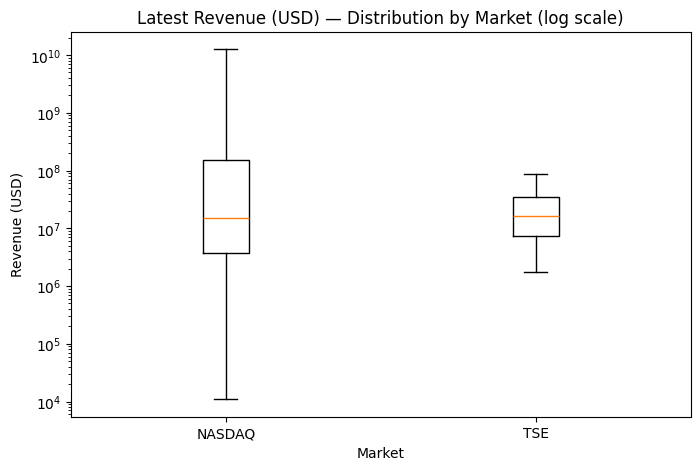

YoY growth sample sizes (by group):


,group,N
0,NASDAQ N-1,21
1,NASDAQ N,78
2,TSE N-1,34
3,TSE N,34


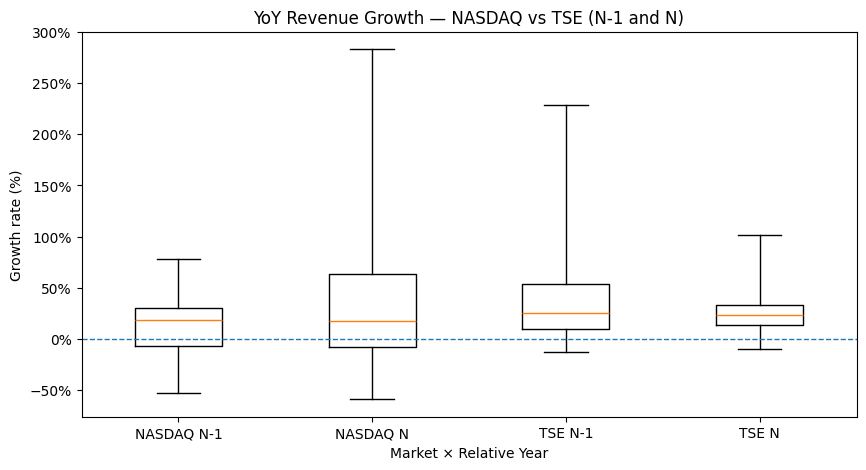

Revenue Growth Summary (N-1):


,NASDAQ,TSE
N,21,34
Min,-53.3%,-13.2%
p25,-7.3%,9.2%
Median,18.1%,25.4%
p75,29.6%,53.1%
Max,78.0%,229.0%


Revenue Growth Summary (N):


,NASDAQ,TSE
N,78,34
Min,-59.3%,-10.0%
p25,-8.5%,13.2%
Median,17.4%,23.3%
p75,62.9%,33.3%
Max,283.4%,101.9%


In [103]:
# ============================================================
# 10. Visualize & Compare US and JP IPOs (NASDAQ vs TSE Growth)
#   - Latest revenue: summary table (USD Millions) + boxplot (log scale)
#   - YoY growth: grouped boxplots (NASDAQ vs TSE, each has N-1 and N)
#   Fixes:
#     * Avoid NaN summary by aggregating with market keys first, then reindexing safely.
#     * Use consistent market labels and robust missing-market handling.
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = df_filtered.copy()

# ---- Markets to compare (edit here if your JP label differs) ----
MARKETS = ["NASDAQ", "TSE Growth"]  # if your JP market column is "TSE", change to ["NASDAQ","TSE"]
MARKET_DISPLAY = {"NASDAQ": "NASDAQ", "TSE Growth": "TSE"}  # display labels
MARKET_ORDER = ["NASDAQ", "TSE Growth"]

# ---- Basic cleaning ----
df = df[df["market"].isin(MARKETS)].copy()
df["fiscal_year"] = df["fiscal_year"].astype("Int64")
df["revenue"] = pd.to_numeric(df["revenue"], errors="coerce")

# Optional quick check
print("Rows by market (non-null revenue):")
display(df.dropna(subset=["revenue"]).groupby("market")["company_key"].nunique().rename("n_companies").reset_index())

def quantile_stats(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce").dropna()
    s = s[np.isfinite(s)]
    if len(s) == 0:
        return pd.Series({"N": 0, "Min": np.nan, "p25": np.nan, "Median": np.nan, "p75": np.nan, "Max": np.nan})
    return pd.Series({
        "N": int(len(s)),
        "Min": float(s.min()),
        "p25": float(s.quantile(0.25)),
        "Median": float(s.median()),
        "p75": float(s.quantile(0.75)),
        "Max": float(s.max()),
    })

# ============================================================
# (A) Latest Revenue (USD): summary table (USD Millions) + log boxplot
# ============================================================
df_rev = df.dropna(subset=["company_key", "fiscal_year", "revenue"]).copy()
df_rev = df_rev.sort_values(["company_key", "fiscal_year"])

# Latest revenue per company = last fiscal_year row per company_key
latest_rev = df_rev.groupby("company_key", as_index=False).tail(1).copy()

# --- Summary table (USD Millions) [FIXED: no duplicate market index] ---

def quantile_stats(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce").dropna()
    s = s[np.isfinite(s)]
    if len(s) == 0:
        return pd.Series({"N": 0, "Min": np.nan, "p25": np.nan, "Median": np.nan, "p75": np.nan, "Max": np.nan})
    return pd.Series({
        "N": int(len(s)),
        "Min": float(s.min()),
        "p25": float(s.quantile(0.25)),
        "Median": float(s.median()),
        "p75": float(s.quantile(0.75)),
        "Max": float(s.max()),
    })

# groupby -> (market, metric) -> value, then unstack to market x metric
stats_by_market = (
    latest_rev.groupby("market")["revenue"]
              .apply(quantile_stats)
              .unstack()   # columns: N, Min, p25, Median, p75, Max
)

# Ensure both markets exist as rows (even if missing)
stats_by_market = stats_by_market.reindex(MARKET_ORDER)

# Build requested vertical table: rows=N,Min,p25,Median,p75,Max ; cols=NASDAQ,TSE
metrics = ["N", "Min", "p25", "Median", "p75", "Max"]
summary = pd.DataFrame(index=metrics, columns=[MARKET_DISPLAY[m] for m in MARKET_ORDER], dtype="float")

for m in MARKET_ORDER:
    col = MARKET_DISPLAY[m]
    if m not in stats_by_market.index:
        continue

    row = stats_by_market.loc[m]

    # N stays as count; others convert USD -> USD Millions
    summary.loc["N", col] = row["N"] if pd.notna(row["N"]) else 0
    for met in ["Min", "p25", "Median", "p75", "Max"]:
        v = row[met]
        summary.loc[met, col] = (v / 1_000_000.0) if pd.notna(v) else np.nan

# Pretty formatting
# ----------------------------
# Pretty display formatting (Revenue: USD Millions)
#   - N: integer
#   - Others: comma + 1 decimal (e.g., 12,640.6)
# ----------------------------
def fmt_int(x):
    if pd.isna(x):
        return ""
    return f"{int(x):d}"

def fmt_million(x):
    if pd.isna(x):
        return ""
    return f"{x:,.1f}"

# summary is numeric: rows=[N, Min, p25, Median, p75, Max], cols=[NASDAQ, TSE]
summary_disp = summary.copy().astype("object")

for c in summary_disp.columns:
    summary_disp.loc["N", c] = fmt_int(summary.loc["N", c])
    for met in ["Min", "p25", "Median", "p75", "Max"]:
        summary_disp.loc[met, c] = fmt_million(summary.loc[met, c])

print("Latest revenue summary (USD Millions):")
display(summary_disp)



# --- Log boxplot (requires revenue>0) ---
latest_rev_pos = latest_rev[latest_rev["revenue"] > 0].copy()

plot_data = []
plot_labels = []
for m in MARKET_ORDER:
    plot_data.append(latest_rev_pos.loc[latest_rev_pos["market"] == m, "revenue"].values)
    plot_labels.append(MARKET_DISPLAY[m])

fig, ax = plt.subplots(figsize=(8, 5))
if sum(len(v) for v in plot_data) == 0:
    ax.text(0.5, 0.5, "No positive latest revenue values available for log-scale plot.",
            ha="center", va="center")
    ax.set_axis_off()
else:
    ax.boxplot(
        plot_data,
        tick_labels=plot_labels,
        showfliers=True,
        whis=(0, 100)  # whiskers = min/max
    )
    ax.set_title("Latest Revenue (USD) — Distribution by Market (log scale)")
    ax.set_xlabel("Market")
    ax.set_ylabel("Revenue (USD)")
    ax.set_yscale("log")
plt.show()

# ============================================================
# (B) YoY Revenue Growth: grouped boxplots (NASDAQ vs TSE, N-1 and N)
#   x-axis: [NASDAQ N-1, NASDAQ N, TSE N-1, TSE N]
# ============================================================
df_yoy = df.dropna(subset=["company_key", "fiscal_year", "revenue"]).copy()
df_yoy = df_yoy.sort_values(["company_key", "fiscal_year"])

df_yoy["prev_year"] = df_yoy.groupby("company_key")["fiscal_year"].shift(1)
df_yoy["prev_revenue"] = df_yoy.groupby("company_key")["revenue"].shift(1)
df_yoy["is_consecutive"] = (df_yoy["fiscal_year"] - df_yoy["prev_year"] == 1)

df_yoy["yoy_growth"] = np.where(
    (df_yoy["is_consecutive"]) & (df_yoy["prev_revenue"] > 0),
    (df_yoy["revenue"] / df_yoy["prev_revenue"]) - 1.0,
    np.nan
)

yoy_valid = df_yoy.dropna(subset=["yoy_growth"]).copy()
yoy_valid = yoy_valid.sort_values(["company_key", "fiscal_year"])

# Relative position within each company's YoY series:
# last YoY point -> N, previous -> N-1
yoy_valid["rank_in_company"] = yoy_valid.groupby("company_key").cumcount()
yoy_valid["k_in_company"] = yoy_valid.groupby("company_key")["rank_in_company"].transform("max")
yoy_valid["rel_idx"] = yoy_valid["rank_in_company"] - yoy_valid["k_in_company"]  # ... -1, 0

# Keep only N-1 and N (you requested to drop N-2)
yoy_valid = yoy_valid[yoy_valid["rel_idx"].isin([-1, 0])].copy()
yoy_valid["rel_label"] = yoy_valid["rel_idx"].map({-1: "N-1", 0: "N"})

# Prepare grouped boxplot data in the requested order
group_order = []
data_ordered = []
labels_ordered = []

for m in MARKET_ORDER:
    for rel in ["N-1", "N"]:
        group_order.append((m, rel))
        vals = yoy_valid.loc[(yoy_valid["market"] == m) & (yoy_valid["rel_label"] == rel), "yoy_growth"].values
        data_ordered.append(vals)
        labels_ordered.append(f"{MARKET_DISPLAY[m]} {rel}")

# Show sample sizes for each group
sizes = pd.DataFrame({
    "group": labels_ordered,
    "N": [len(v) for v in data_ordered]
})
print("YoY growth sample sizes (by group):")
display(sizes)

fig, ax = plt.subplots(figsize=(10, 5))
if sum(len(v) for v in data_ordered) == 0:
    ax.text(0.5, 0.5, "No YoY growth values available (need consecutive years with positive prior revenue).",
            ha="center", va="center")
    ax.set_axis_off()
else:
    ax.boxplot(
        data_ordered,
        tick_labels=labels_ordered,
        showfliers=True,
        whis=(0, 100)  # whiskers = min/max
    )
    ax.set_title("YoY Revenue Growth — NASDAQ vs TSE (N-1 and N)")
    ax.set_xlabel("Market × Relative Year")
    ax.set_ylabel("Growth rate (fraction; 0.25 = +25%)")
    ax.axhline(0.0, linestyle="--", linewidth=1.0)
import matplotlib.ticker as mtick
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.set_ylabel("Growth rate (%)")

plt.xticks(rotation=0)
plt.show()

# ============================================================
# Revenue Growth Summary Tables (N-1 and N)
#   - Same layout as Latest Revenue summary
#   - Rows: N, Min, p25, Median, p75, Max
#   - Columns: NASDAQ, TSE
# ============================================================

import numpy as np
import pandas as pd

MARKET_ORDER = ["NASDAQ", "TSE Growth"]
MARKET_DISPLAY = {"NASDAQ": "NASDAQ", "TSE Growth": "TSE"}

# ----------------------------
# 1. Compute YoY growth safely
# ----------------------------
df_yoy = (
    df_filtered
      .dropna(subset=["company_key", "market", "fiscal_year", "revenue"])
      .sort_values(["company_key", "fiscal_year"])
      .copy()
)

df_yoy["prev_year"] = df_yoy.groupby("company_key")["fiscal_year"].shift(1)
df_yoy["prev_revenue"] = df_yoy.groupby("company_key")["revenue"].shift(1)

df_yoy["is_consecutive"] = (df_yoy["fiscal_year"] - df_yoy["prev_year"] == 1)

df_yoy["yoy_growth"] = np.where(
    (df_yoy["is_consecutive"]) & (df_yoy["prev_revenue"] > 0),
    (df_yoy["revenue"] / df_yoy["prev_revenue"]) - 1.0,
    np.nan
)

# ----------------------------
# 2. Label N-1 / N per company  (dtype-safe)
# ----------------------------
# Latest year = N, second-latest year = N-1 (within available consecutive YoY rows)

df_yoy["rank_desc"] = (
    df_yoy.groupby("company_key")["fiscal_year"]
          .rank(method="first", ascending=False)
)

# Use pd.NA (not np.nan) to avoid mixing string and float dtypes
df_yoy["rel_label"] = pd.Series(
    np.select(
        [df_yoy["rank_desc"].eq(1), df_yoy["rank_desc"].eq(2)],
        ["N", "N-1"],
        default=None,   # keep as None -> becomes <NA> in string dtype below
    ),
    index=df_yoy.index,
    dtype="string"
)

df_yoy = df_yoy.dropna(subset=["rel_label", "yoy_growth"]).copy()


# ----------------------------
# 3. Helper: summary stats
# ----------------------------
def growth_stats(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce").dropna()
    s = s[np.isfinite(s)]
    if len(s) == 0:
        return pd.Series({
            "N": 0, "Min": np.nan, "p25": np.nan,
            "Median": np.nan, "p75": np.nan, "Max": np.nan
        })
    return pd.Series({
        "N": int(len(s)),
        "Min": float(s.min()),
        "p25": float(s.quantile(0.25)),
        "Median": float(s.median()),
        "p75": float(s.quantile(0.75)),
        "Max": float(s.max()),
    })

# ----------------------------
# 4. Build tables for N-1 and N
# ----------------------------
tables = {}

# ----------------------------
# Pretty display formatting (Growth)
#   - N: integer
#   - Others: percent with 1 decimal (e.g., 18.1%)
# ----------------------------
def fmt_pct(x, decimals=1):
    if pd.isna(x):
        return ""
    return f"{(x * 100):,.{decimals}f}%"

def format_growth_table(out_numeric: pd.DataFrame, decimals=1) -> pd.DataFrame:
    disp = out_numeric.copy().astype("object")
    for c in disp.columns:
        disp.loc["N", c] = fmt_int(out_numeric.loc["N", c])
        for k in ["Min", "p25", "Median", "p75", "Max"]:
            disp.loc[k, c] = fmt_pct(out_numeric.loc[k, c], decimals=decimals)
    return disp

for rel in ["N-1", "N"]:
    tmp = df_yoy[df_yoy["rel_label"] == rel]

    stats = (
        tmp.groupby("market")["yoy_growth"]
           .apply(growth_stats)
           .unstack()
           .reindex(MARKET_ORDER)
    )

    # Format like Latest revenue summary
    out = pd.DataFrame(
        index=["N", "Min", "p25", "Median", "p75", "Max"],
        columns=[MARKET_DISPLAY[m] for m in MARKET_ORDER],
        dtype="float"
    )

    for m in MARKET_ORDER:
        if m not in stats.index:
            continue
        row = stats.loc[m]
        for k in out.index:
            out.loc[k, MARKET_DISPLAY[m]] = row.get(k, np.nan)

    # Pretty formatting
    tables[rel] = format_growth_table(out, decimals=1)


# ----------------------------
# 5. Display
# ----------------------------
print("Revenue Growth Summary (N-1):")
display(tables["N-1"])

print("Revenue Growth Summary (N):")
display(tables["N"])

In [101]:
# ============================================================
# 11. Final Outputs (Code)
#   - Persist cleaned datasets, QA results, and summary tables
#   - Timestamped CSVs for reproducibility and auditing
# ============================================================

import os
from datetime import datetime, timezone

# ----------------------------
# 11.1 Output directory & timestamp
# ----------------------------
RUN_TS = datetime.now(timezone.utc).strftime("%Y%m%d_%H%M%S")

BASE_DIR = "data/outputs"
RUN_DIR = os.path.join(BASE_DIR, RUN_TS)

os.makedirs(RUN_DIR, exist_ok=True)

print(f"[OK] Output directory created: {RUN_DIR}")

# ----------------------------
# 11.2 Core cleaned datasets
# ----------------------------

paths_core = {
    "combined_revenue_long": f"{RUN_DIR}/combined_revenue_long.csv",
    "filtered_revenue_long": f"{RUN_DIR}/filtered_revenue_long.csv",
}

combined_revenue_long.to_csv(
    paths_core["combined_revenue_long"],
    index=False
)

df_filtered.to_csv(
    paths_core["filtered_revenue_long"],
    index=False
)

print("[OK] Core datasets saved:")
for k, v in paths_core.items():
    print("  -", v)

# ----------------------------
# 11.3 QA & validation outputs
# ----------------------------

paths_qa = {
    "qa_review": f"{RUN_DIR}/qa_review_revenue.csv",
    "excluded_companies": f"{RUN_DIR}/excluded_companies.csv",
}

qa_review.to_csv(
    paths_qa["qa_review"],
    index=False
)

# Companies removed from df_filtered
excluded_companies = (
    combined_revenue_long
      .loc[~combined_revenue_long["company_key"].isin(df_filtered["company_key"])]
      [["company_key", "market", "company_name", "ticker"]]
      .drop_duplicates()
      .sort_values(["market", "company_key"])
)

excluded_companies.to_csv(
    paths_qa["excluded_companies"],
    index=False
)

print("[OK] QA outputs saved:")
for k, v in paths_qa.items():
    print("  -", v)

# ----------------------------
# 11.4 Summary tables (publication-ready)
# ----------------------------

paths_summary = {
    "latest_revenue_summary_usd_m": f"{RUN_DIR}/summary_latest_revenue_usd_millions.csv",
    "growth_summary_n_minus_1": f"{RUN_DIR}/summary_revenue_growth_N-1.csv",
    "growth_summary_n": f"{RUN_DIR}/summary_revenue_growth_N.csv",
}

summary_disp.to_csv(
    paths_summary["latest_revenue_summary_usd_m"],
    index=True
)

tables["N-1"].to_csv(
    paths_summary["growth_summary_n_minus_1"],
    index=True
)

tables["N"].to_csv(
    paths_summary["growth_summary_n"],
    index=True
)

print("[OK] Summary tables saved:")
for k, v in paths_summary.items():
    print("  -", v)

# ----------------------------
# 11.5 Run manifest (metadata)
# ----------------------------

manifest = {
    "run_timestamp_utc": RUN_TS,
    "markets_included": ["NASDAQ", "TSE Growth"],
    "n_companies_raw": int(combined_revenue_long["company_key"].nunique()),
    "n_companies_filtered": int(df_filtered["company_key"].nunique()),
    "n_rows_raw": int(len(combined_revenue_long)),
    "n_rows_filtered": int(len(df_filtered)),
    "exclusion_reason_file": "qa_review_revenue.csv",
    "notes": (
        "Revenues normalized to USD. "
        "JP revenues converted using fixed FX rate. "
        "Outliers removed based on YoY spikes, level checks, and volatility."
    ),
}

manifest_df = (
    pd.DataFrame.from_dict(manifest, orient="index")
      .reset_index()
      .rename(columns={"index": "key", 0: "value"})
)

manifest_path = f"{RUN_DIR}/run_manifest.csv"
manifest_df.to_csv(manifest_path, index=False)

print("[OK] Run manifest saved:")
print("  -", manifest_path)


[OK] Output directory created: data/outputs/20251225_073815
[OK] Core datasets saved:
  - data/outputs/20251225_073815/combined_revenue_long.csv
  - data/outputs/20251225_073815/filtered_revenue_long.csv
[OK] QA outputs saved:
  - data/outputs/20251225_073815/qa_review_revenue.csv
  - data/outputs/20251225_073815/excluded_companies.csv
[OK] Summary tables saved:
  - data/outputs/20251225_073815/summary_latest_revenue_usd_millions.csv
  - data/outputs/20251225_073815/summary_revenue_growth_N-1.csv
  - data/outputs/20251225_073815/summary_revenue_growth_N.csv
[OK] Run manifest saved:
  - data/outputs/20251225_073815/run_manifest.csv
